In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    accuracy_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import optuna

import os

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scenario_datasets = os.listdir("./Scenarios")
scenario_datasets = [f"./Scenarios/{x}" for x in scenario_datasets]
scenario_datasets

['./Scenarios/dataset_scenario_1_N.csv',
 './Scenarios/dataset_scenario_1_S.csv',
 './Scenarios/dataset_scenario_2_N.csv',
 './Scenarios/dataset_scenario_2_S.csv',
 './Scenarios/dataset_scenario_3_N.csv',
 './Scenarios/dataset_scenario_3_S.csv',
 './Scenarios/dataset_scenario_4_N.csv',
 './Scenarios/dataset_scenario_4_S.csv',
 './Scenarios/dataset_scenario_5_N.csv',
 './Scenarios/dataset_scenario_5_S.csv',
 './Scenarios/dataset_scenario_6_N.csv',
 './Scenarios/dataset_scenario_6_S.csv',
 './Scenarios/dataset_scenario_7_N.csv',
 './Scenarios/dataset_scenario_7_S.csv',
 './Scenarios/dataset_scenario_8_N.csv',
 './Scenarios/dataset_scenario_8_S.csv']

In [3]:
scenarios_description = [
    {"name": "Scenario 1_N", "encoding": "Label encoding", "remove_outliers": False, "remove_errors": False, "scaling": "MinMax"},
    {"name": "Scenario 1_S", "encoding": "Label encoding", "remove_outliers": False, "remove_errors": False, "scaling": "Standard"},
    {"name": "Scenario 2_N", "encoding": "Label encoding", "remove_outliers": False, "remove_errors": False,
     "impute_zeros": {"RestingBP": "mean", "Cholesterol": "mean"}, "oldpeak_abs": True, "scaling": "MinMax"},
    {"name": "Scenario 2_S", "encoding": "Label encoding", "remove_outliers": False, "remove_errors": False,
     "impute_zeros": {"RestingBP": "mean", "Cholesterol": "mean"}, "oldpeak_abs": True, "scaling": "Standard"},
    {"name": "Scenario 3_N", "encoding": "Label encoding", "remove_outliers": True, "remove_errors": True, "scaling": "None"},
    {"name": "Scenario 3_S", "encoding": "Label encoding", "remove_outliers": True, "remove_errors": True, "scaling": "Standard"},
    {"name": "Scenario 4_N", "encoding": "Label encoding", "remove_outliers": "replace_with_mean", "remove_errors": True, "scaling": "MinMax"},
    {"name": "Scenario 4_S", "encoding": "Label encoding", "remove_outliers": "replace_with_mean", "remove_errors": True, "scaling": "Standard"},
    {"name": "Scenario 5_N", "encoding": {"Sex": "Label", "ExerciseAngina": "Label", "ST_Slope": "Label", "RestingECG": "Label", "ChestPainType": "OneHot"},
     "remove_outliers": False, "remove_errors": False, "scaling": "MinMax"},
    {"name": "Scenario 5_S", "encoding": {"Sex": "Label", "ExerciseAngina": "Label", "ST_Slope": "Label", "RestingECG": "Label", "ChestPainType": "OneHot"},
     "remove_outliers": False, "remove_errors": False, "scaling": "Standard"},
    {"name": "Scenario 6_N", "encoding": {"Sex": "Label", "ExerciseAngina": "Label", "ST_Slope": "Label", "RestingECG": "Label", "ChestPainType": "OneHot"},
     "remove_outliers": False, "remove_errors": True, "scaling": "None"},
    {"name": "Scenario 6_S", "encoding": {"Sex": "Label", "ExerciseAngina": "Label", "ST_Slope": "Label", "RestingECG": "Label", "ChestPainType": "OneHot"},
     "remove_outliers": False, "remove_errors": True, "scaling": "Standard"},
    {"name": "Scenario 7_N", "encoding": {"Sex": "Label", "ExerciseAngina": "Label", "ST_Slope": "Label", "RestingECG": "Label", "ChestPainType": "OneHot"},
     "remove_outliers": True, "remove_errors": True, "scaling": "MinMax"},
    {"name": "Scenario 7_S", "encoding": {"Sex": "Label", "ExerciseAngina": "Label", "ST_Slope": "Label", "RestingECG": "Label", "ChestPainType": "OneHot"},
     "remove_outliers": True, "remove_errors": True, "scaling": "Standard"},
    {"name": "Scenario 8_N", "encoding": {"Sex": "Label", "ExerciseAngina": "Label", "ST_Slope": "Label", "RestingECG": "Label", "ChestPainType": "OneHot"},
     "remove_outliers": "replace_with_mean", "remove_errors": True, "scaling": "None"},
    {"name": "Scenario 8_S", "encoding": {"Sex": "Label", "ExerciseAngina": "Label", "ST_Slope": "Label", "RestingECG": "Label", "ChestPainType": "OneHot"},
     "remove_outliers": "replace_with_mean", "remove_errors": True, "scaling": "Standard"},
]


In [4]:
def get_search_hyperparameters(model_type):
    if model_type == "NaiveBayes":
        return {
            "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
            "priors": [None],
        }
    elif model_type == "SVM":
        return {
            "C": [0.1, 1, 10, 100, 1000],
            "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
            "kernel": ["rbf", "linear", "poly", "sigmoid"],
        }
    else:
        return {}

In [5]:
class optuna_tuner:
    def __init__(self, model, X_train, y_train, direction="maximize", n_trials=100, n_jobs=-1, scoring="accuracy", cv=5):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.direction = direction
        self.n_trials = n_trials
        self.n_jobs = n_jobs
        self.scoring = scoring
        self.cv = cv

    def objective(self, trial):
        # Handle Naive Bayes (GaussianNB)
        if isinstance(self.model, GaussianNB):
            model = GaussianNB(
                var_smoothing=trial.suggest_float("var_smoothing", 1e-9, 1e-5)
            )
        
        # Handle Support Vector Machines (SVM)
        elif isinstance(self.model, SVC):
            model = SVC(
                C=trial.suggest_float("C", 1e-3, 10),
                gamma=trial.suggest_float("gamma", 1e-3, 10),
                kernel=trial.suggest_categorical("kernel", ["rbf", "linear", "poly", "sigmoid"]),
            )
        else:
            raise ValueError("Unsupported model type for optimization.")

        # Perform cross-validation and return the mean score
        scores = cross_val_score(model, self.X_train, self.y_train, cv=self.cv, scoring=self.scoring, n_jobs=self.n_jobs)
        return scores.mean()

    def optimize_study(self):
        study = optuna.create_study(direction=self.direction)
        study.optimize(self.objective, n_trials=self.n_trials)
        return study.best_params


In [ ]:
class ModelTrainer:
    def __init__(self, dataset, target_column, model):
        self.dataset = dataset
        self.target_column = target_column
        self.X = dataset.drop(target_column, axis=1)
        self.y = dataset[target_column]
        self.model = model
        self.results = {}

    def split_data(self, test_size=0.2, val_size=0.1, random_state=42):
        X_train, X_temp, y_train, y_temp = train_test_split(
            self.X, self.y, test_size=test_size + val_size, random_state=random_state
        )
        val_ratio = val_size / (test_size + val_size)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            X_temp, y_temp, test_size=val_ratio, random_state=random_state
        )
        self.X_train, self.y_train = X_train, y_train
        
    def train(self):
        self.model.fit(self.X_train, self.y_train)

    def tune_and_train(self,search_type , search_config, param_grid):

        clf = self.model
        if search_type == "grid":
            search = GridSearchCV(clf, param_grid, cv=search_config["cv"], scoring=search_config["scoring"])
        elif search_type == "random":
            search = RandomizedSearchCV(clf, param_grid, cv=search_config["cv"], scoring=search_config["scoring"], n_iter=search_config["n_iter"])
        elif search_type == "optuna":
            search = optuna_tuner(self.model, self.X_train, self.y_train, search_config["direction"], search_config["n_trials"], search_config["n_jobs"], search_config["scoring"], search_config["cv"])

        best_params = None
        if isinstance(search, optuna_tuner):
            best_params = search.optimize_study()
            self.model = self.model.set_params(**best_params)
        elif search_type == "grid" or search_type == "random":
            search.fit(self.X_train, self.y_train)
            best_params = search.best_params_
            self.model = search.best_estimator_

        print("Best hyperparameters: ", best_params)

        # TODO: Get scores for train, val, and test sets

    def test_and_evaluate(self, save_dir=None):
        # Predict on validation and test sets
        y_val_pred = self.model.predict(self.X_val)
        y_test_pred = self.model.predict(self.X_test)

        # Calculate metrics for validation and test sets
        metrics_val = {
            "accuracy": accuracy_score(self.y_val, y_val_pred),
            "precision": precision_score(self.y_val, y_val_pred, average="weighted"),
            "recall": recall_score(self.y_val, y_val_pred, average="weighted"),
            "f1_score": f1_score(self.y_val, y_val_pred, average="weighted"),
            "confusion_matrix": confusion_matrix(self.y_val, y_val_pred),
        }

        metrics_test = {
            "accuracy": accuracy_score(self.y_test, y_test_pred),
            "precision": precision_score(self.y_test, y_test_pred, average="weighted"),
            "recall": recall_score(self.y_test, y_test_pred, average="weighted"),
            "f1_score": f1_score(self.y_test, y_test_pred, average="weighted"),
            "confusion_matrix": confusion_matrix(self.y_test, y_test_pred),
        }

        # Store results
        self.results["validation"] = metrics_val
        self.results["test"] = metrics_test

        # Print evaluation metrics
        print("Validation Metrics:")
        print(f"  Accuracy: {metrics_val['accuracy']:.4f}")
        print(f"  Precision: {metrics_val['precision']:.4f}")
        print(f"  Recall: {metrics_val['recall']:.4f}")
        print(f"  F1 Score: {metrics_val['f1_score']:.4f}")
        print("\nTest Metrics:")
        print(f"  Accuracy: {metrics_test['accuracy']:.4f}")
        print(f"  Precision: {metrics_test['precision']:.4f}")
        print(f"  Recall: {metrics_test['recall']:.4f}")
        print(f"  F1 Score: {metrics_test['f1_score']:.4f}")

        # Confusion matrix visualization for test set
        print("\nConfusion Matrix (Test Set):")
        cm = metrics_test["confusion_matrix"]
        print(cm)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
        plt.title("Confusion Matrix - Test Set")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
        plt.show()

    def plot_results(self, save_dir=None):
        pass

In [7]:
search_config_grid = {
    "cv": 5,
    "scoring": "accuracy",
}
search_config_random = {
    "cv": 5,
    "scoring": "accuracy",
    "n_iter": 50,
}
search_config_optuna = {
    "direction": "maximize",
    "n_trials": 100,
    "n_jobs": -1,
    "scoring": "accuracy",
    "cv": 5,
}

target_column = "HeartDisease"

In [8]:
def run_scenario(scenario, model_type, search_type, search_config, param_grid):
    # Load the dataset
    dataset = pd.read_csv(scenario)
    model = None

    # Initialize the model based on the model_type
    if model_type == "NaiveBayes":
        model = GaussianNB()
    elif model_type == "SVM":
        model = SVC()
    else:
        raise ValueError(f"Model type {model_type} is not supported.")

    # Create a directory for saving plots and results
    scenario_name = os.path.splitext(os.path.basename(scenario))[0]  # Extract scenario name from file
    save_dir = os.path.join("SCORES", model_type, search_type, scenario_name)  # SCORES as top-level directory
    os.makedirs(save_dir, exist_ok=True)

    print(f"Running {model_type} with {search_type} for {scenario_name}...")
    print(f"Results will be saved in: {save_dir}")

    # Initialize the trainer
    trainer = ModelTrainer(dataset, target_column, model)
    trainer.split_data()

    # Train and tune the model
    if search_type:
        trainer.tune_and_train(search_type, search_config, param_grid)
    else:
        trainer.train()  # Train without hyperparameter tuning

    # Evaluate the model
    trainer.test_and_evaluate(save_dir=save_dir)

    # Plot results for the current scenario
    trainer.plot_results(save_dir=save_dir)

    print(f"Scenario {scenario_name} with {search_type} completed and results saved.\n")


# Naive Bayes

## 1. Grid Search

Scenario Name: Scenario 1_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with grid for dataset_scenario_1_N...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_1_N
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8804
  Precision: 0.8810
  Recall: 0.8804
  F1 Score: 0.8806

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


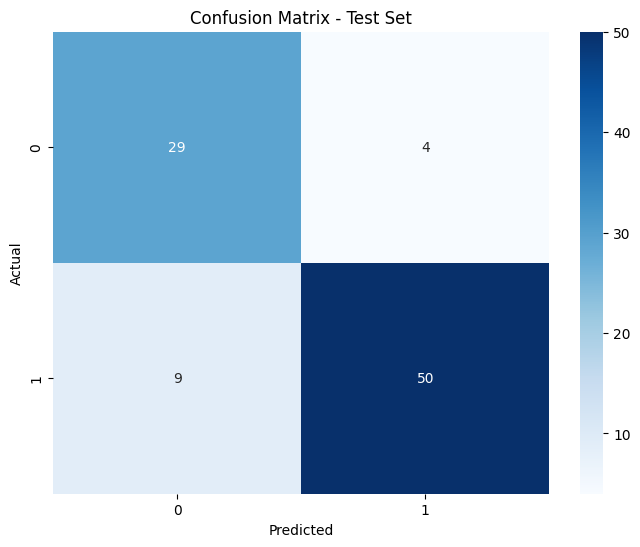

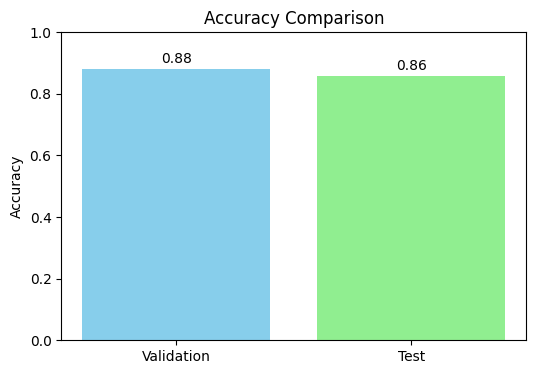

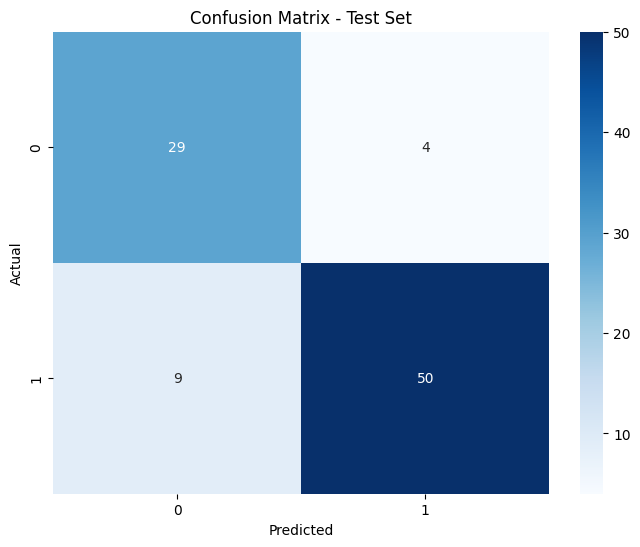

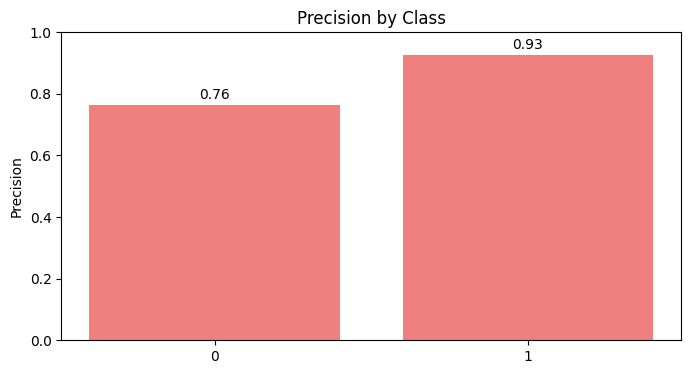

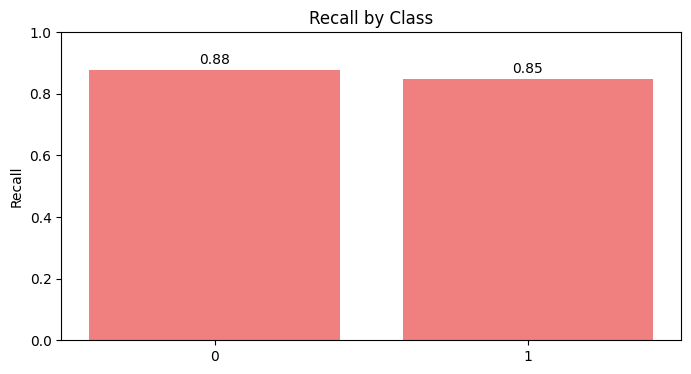

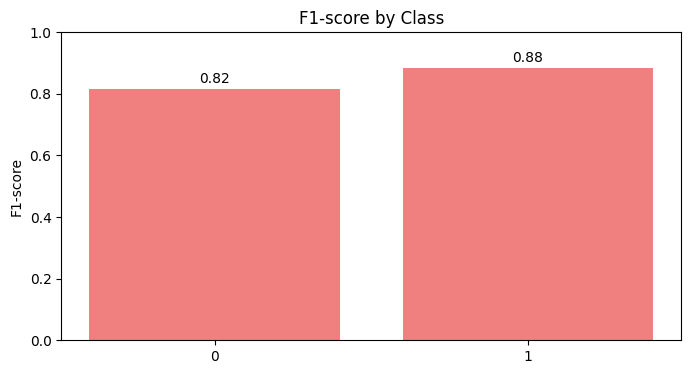

Scenario dataset_scenario_1_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 1_S
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with grid for dataset_scenario_1_S...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_1_S
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8804
  Precision: 0.8810
  Recall: 0.8804
  F1 Score: 0.8806

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


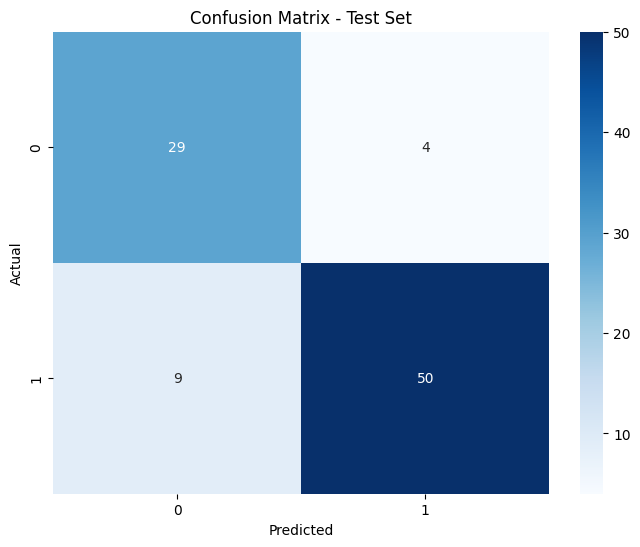

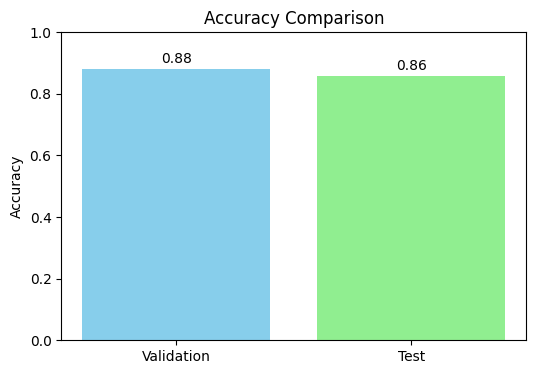

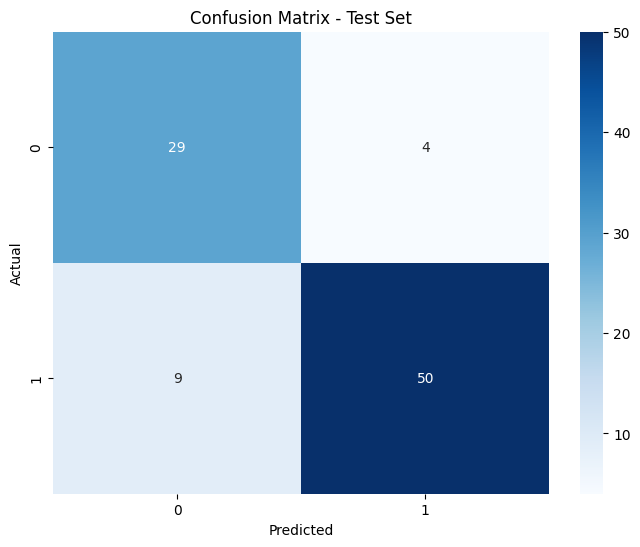

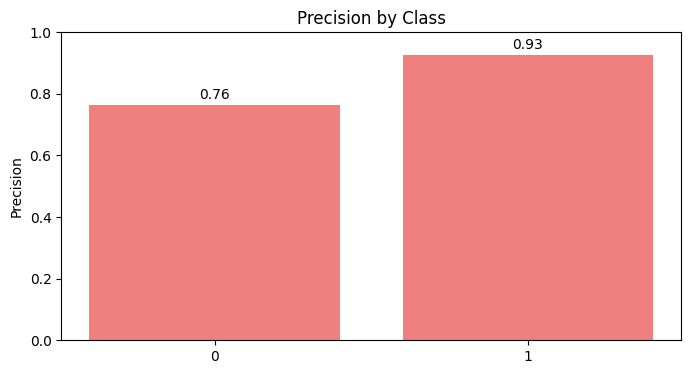

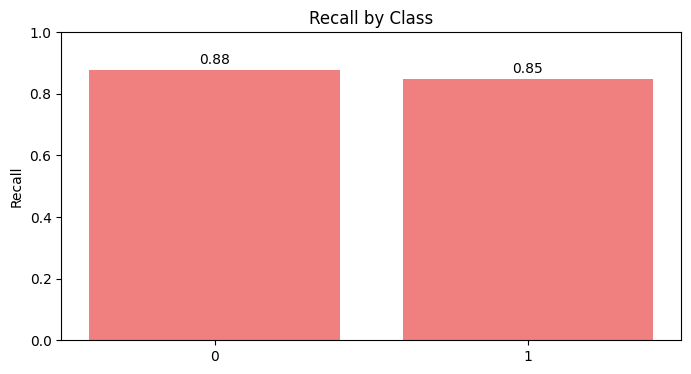

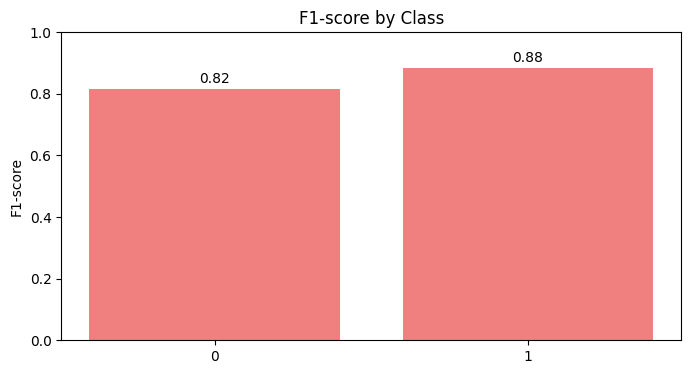

Scenario dataset_scenario_1_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 2_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: {'RestingBP': 'mean', 'Cholesterol': 'mean'}
  Oldpeak Absolute: True
  Scaling: MinMax
Running NaiveBayes with grid for dataset_scenario_2_N...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_2_N
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8478
  Precision: 0.8523
  Recall: 0.8478
  F1 Score: 0.8485

Test Metrics:
  Accuracy: 0.8261
  Precision: 0.8447
  Recall: 0.8261
  F1 Score: 0.8292

Confusion Matrix (Test Set):
[[29  4]
 [12 47]]


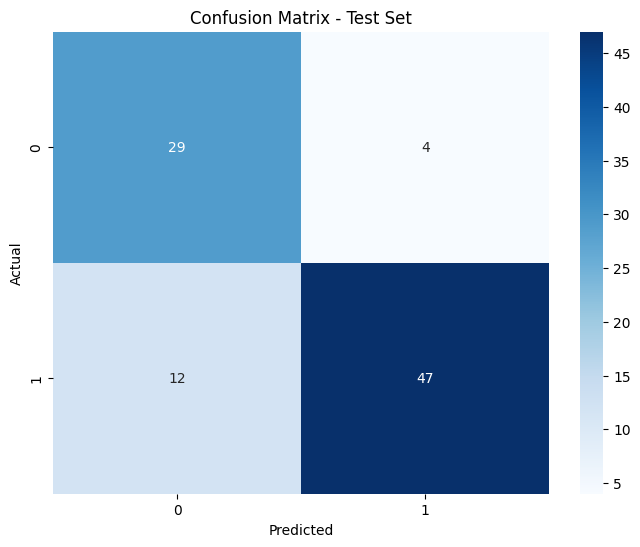

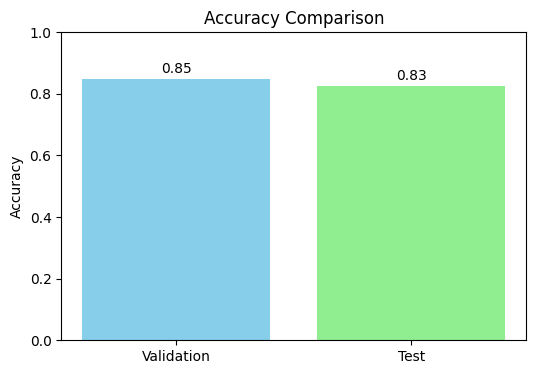

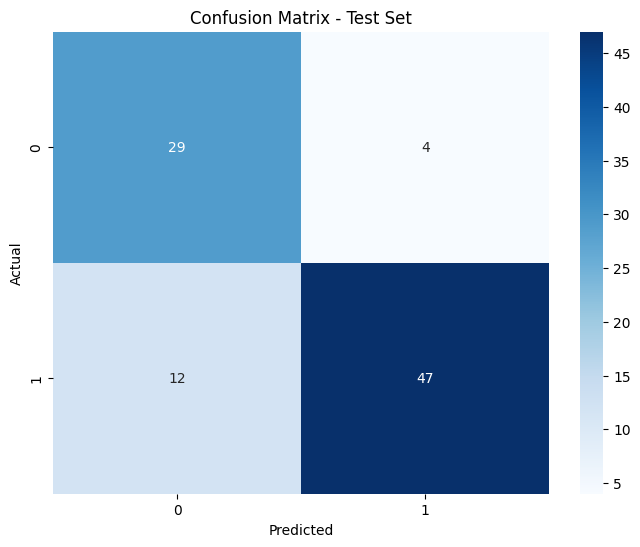

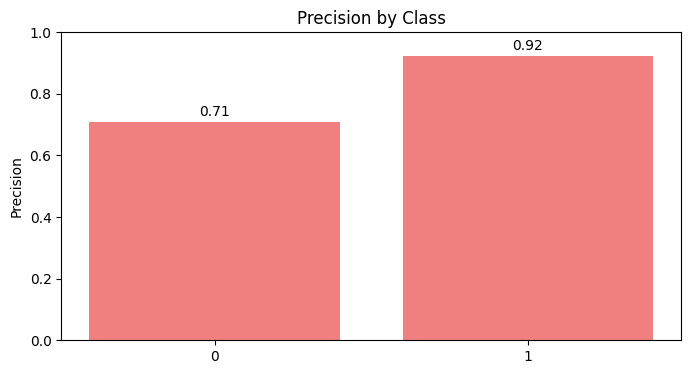

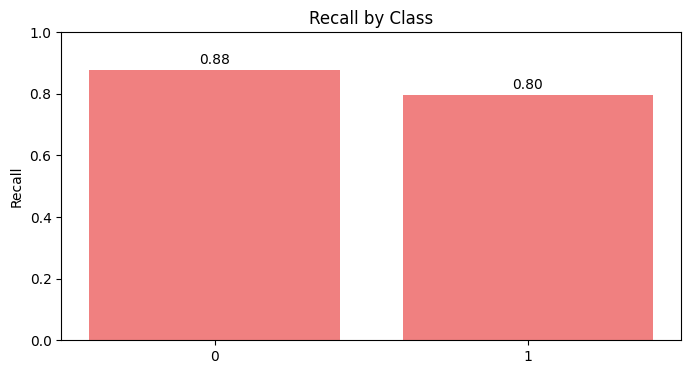

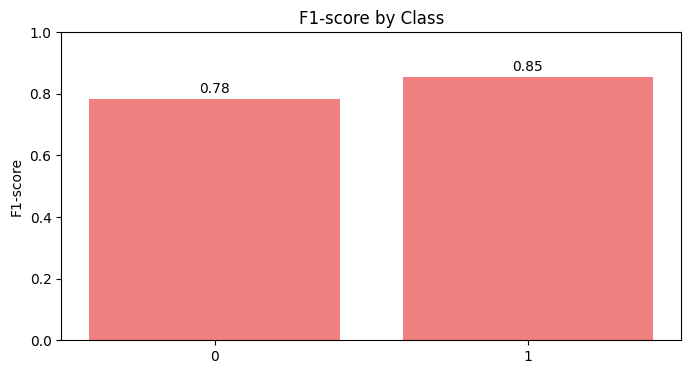

Scenario dataset_scenario_2_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 2_S
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: {'RestingBP': 'mean', 'Cholesterol': 'mean'}
  Oldpeak Absolute: True
  Scaling: Standard
Running NaiveBayes with grid for dataset_scenario_2_S...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_2_S
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8478
  Precision: 0.8523
  Recall: 0.8478
  F1 Score: 0.8485

Test Metrics:
  Accuracy: 0.8261
  Precision: 0.8447
  Recall: 0.8261
  F1 Score: 0.8292

Confusion Matrix (Test Set):
[[29  4]
 [12 47]]


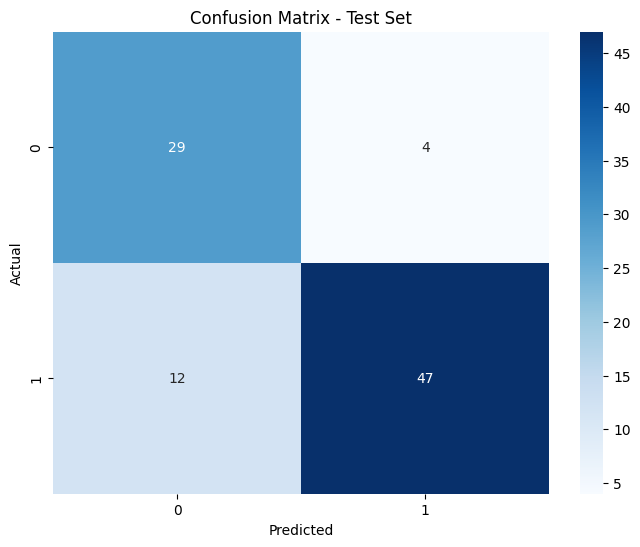

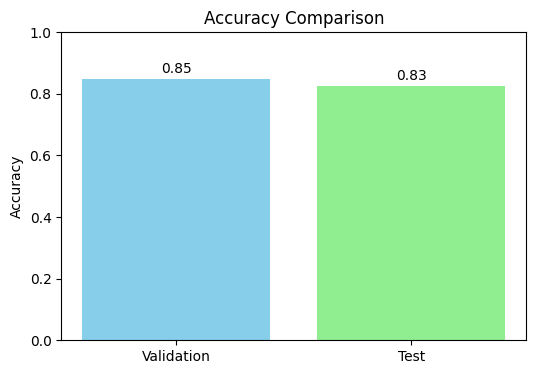

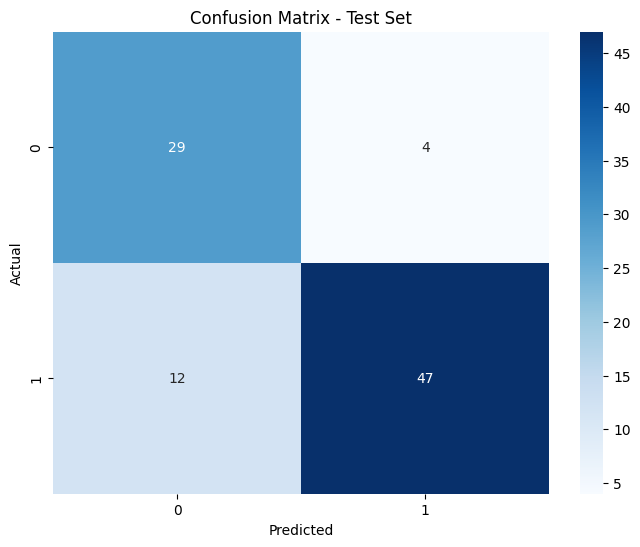

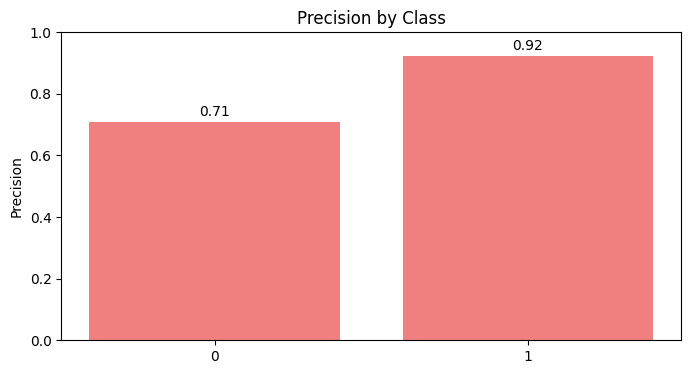

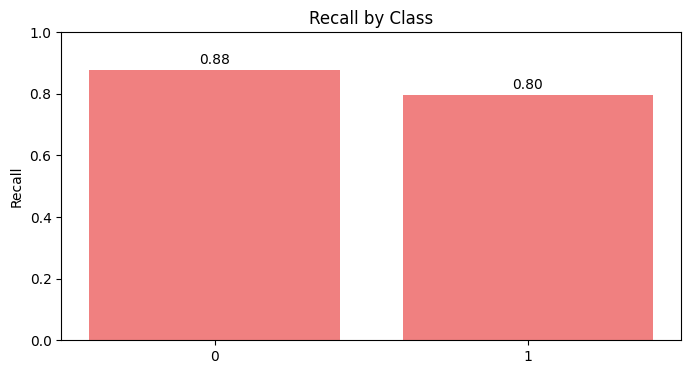

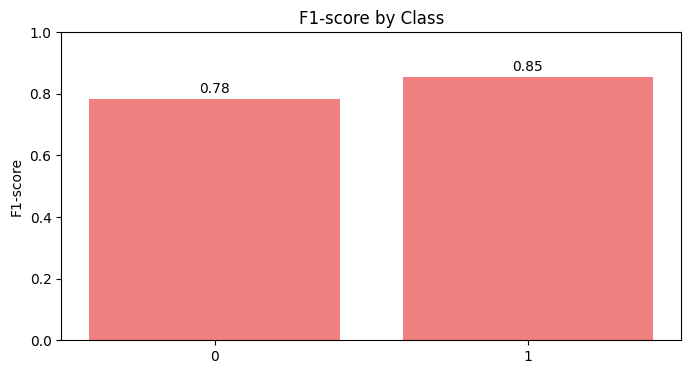

Scenario dataset_scenario_2_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 3_N
  Encoding: Label encoding
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running NaiveBayes with grid for dataset_scenario_3_N...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_3_N
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8429
  Precision: 0.8427
  Recall: 0.8429
  F1 Score: 0.8426

Test Metrics:
  Accuracy: 0.7887
  Precision: 0.7982
  Recall: 0.7887
  F1 Score: 0.7896

Confusion Matrix (Test Set):
[[30 10]
 [ 5 26]]


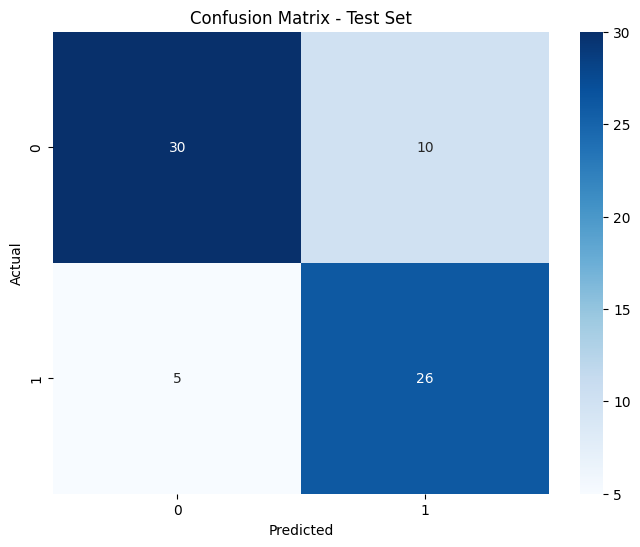

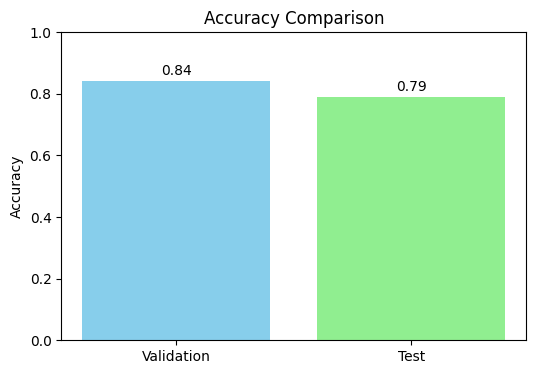

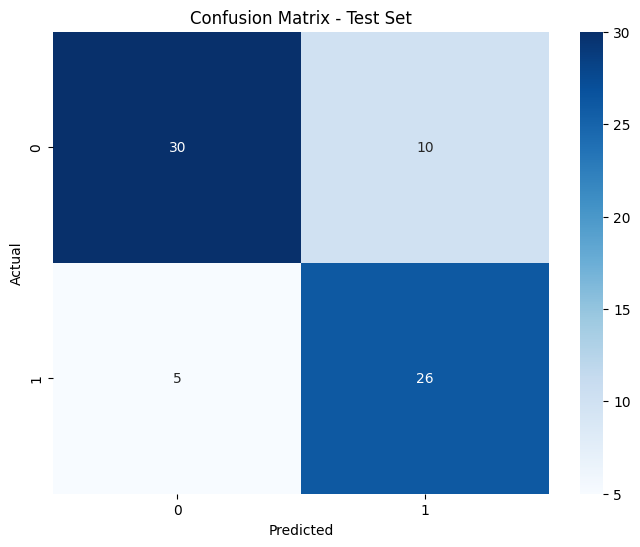

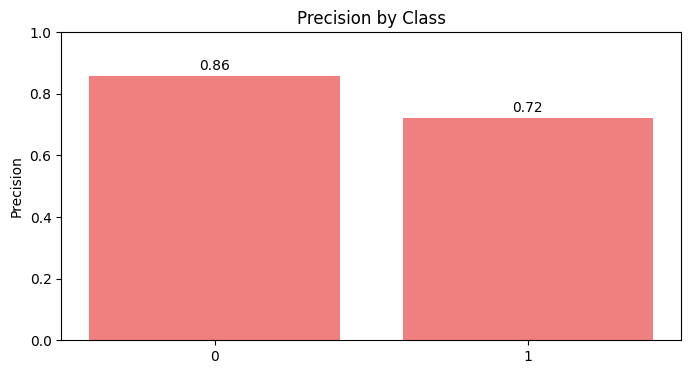

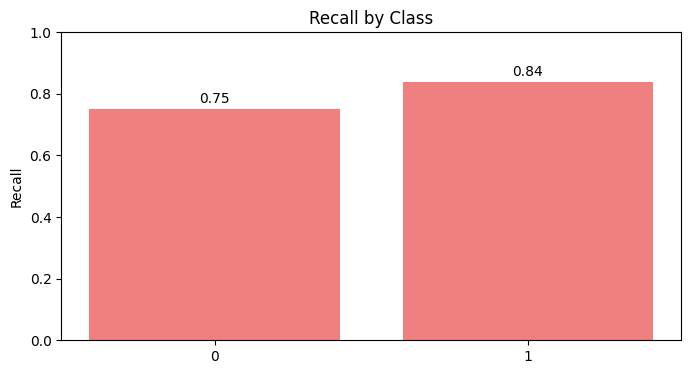

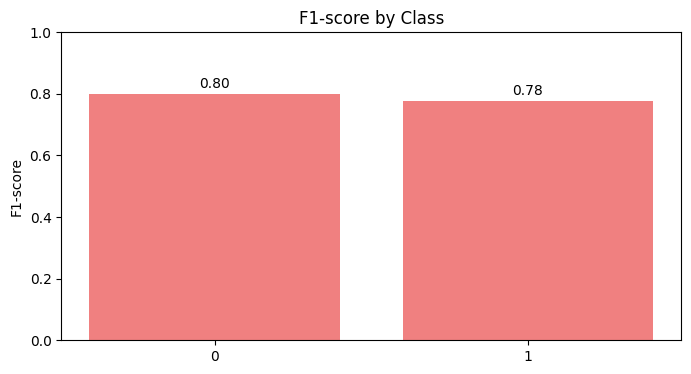

Scenario dataset_scenario_3_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 3_S
  Encoding: Label encoding
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with grid for dataset_scenario_3_S...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_3_S
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8429
  Precision: 0.8427
  Recall: 0.8429
  F1 Score: 0.8426

Test Metrics:
  Accuracy: 0.7887
  Precision: 0.7982
  Recall: 0.7887
  F1 Score: 0.7896

Confusion Matrix (Test Set):
[[30 10]
 [ 5 26]]


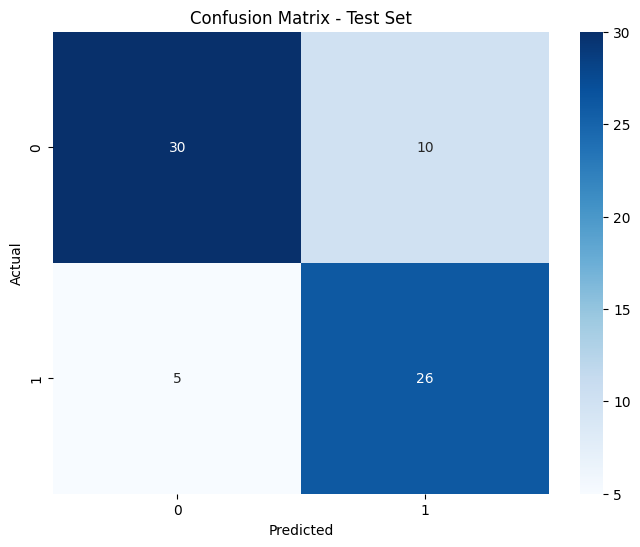

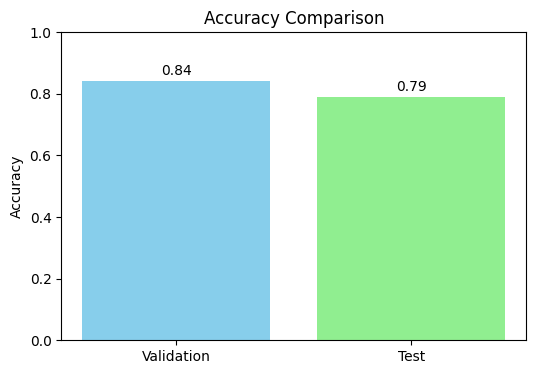

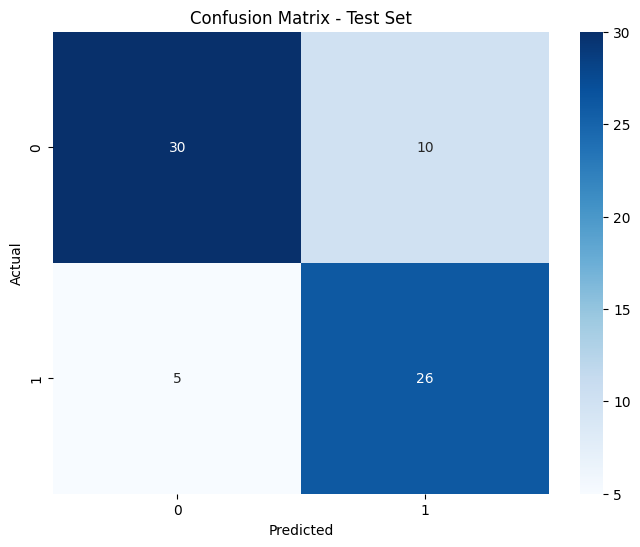

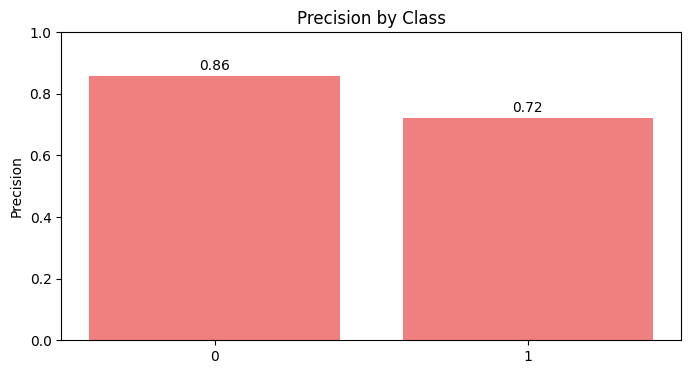

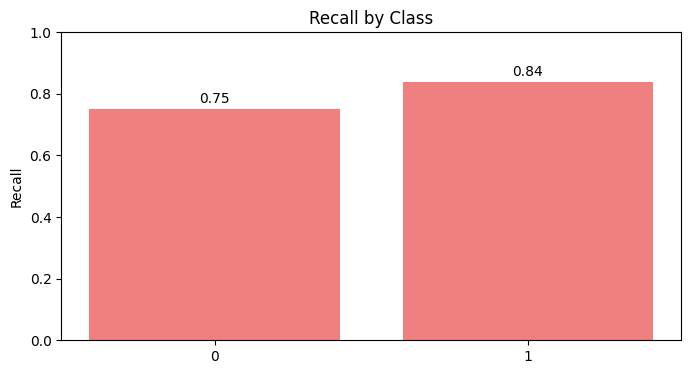

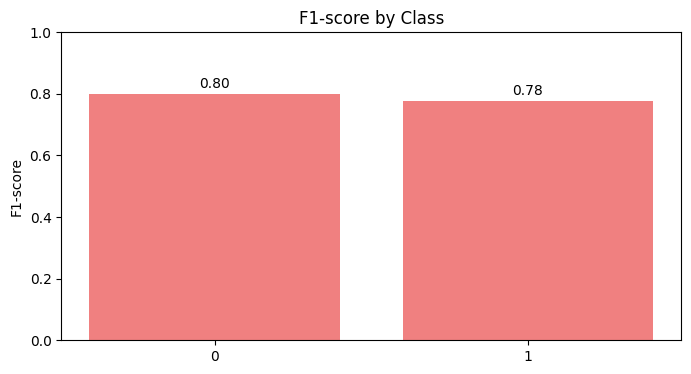

Scenario dataset_scenario_3_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 4_N
  Encoding: Label encoding
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with grid for dataset_scenario_4_N...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_4_N
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8370
  Precision: 0.8434
  Recall: 0.8370
  F1 Score: 0.8377

Test Metrics:
  Accuracy: 0.8152
  Precision: 0.8377
  Recall: 0.8152
  F1 Score: 0.8187

Confusion Matrix (Test Set):
[[29  4]
 [13 46]]


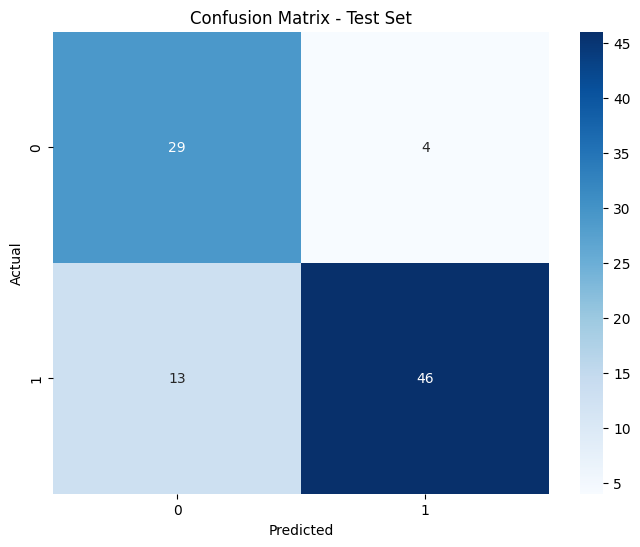

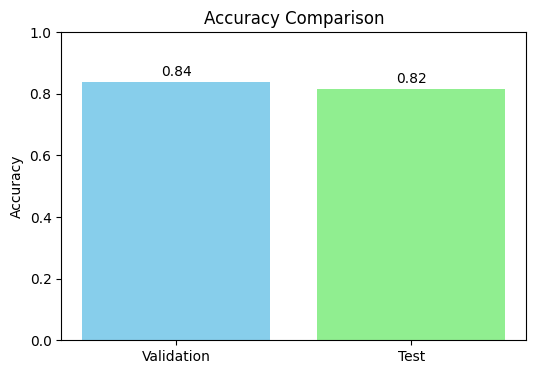

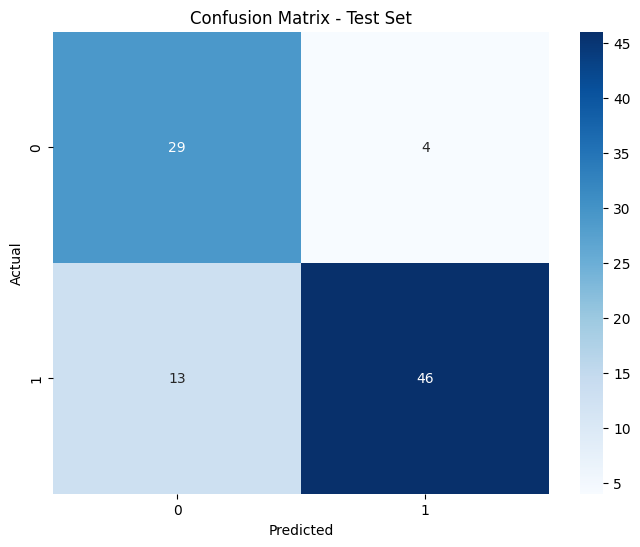

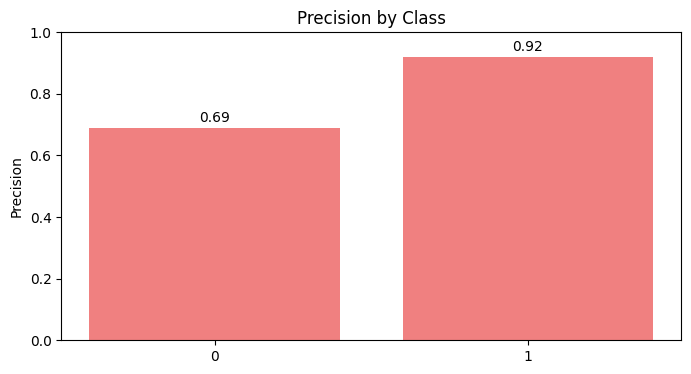

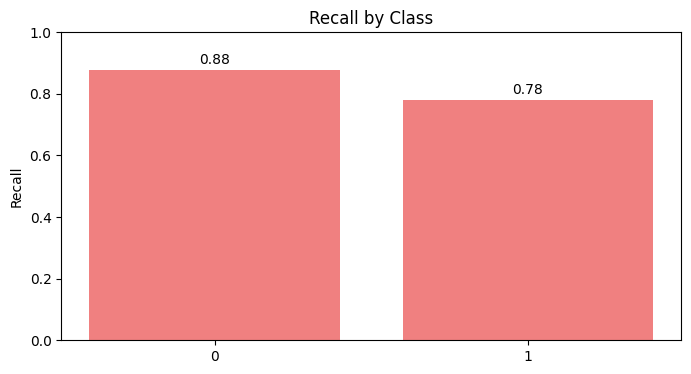

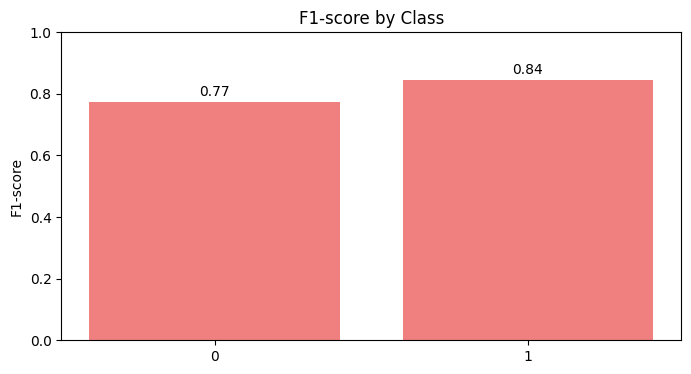

Scenario dataset_scenario_4_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 4_S
  Encoding: Label encoding
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with grid for dataset_scenario_4_S...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_4_S
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8370
  Precision: 0.8434
  Recall: 0.8370
  F1 Score: 0.8377

Test Metrics:
  Accuracy: 0.8152
  Precision: 0.8377
  Recall: 0.8152
  F1 Score: 0.8187

Confusion Matrix (Test Set):
[[29  4]
 [13 46]]


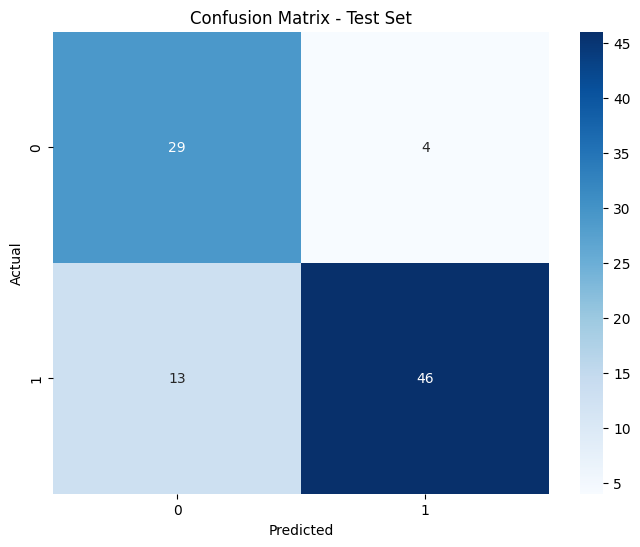

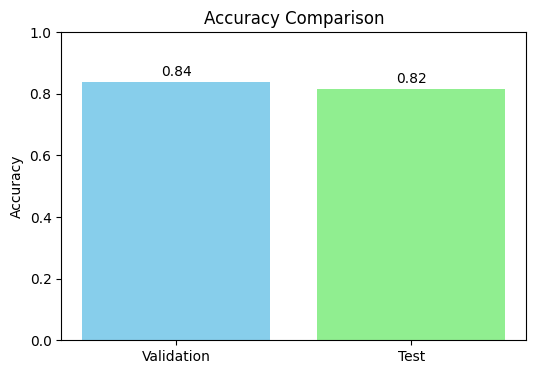

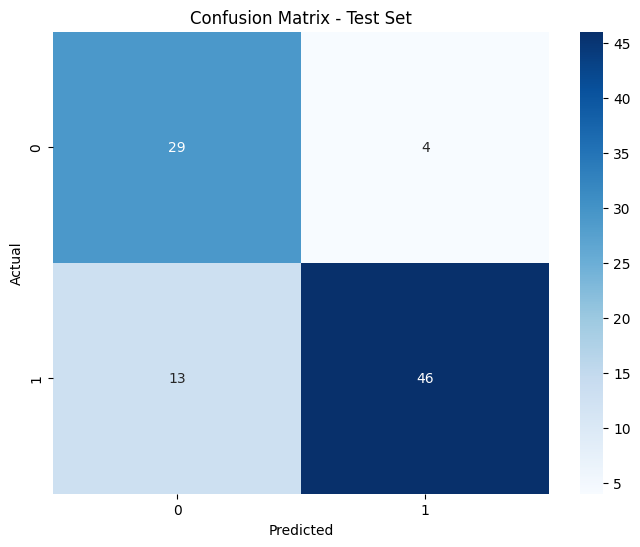

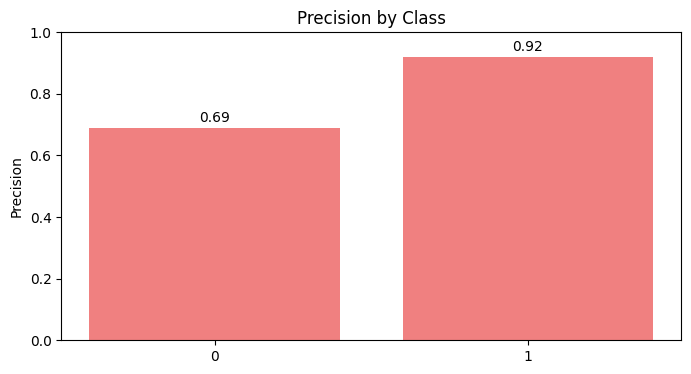

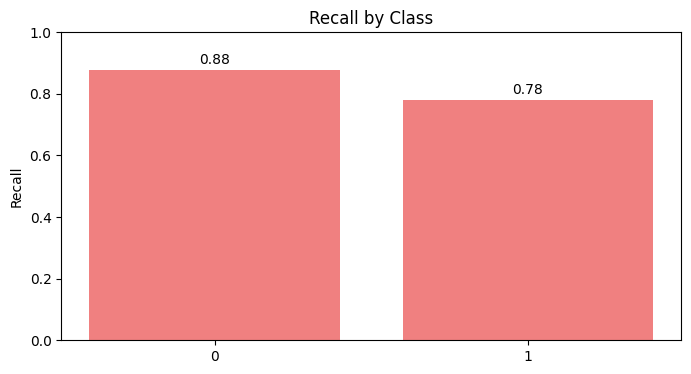

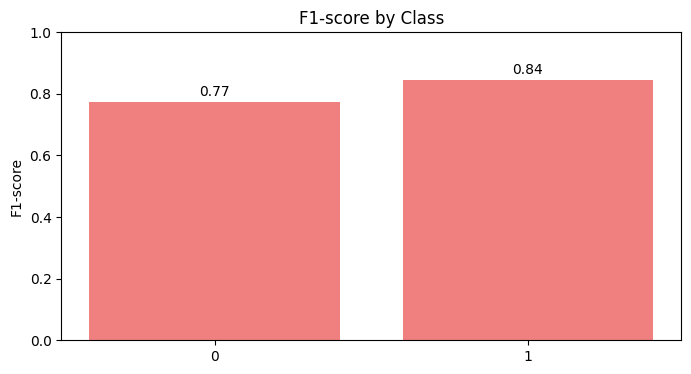

Scenario dataset_scenario_4_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 5_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with grid for dataset_scenario_5_N...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_5_N
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8641
  Precision: 0.8677
  Recall: 0.8641
  F1 Score: 0.8647

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


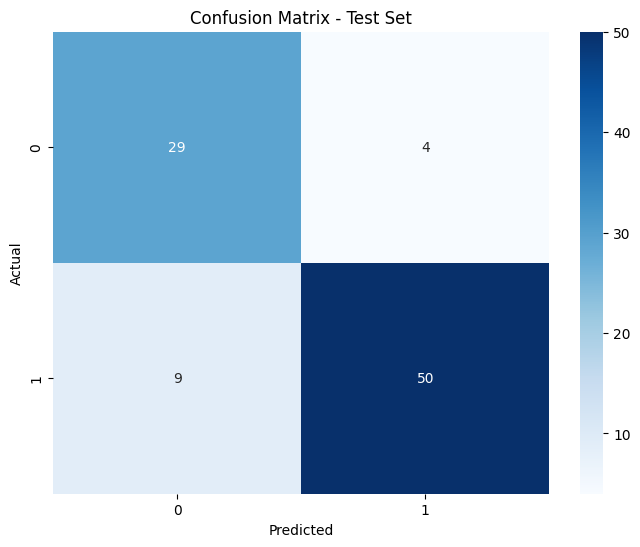

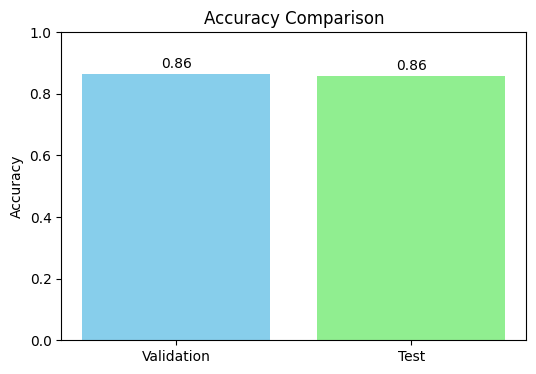

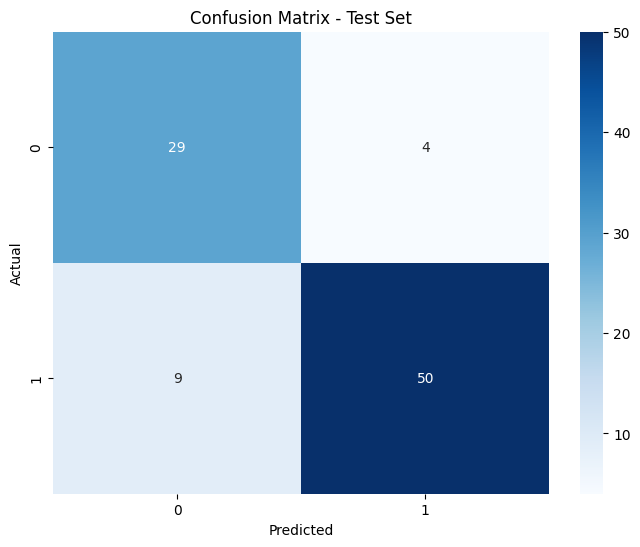

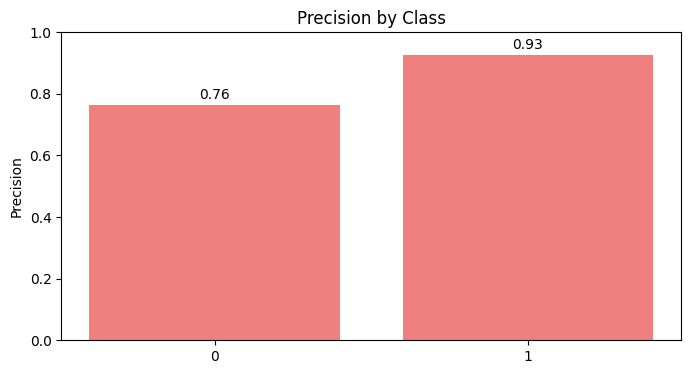

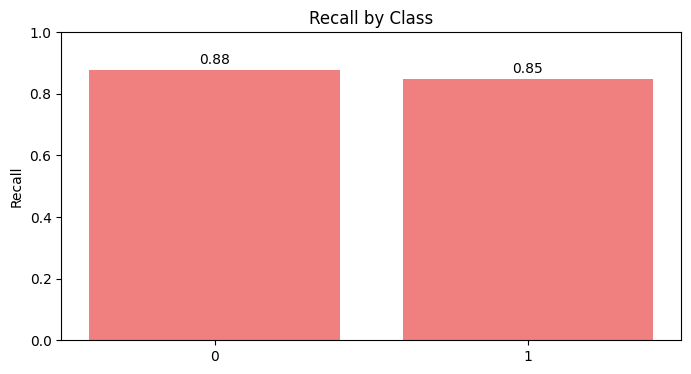

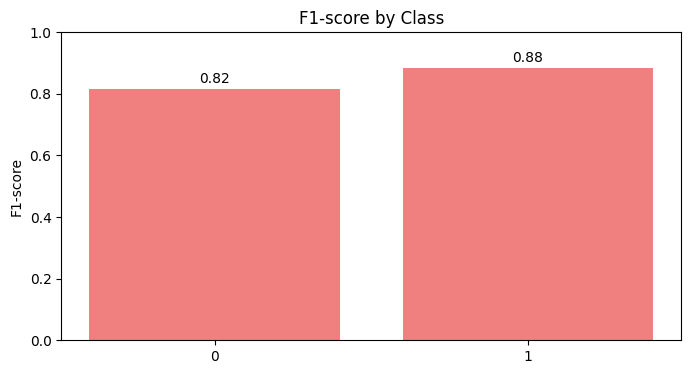

Scenario dataset_scenario_5_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 5_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with grid for dataset_scenario_5_S...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_5_S
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8641
  Precision: 0.8677
  Recall: 0.8641
  F1 Score: 0.8647

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


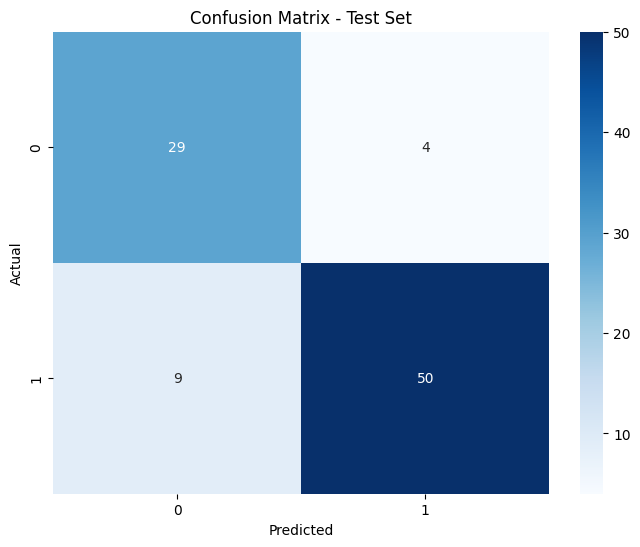

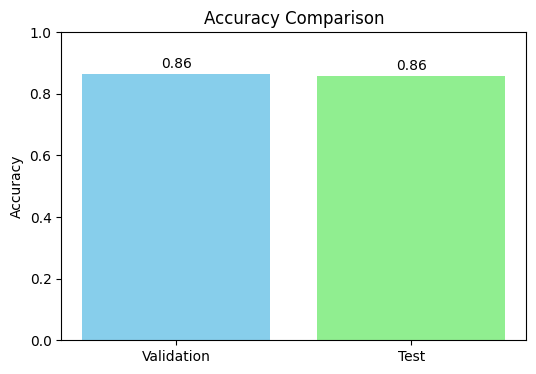

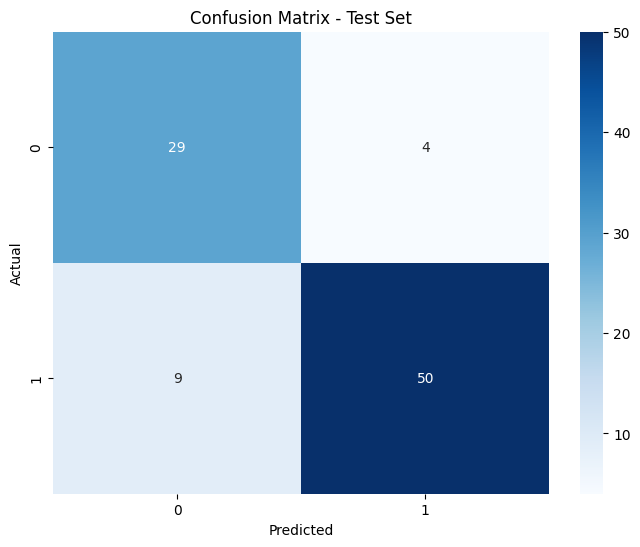

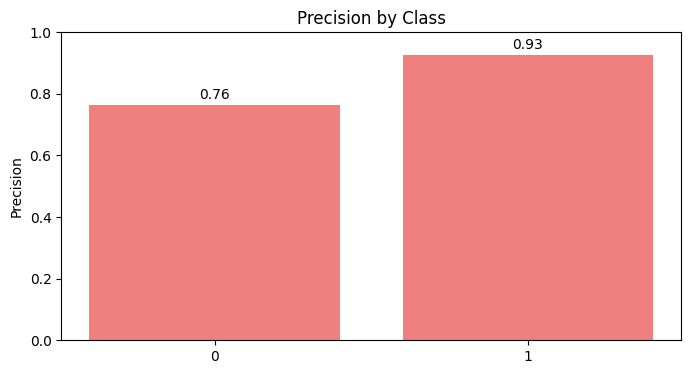

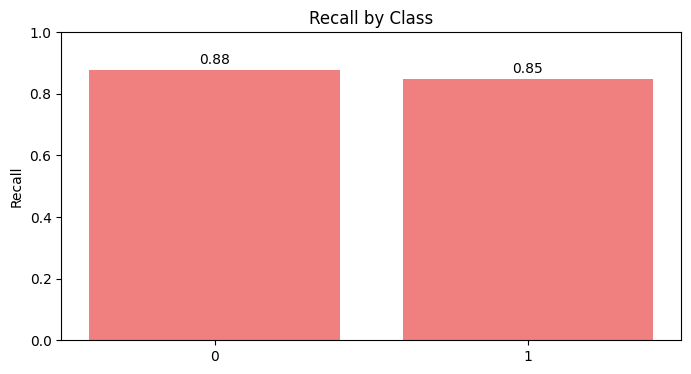

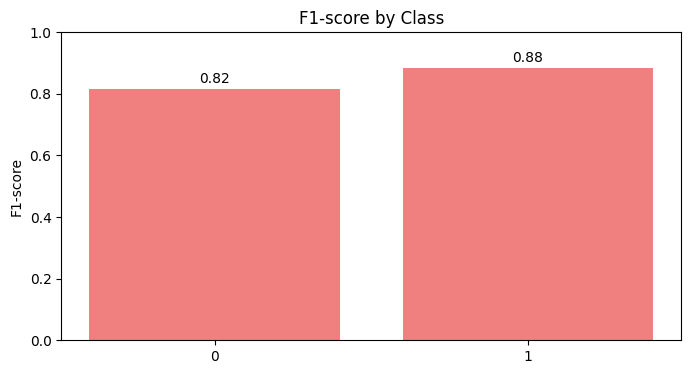

Scenario dataset_scenario_5_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 6_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running NaiveBayes with grid for dataset_scenario_6_N...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_6_N
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8632
  Recall: 0.8587
  F1 Score: 0.8593

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


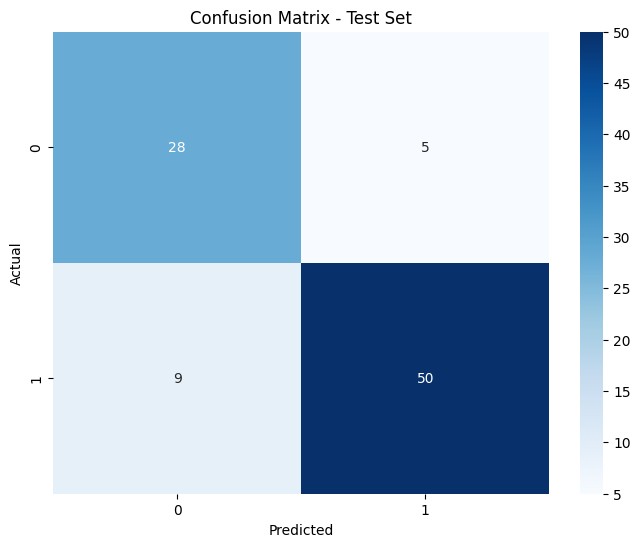

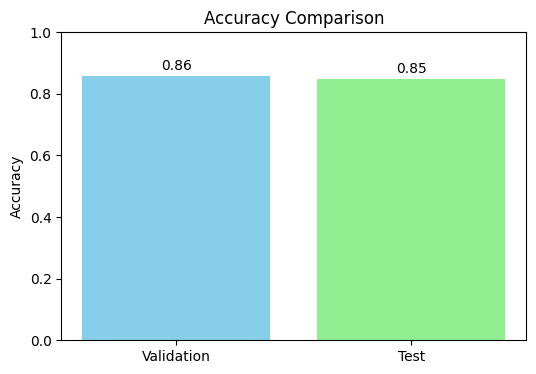

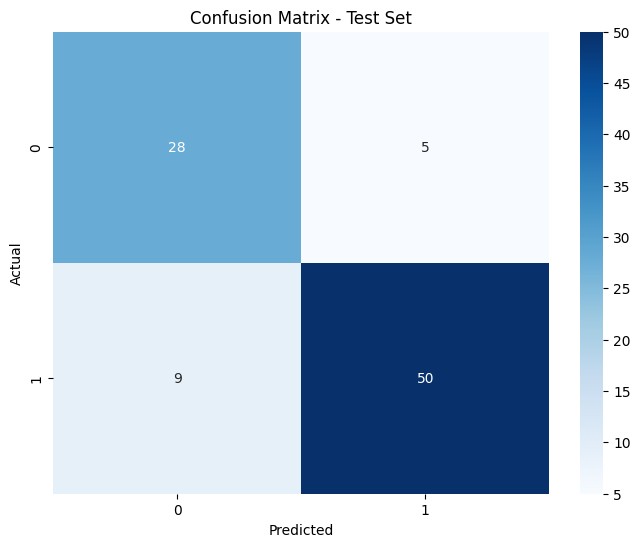

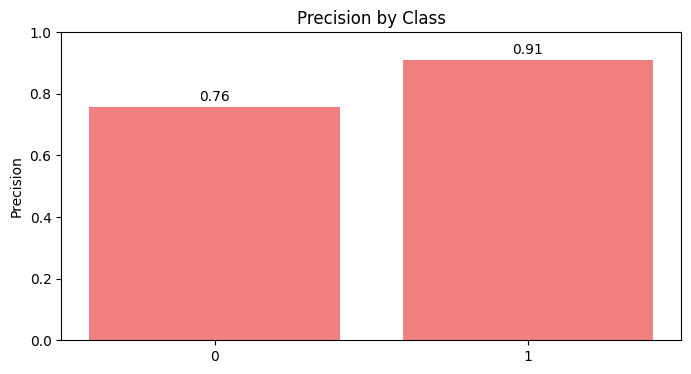

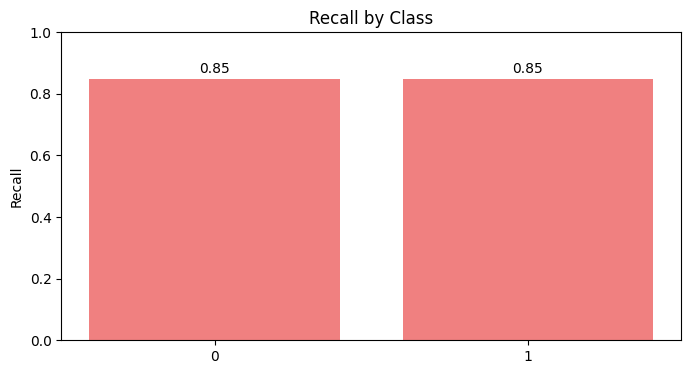

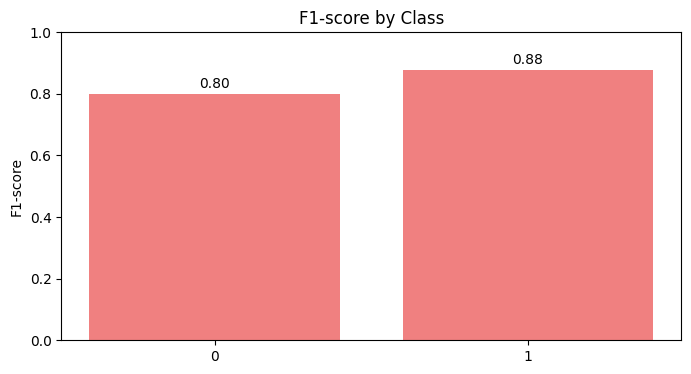

Scenario dataset_scenario_6_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 6_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with grid for dataset_scenario_6_S...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_6_S
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8632
  Recall: 0.8587
  F1 Score: 0.8593

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


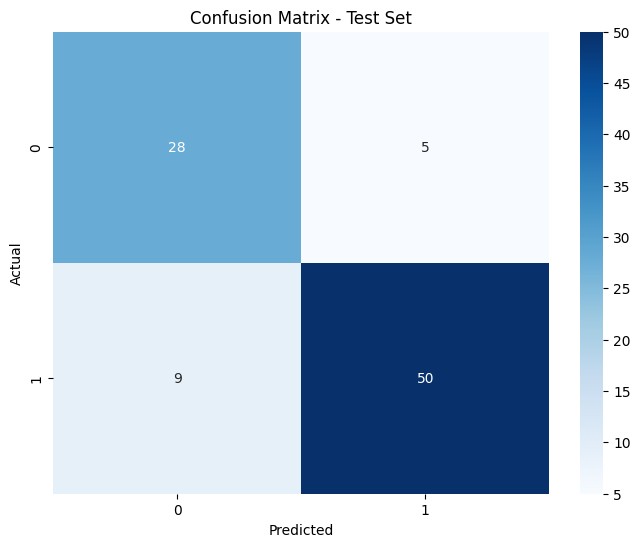

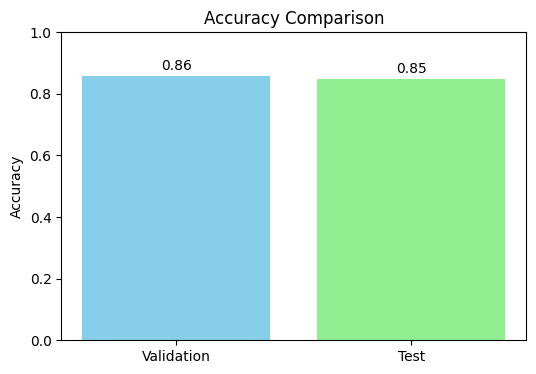

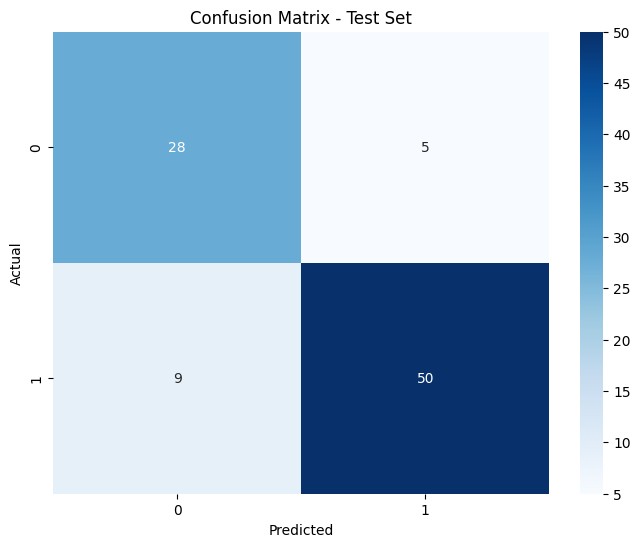

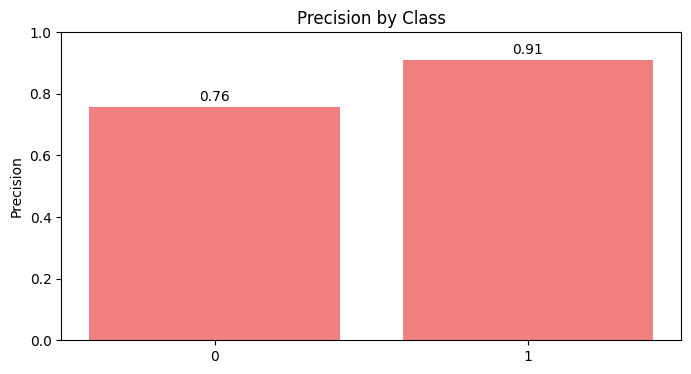

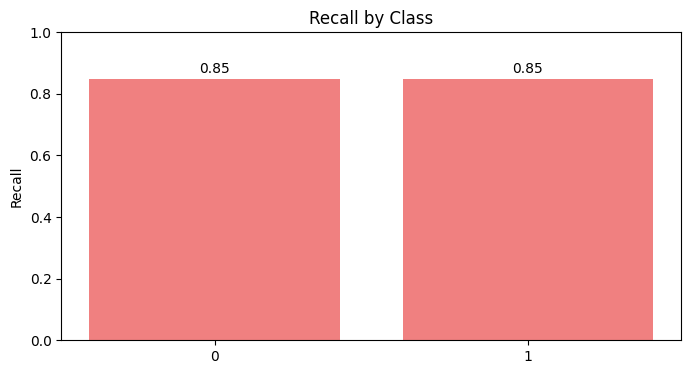

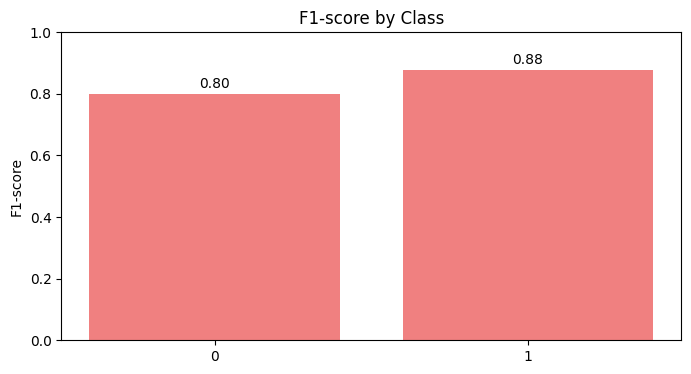

Scenario dataset_scenario_6_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 7_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with grid for dataset_scenario_7_N...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_7_N
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8500
  Precision: 0.8499
  Recall: 0.8500
  F1 Score: 0.8499

Test Metrics:
  Accuracy: 0.8169
  Precision: 0.8436
  Recall: 0.8169
  F1 Score: 0.8169

Confusion Matrix (Test Set):
[[29 11]
 [ 2 29]]


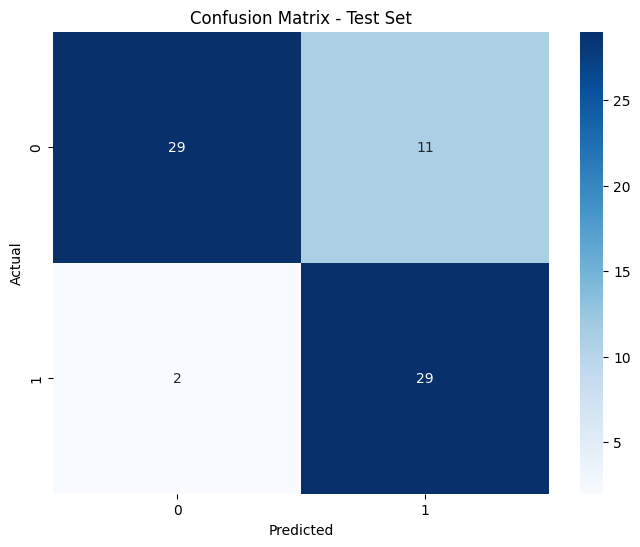

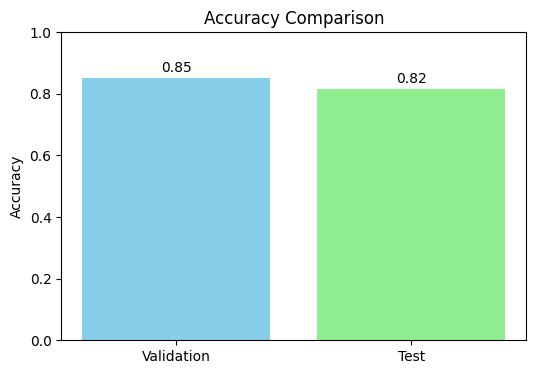

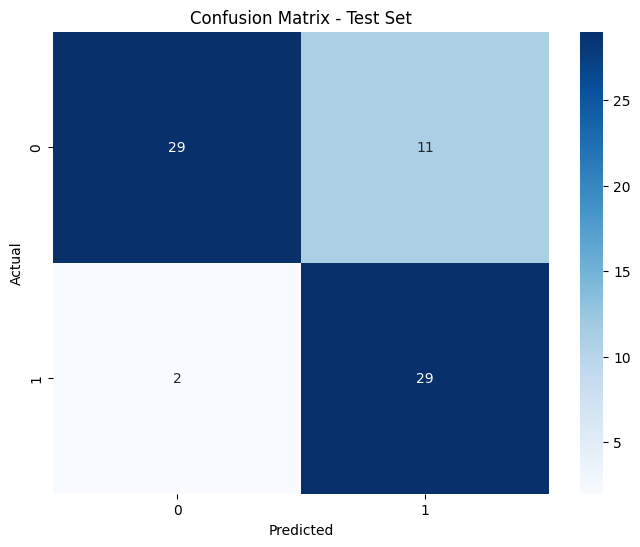

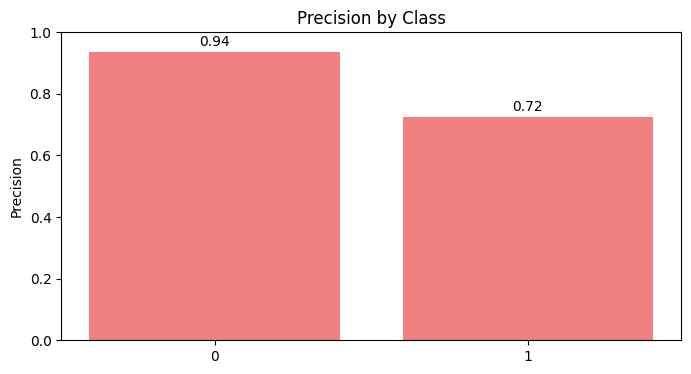

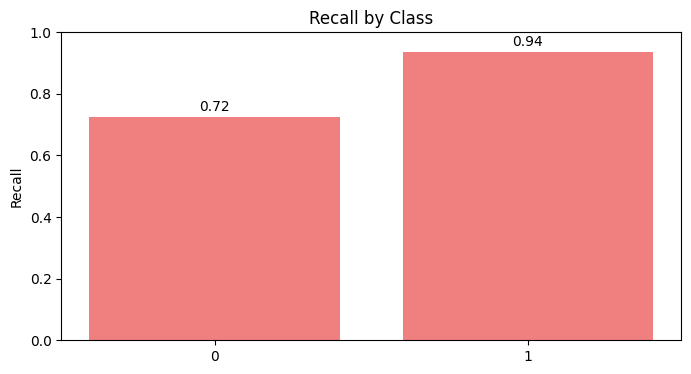

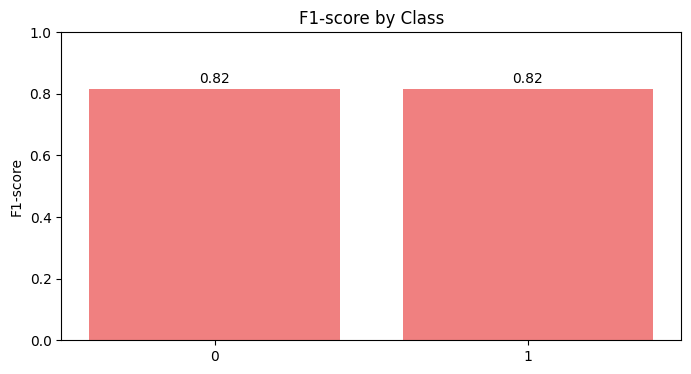

Scenario dataset_scenario_7_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 7_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with grid for dataset_scenario_7_S...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_7_S
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8500
  Precision: 0.8499
  Recall: 0.8500
  F1 Score: 0.8499

Test Metrics:
  Accuracy: 0.8169
  Precision: 0.8436
  Recall: 0.8169
  F1 Score: 0.8169

Confusion Matrix (Test Set):
[[29 11]
 [ 2 29]]


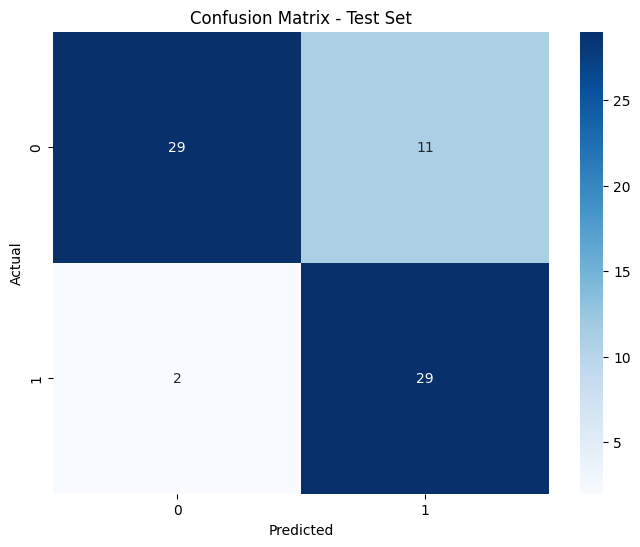

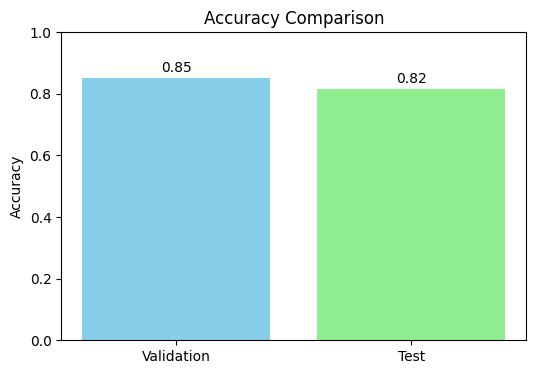

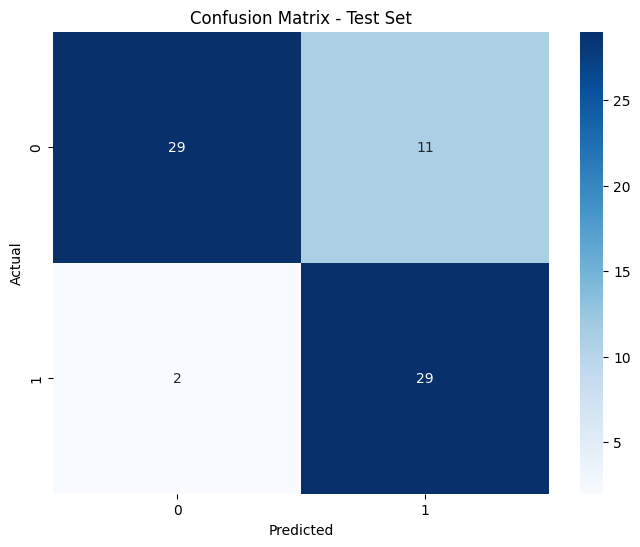

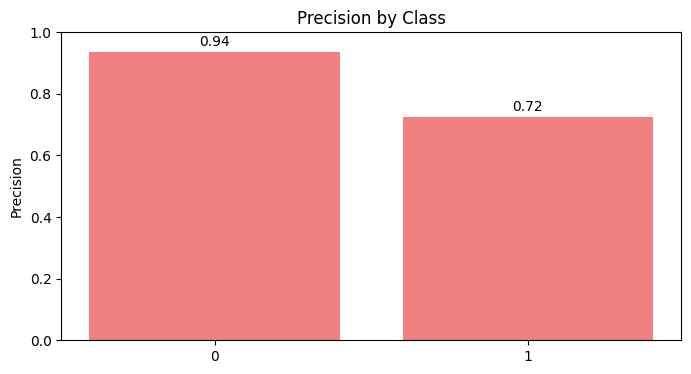

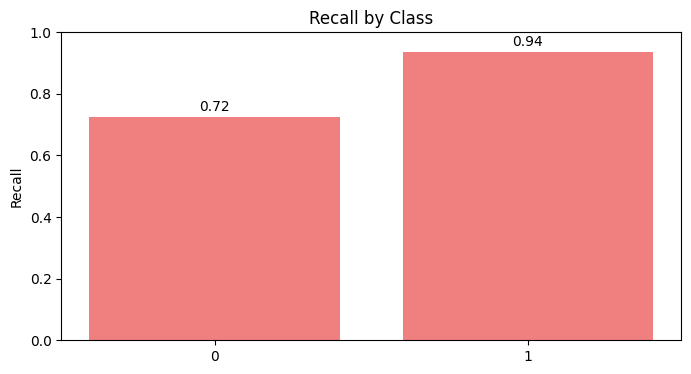

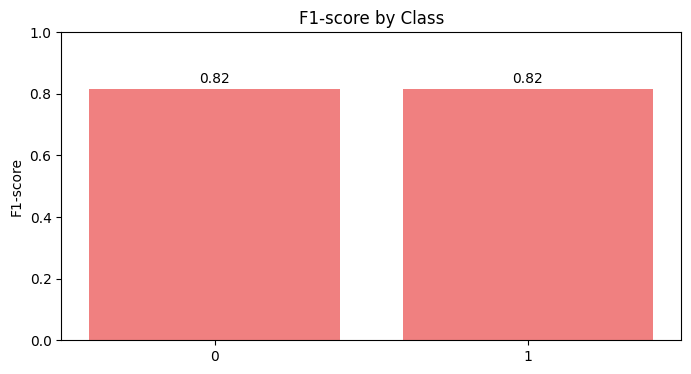

Scenario dataset_scenario_7_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 8_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running NaiveBayes with grid for dataset_scenario_8_N...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_8_N
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8615
  Recall: 0.8587
  F1 Score: 0.8592

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


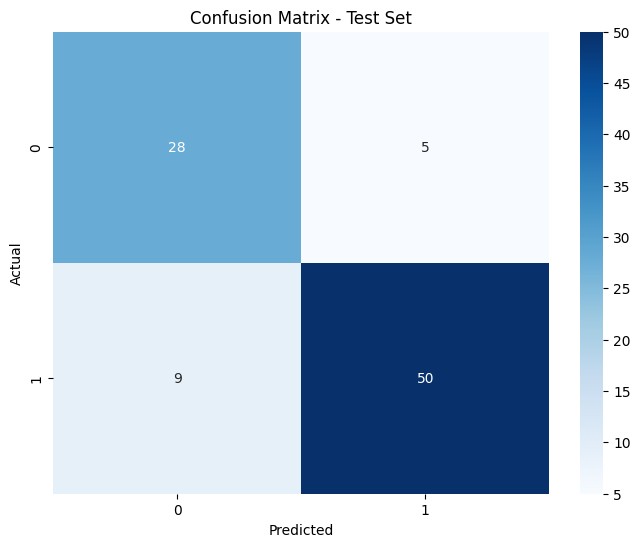

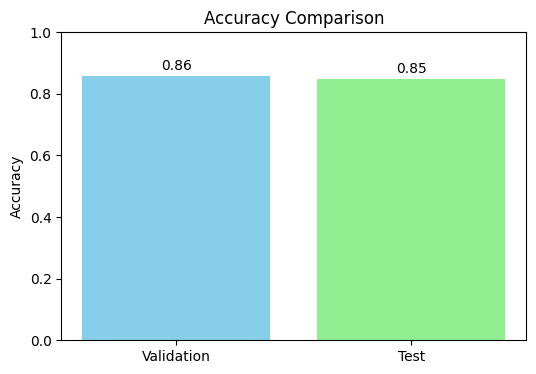

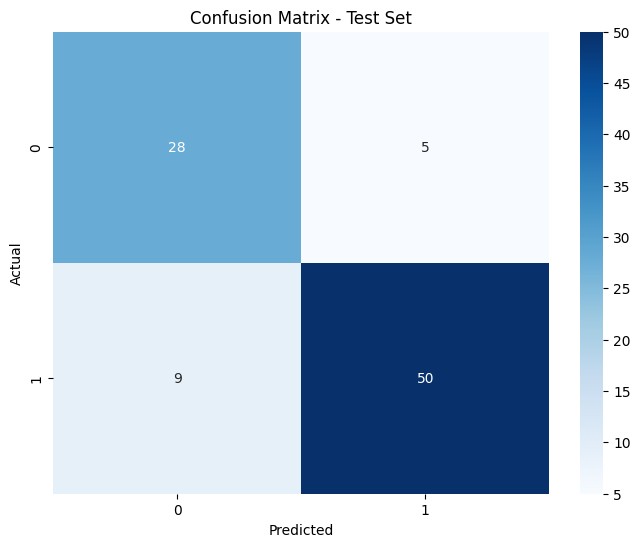

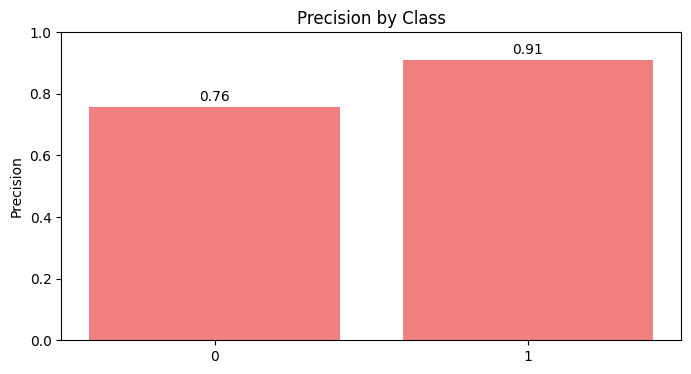

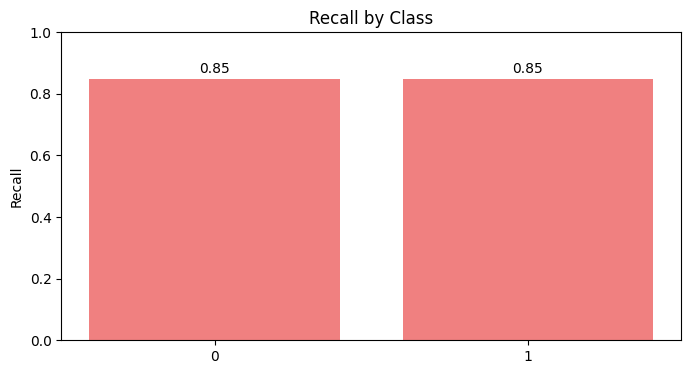

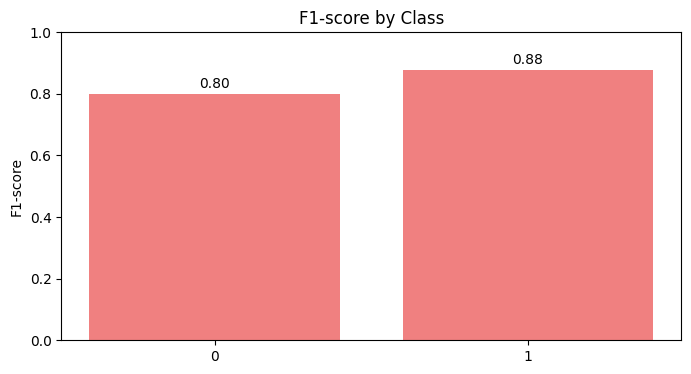

Scenario dataset_scenario_8_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 8_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with grid for dataset_scenario_8_S...
Results will be saved in: SCORES\NaiveBayes\grid\dataset_scenario_8_S
Best hyperparameters:  {'priors': None, 'var_smoothing': 1e-09}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8615
  Recall: 0.8587
  F1 Score: 0.8592

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


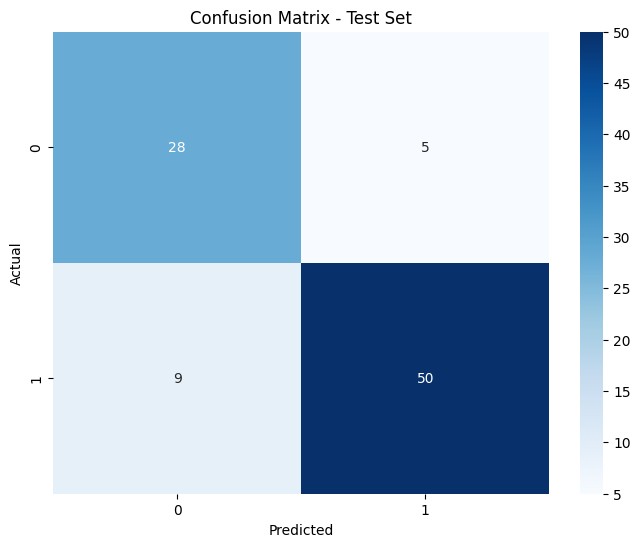

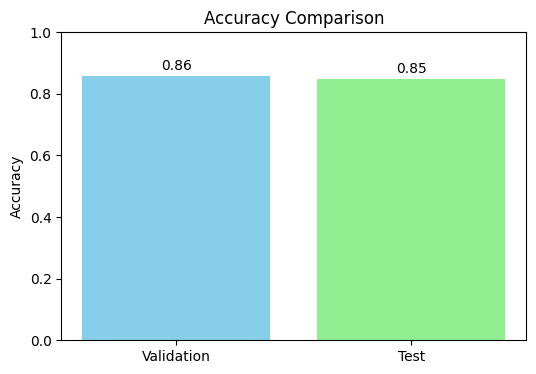

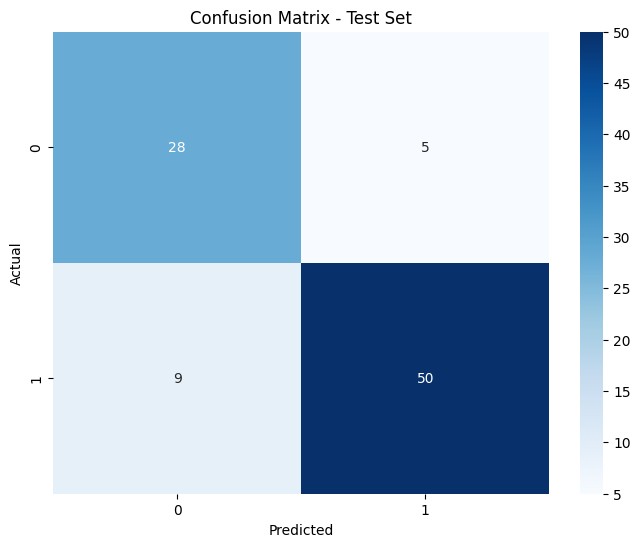

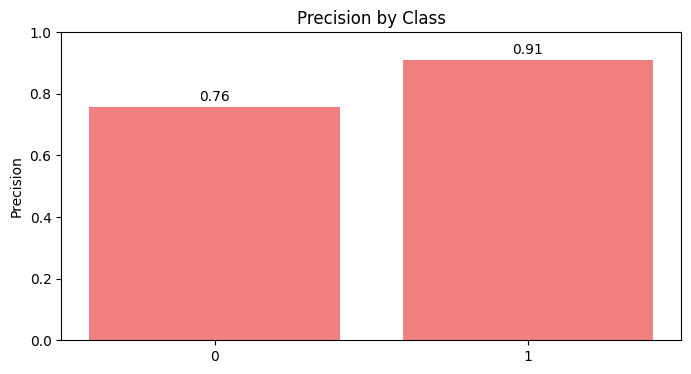

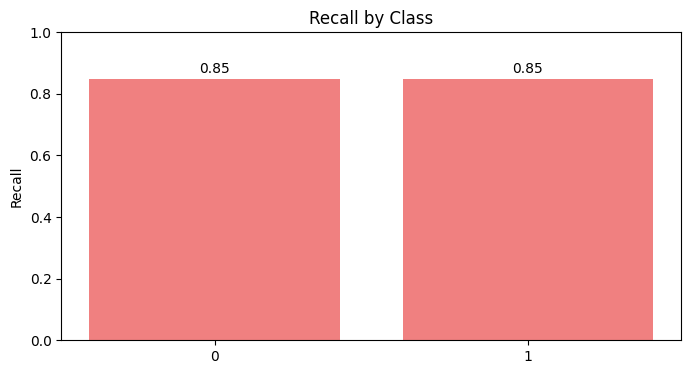

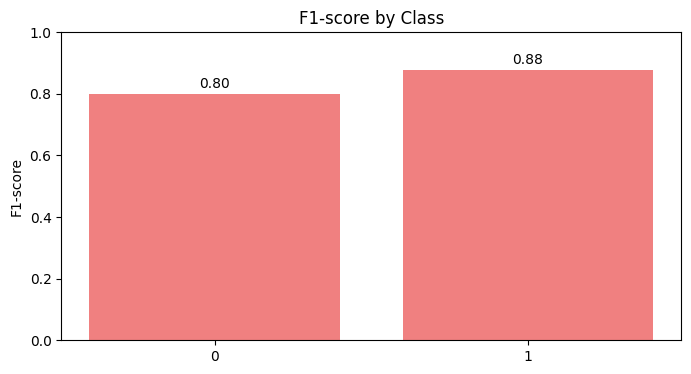

Scenario dataset_scenario_8_S with grid completed and results saved.

----------------------------------------





In [9]:
for scenario, scenario_description in zip(scenario_datasets, scenarios_description):
    print(f"Scenario Name: {scenario_description['name']}")
    print(f"  Encoding: {scenario_description['encoding']}")
    print(f"  Remove Outliers: {scenario_description['remove_outliers']}")
    print(f"  Remove Errors: {scenario_description.get('remove_errors', 'Not Specified')}")
    print(f"  Impute Zeros: {scenario_description.get('impute_zeros', 'None')}")
    print(f"  Oldpeak Absolute: {scenario_description.get('oldpeak_abs', 'Not Specified')}")
    print(f"  Scaling: {scenario_description['scaling']}")

    # Run for Naive Bayes
    run_scenario(scenario, "NaiveBayes", "grid", search_config_grid, get_search_hyperparameters("NaiveBayes"))
    
    print("-" * 40)
    print("\n\n")

## 2. Random Search

Scenario Name: Scenario 1_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with random for dataset_scenario_1_N...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_1_N
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8804
  Precision: 0.8810
  Recall: 0.8804
  F1 Score: 0.8806

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


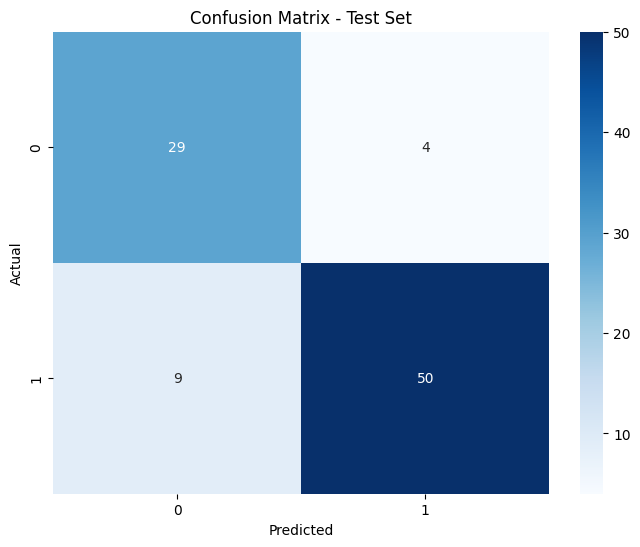

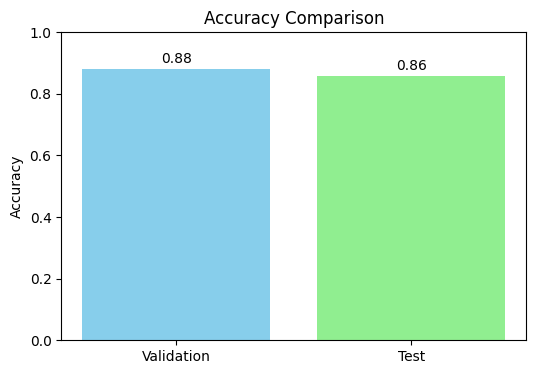

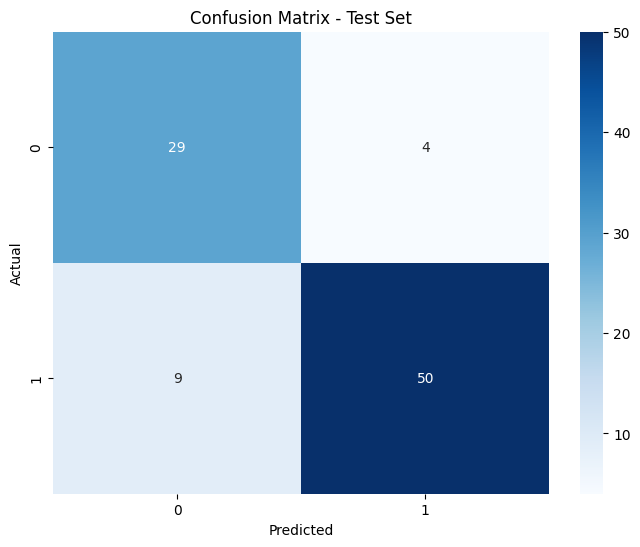

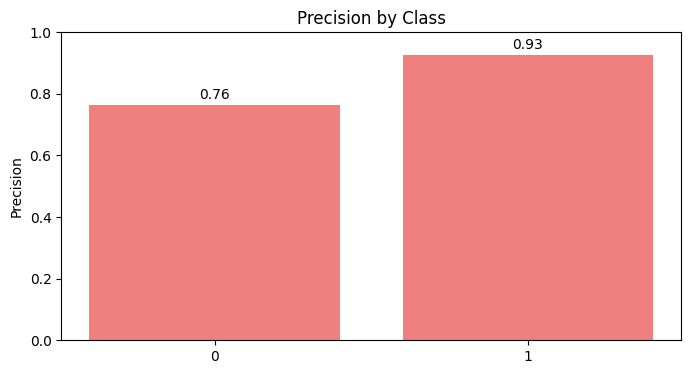

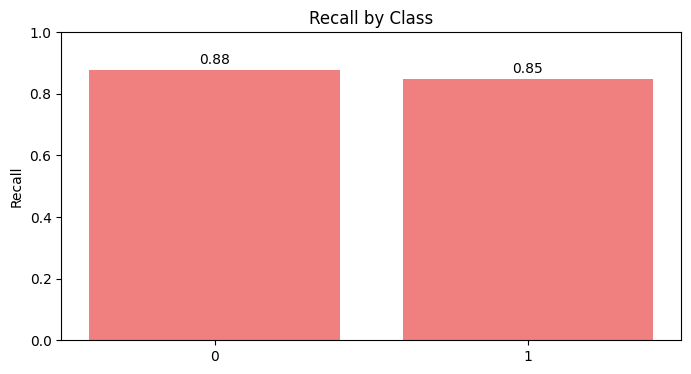

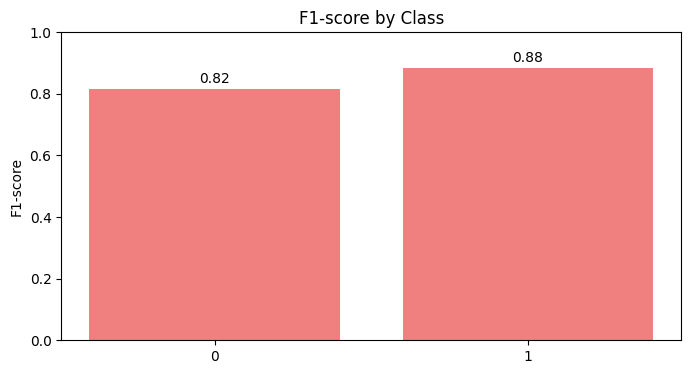

Scenario dataset_scenario_1_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 1_S
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with random for dataset_scenario_1_S...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_1_S
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8804
  Precision: 0.8810
  Recall: 0.8804
  F1 Score: 0.8806

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


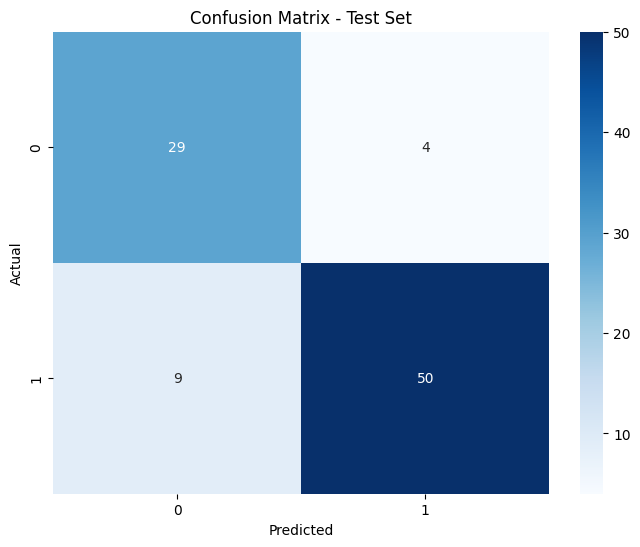

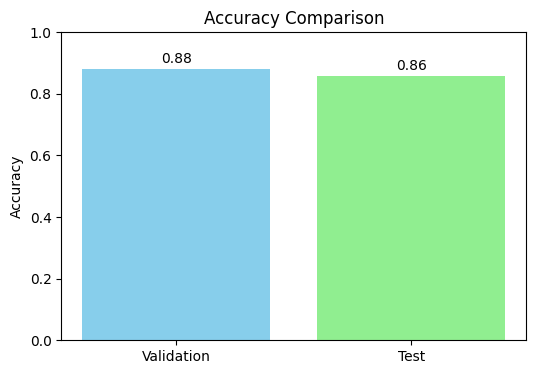

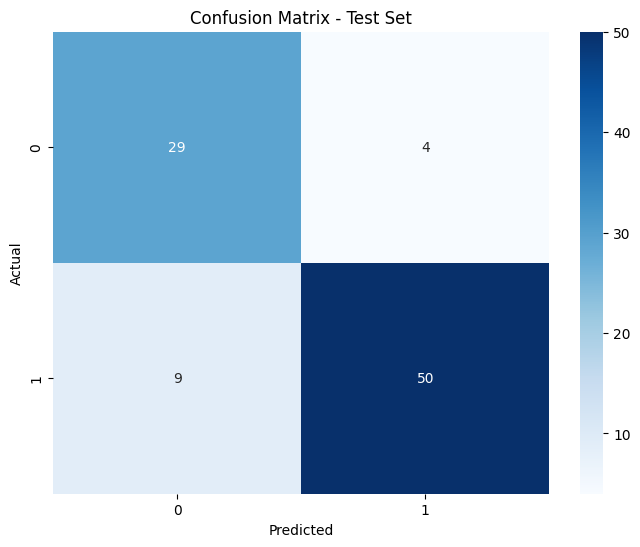

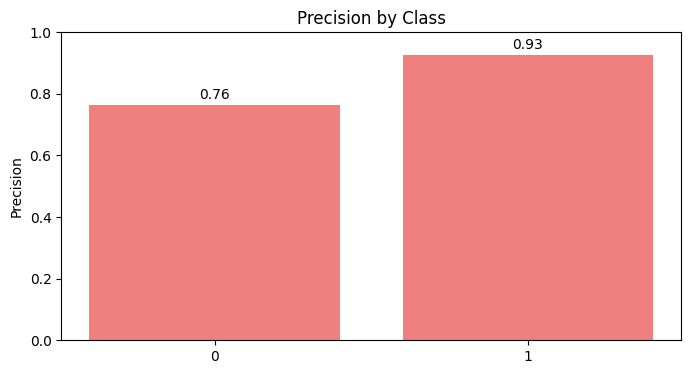

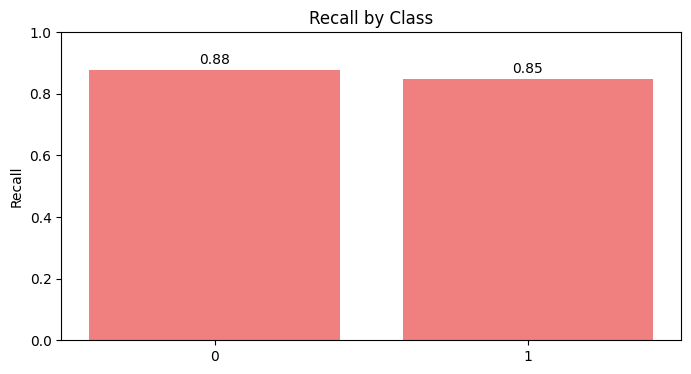

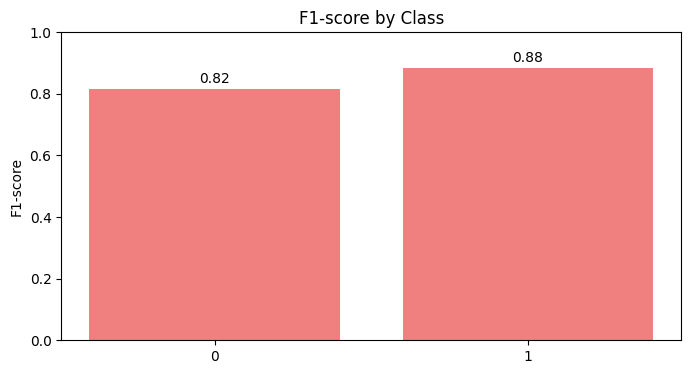

Scenario dataset_scenario_1_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 2_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: {'RestingBP': 'mean', 'Cholesterol': 'mean'}
  Oldpeak Absolute: True
  Scaling: MinMax
Running NaiveBayes with random for dataset_scenario_2_N...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_2_N
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8478
  Precision: 0.8523
  Recall: 0.8478
  F1 Score: 0.8485

Test Metrics:
  Accuracy: 0.8261
  Precision: 0.8447
  Recall: 0.8261
  F1 Score: 0.8292

Confusion Matrix (Test Set):
[[29  4]
 [12 47]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


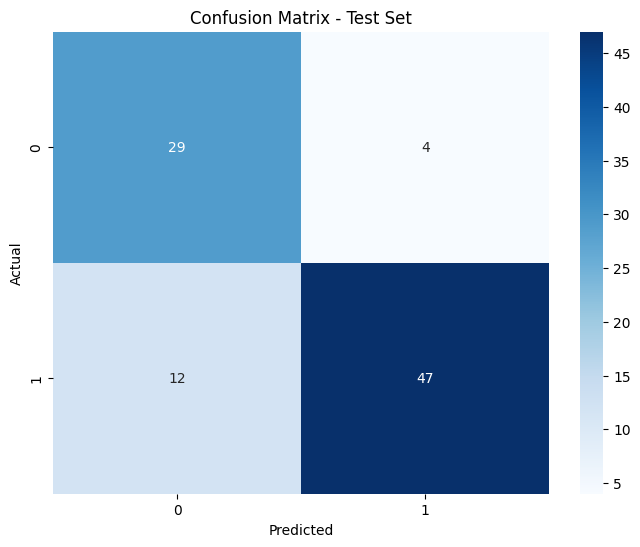

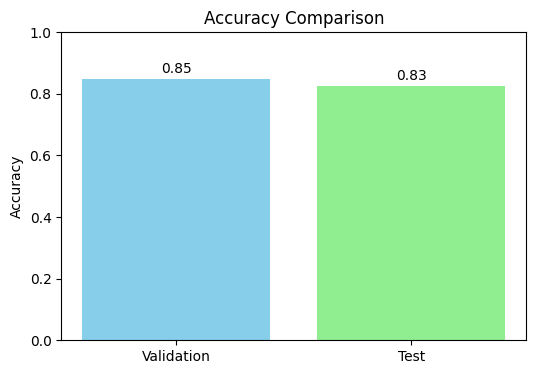

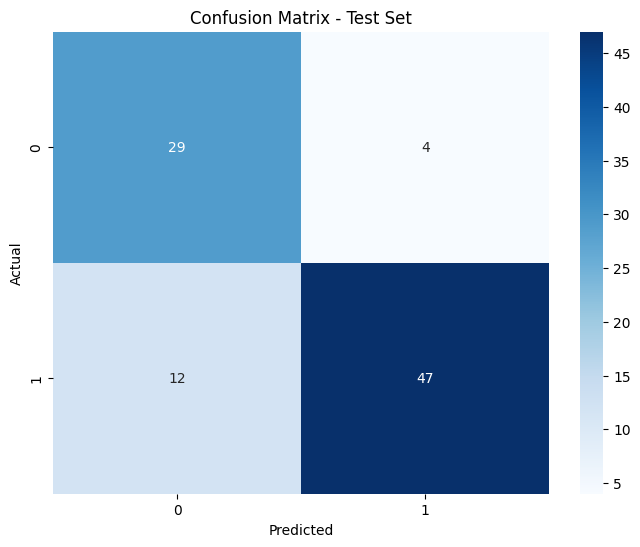

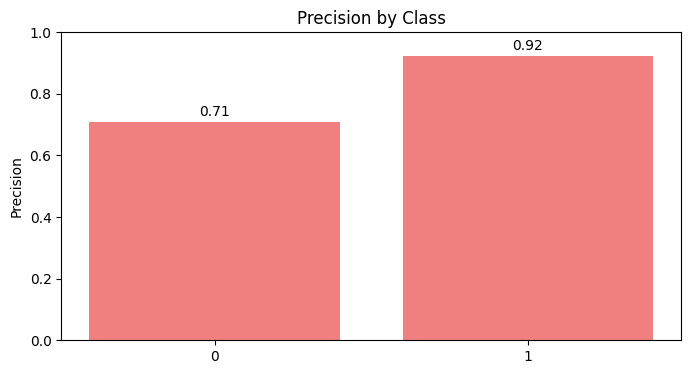

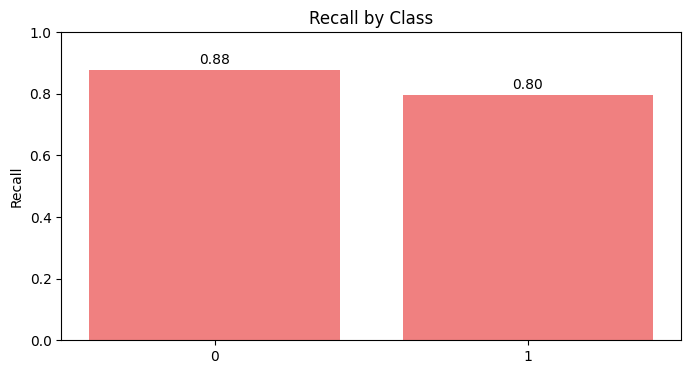

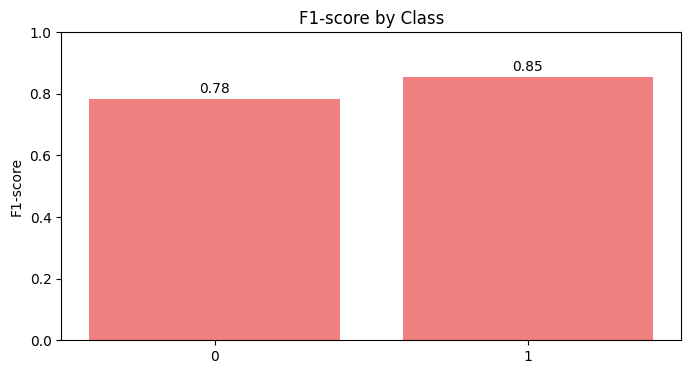

Scenario dataset_scenario_2_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 2_S
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: {'RestingBP': 'mean', 'Cholesterol': 'mean'}
  Oldpeak Absolute: True
  Scaling: Standard
Running NaiveBayes with random for dataset_scenario_2_S...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_2_S
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8478
  Precision: 0.8523
  Recall: 0.8478
  F1 Score: 0.8485

Test Metrics:
  Accuracy: 0.8261
  Precision: 0.8447
  Recall: 0.8261
  F1 Score: 0.8292

Confusion Matrix (Test Set):
[[29  4]
 [12 47]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


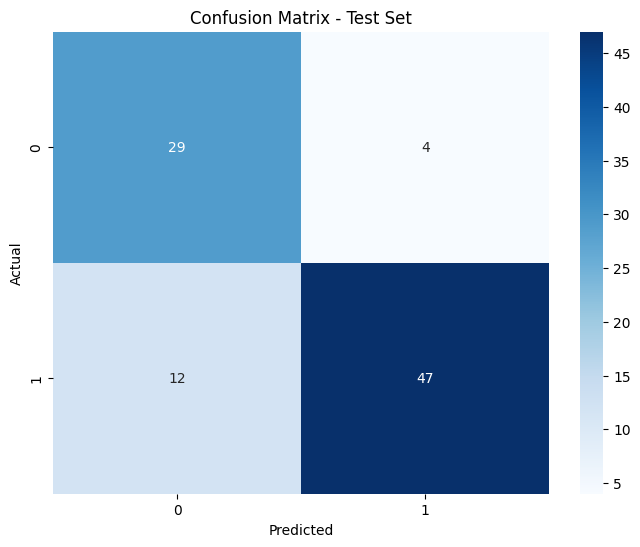

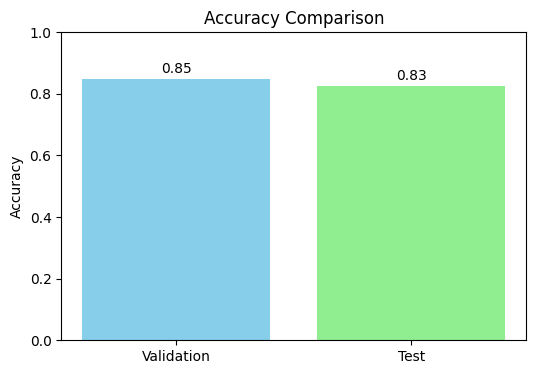

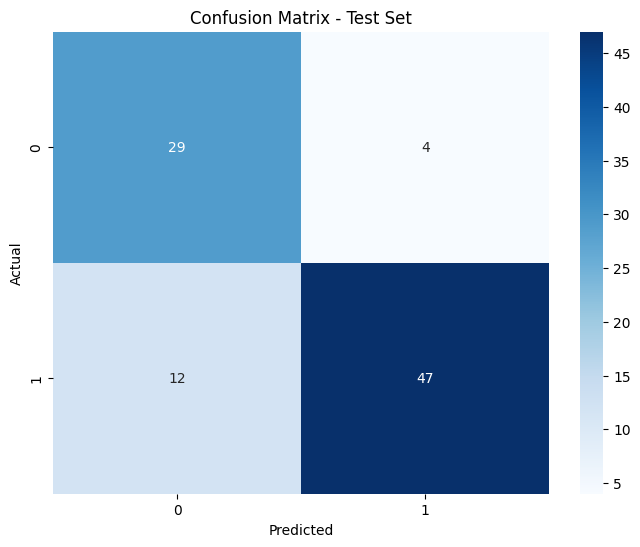

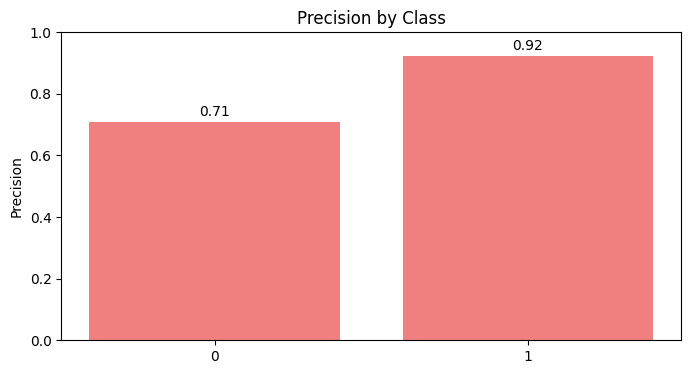

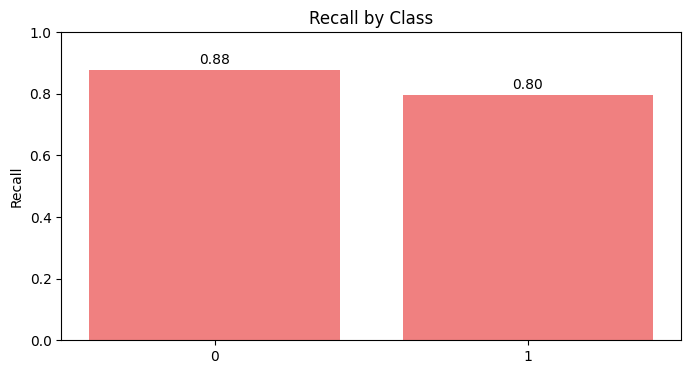

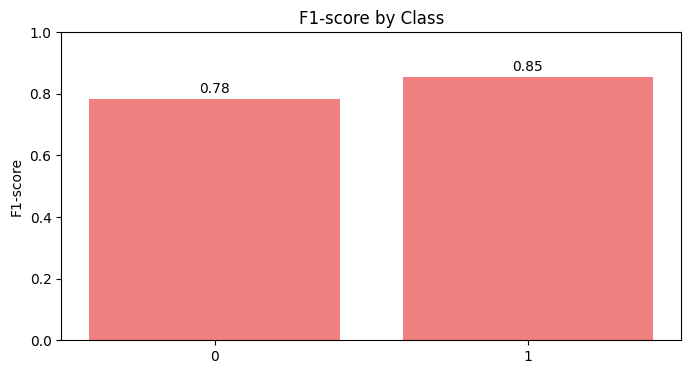

Scenario dataset_scenario_2_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 3_N
  Encoding: Label encoding
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running NaiveBayes with random for dataset_scenario_3_N...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_3_N
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8429
  Precision: 0.8427
  Recall: 0.8429
  F1 Score: 0.8426

Test Metrics:
  Accuracy: 0.7887
  Precision: 0.7982
  Recall: 0.7887
  F1 Score: 0.7896

Confusion Matrix (Test Set):
[[30 10]
 [ 5 26]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


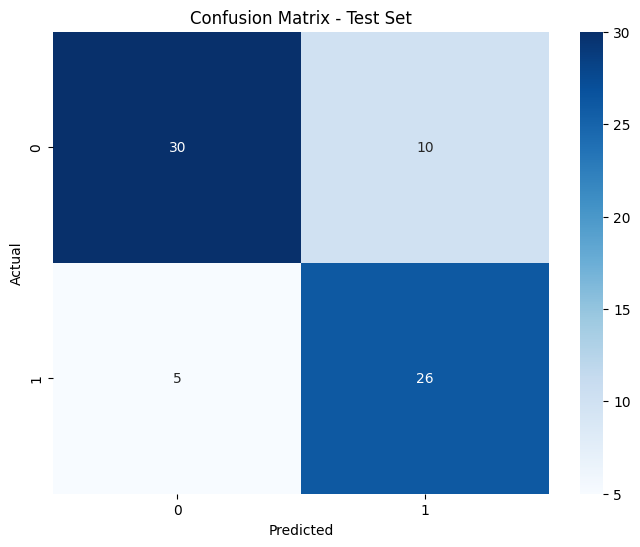

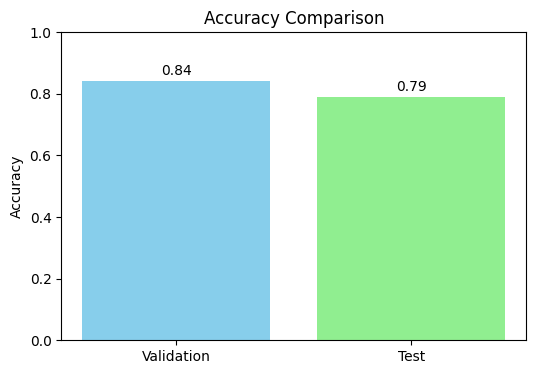

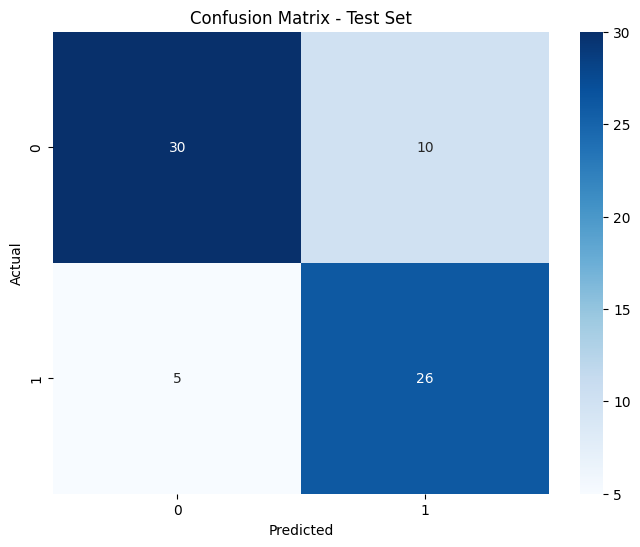

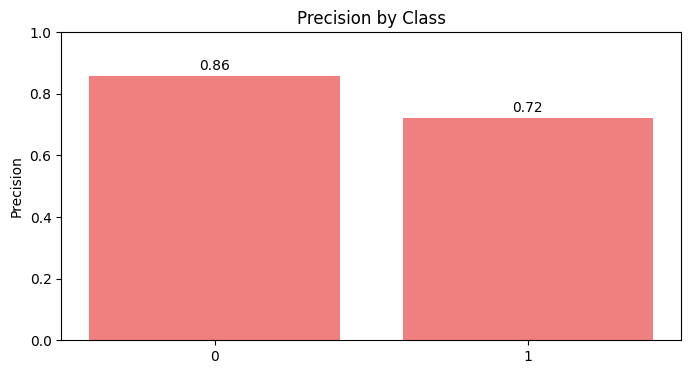

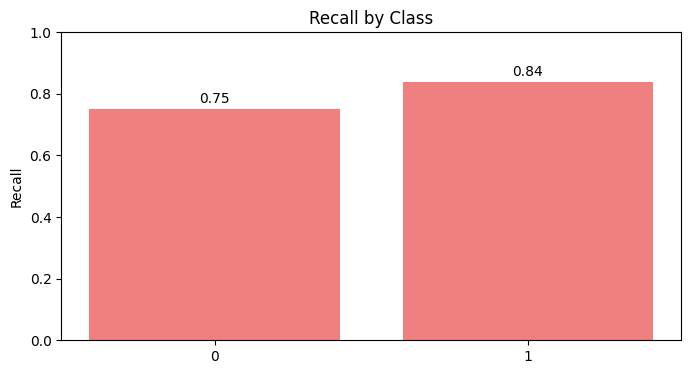

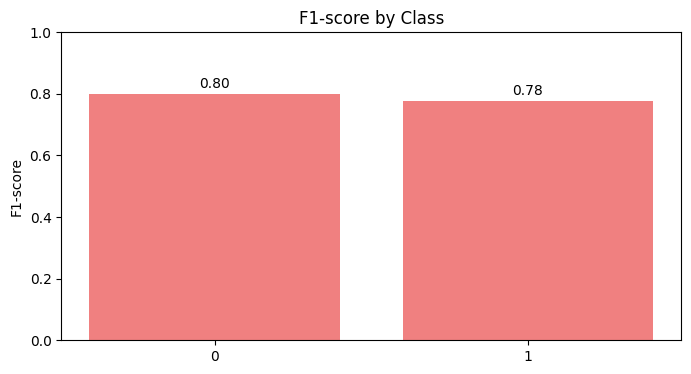

Scenario dataset_scenario_3_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 3_S
  Encoding: Label encoding
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with random for dataset_scenario_3_S...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_3_S
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8429
  Precision: 0.8427
  Recall: 0.8429
  F1 Score: 0.8426

Test Metrics:
  Accuracy: 0.7887
  Precision: 0.7982
  Recall: 0.7887
  F1 Score: 0.7896

Confusion Matrix (Test Set):
[[30 10]
 [ 5 26]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


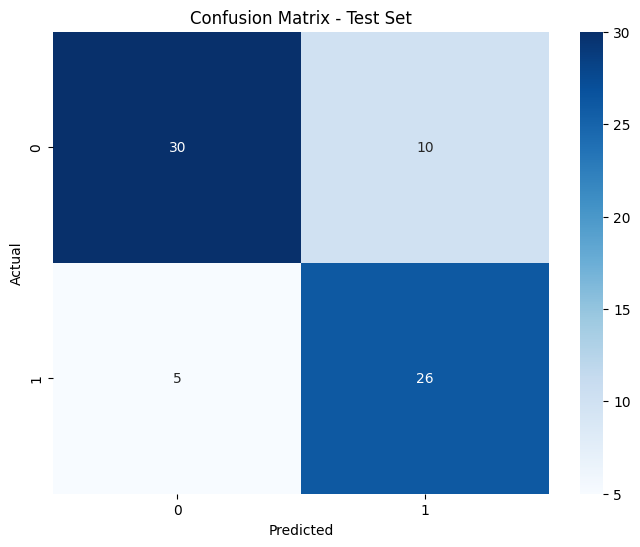

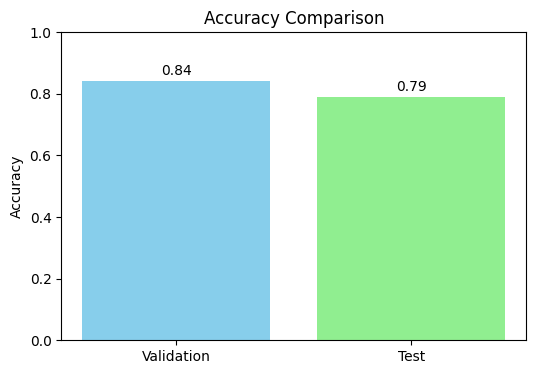

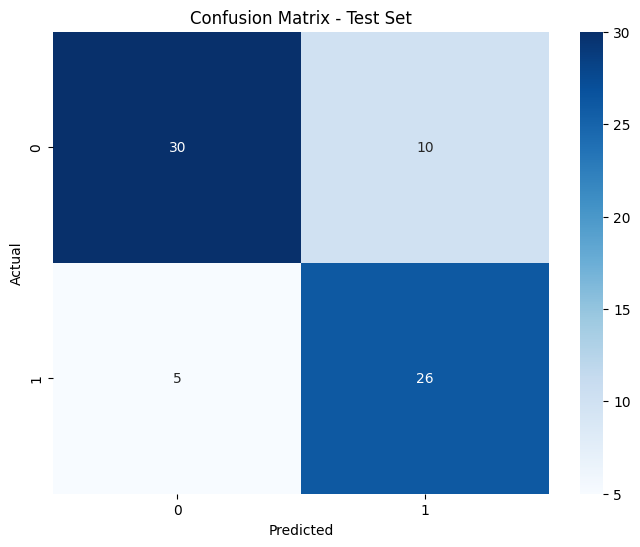

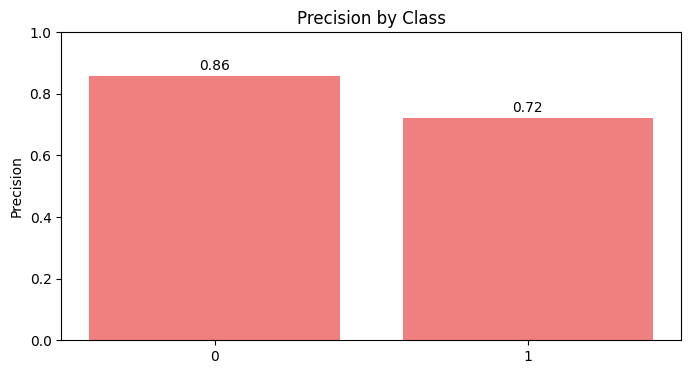

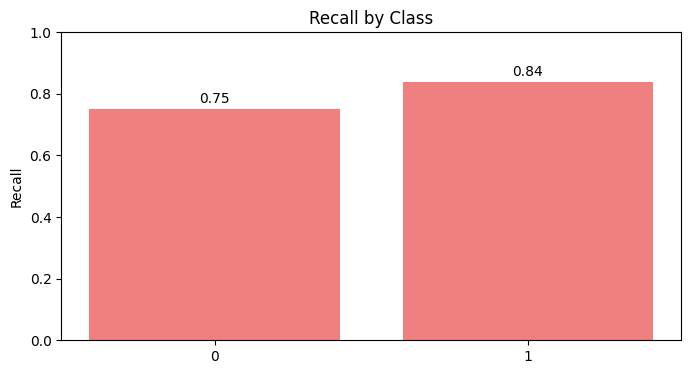

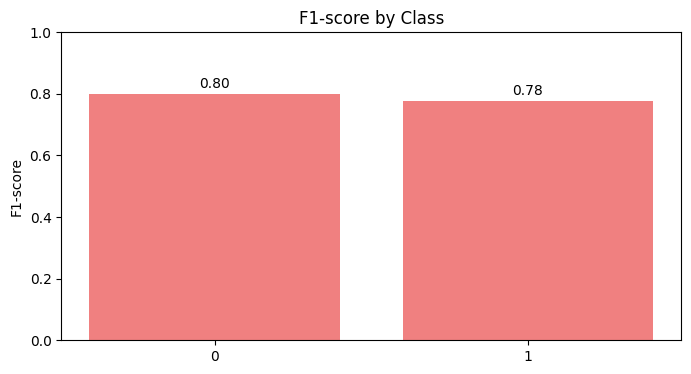

Scenario dataset_scenario_3_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 4_N
  Encoding: Label encoding
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with random for dataset_scenario_4_N...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_4_N
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8370
  Precision: 0.8434
  Recall: 0.8370
  F1 Score: 0.8377

Test Metrics:
  Accuracy: 0.8152
  Precision: 0.8377
  Recall: 0.8152
  F1 Score: 0.8187

Confusion Matrix (Test Set):
[[29  4]
 [13 46]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


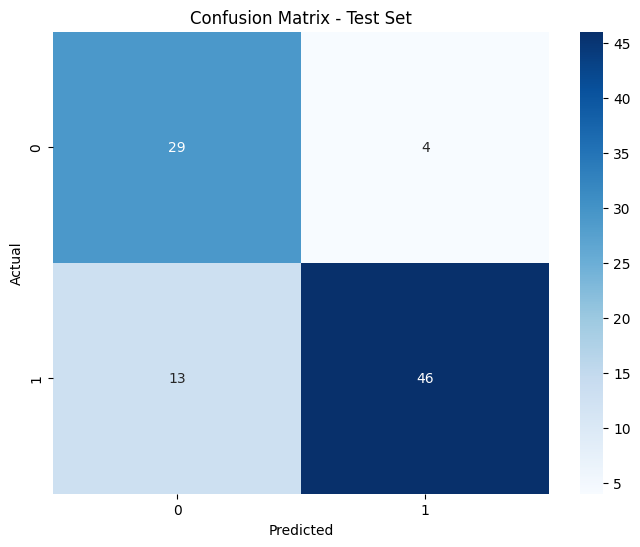

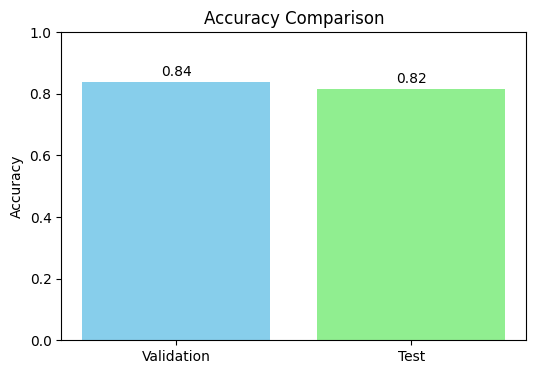

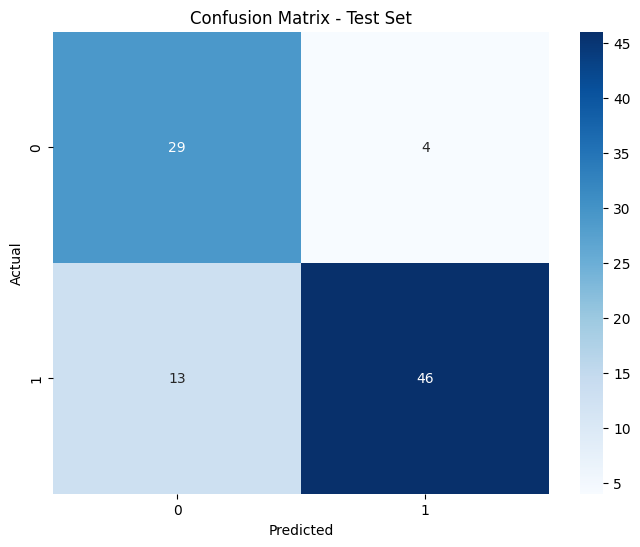

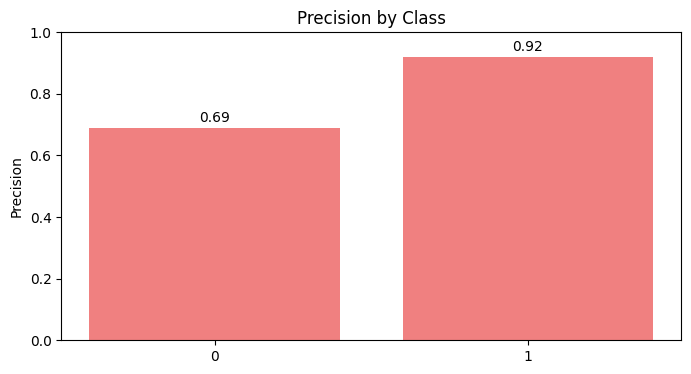

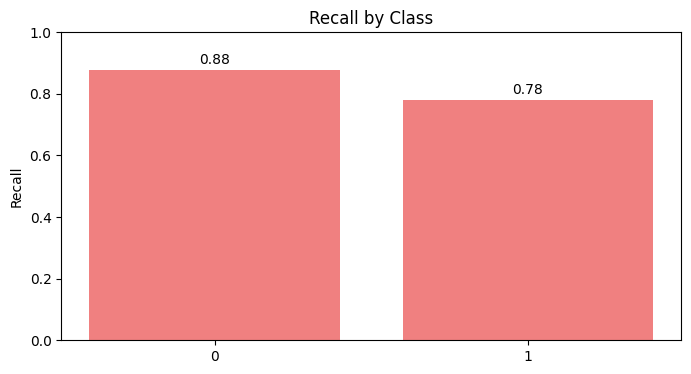

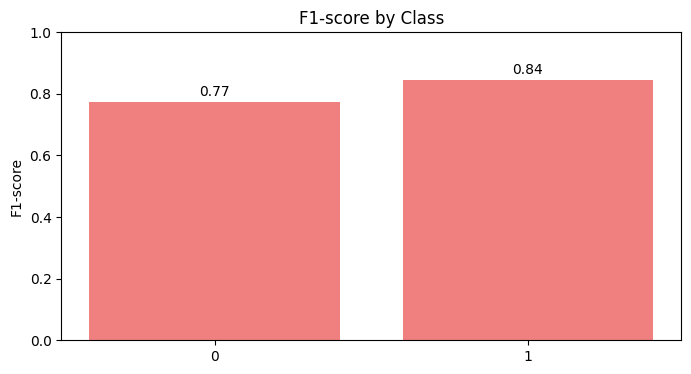

Scenario dataset_scenario_4_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 4_S
  Encoding: Label encoding
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with random for dataset_scenario_4_S...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_4_S
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8370
  Precision: 0.8434
  Recall: 0.8370
  F1 Score: 0.8377

Test Metrics:
  Accuracy: 0.8152
  Precision: 0.8377
  Recall: 0.8152
  F1 Score: 0.8187

Confusion Matrix (Test Set):
[[29  4]
 [13 46]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


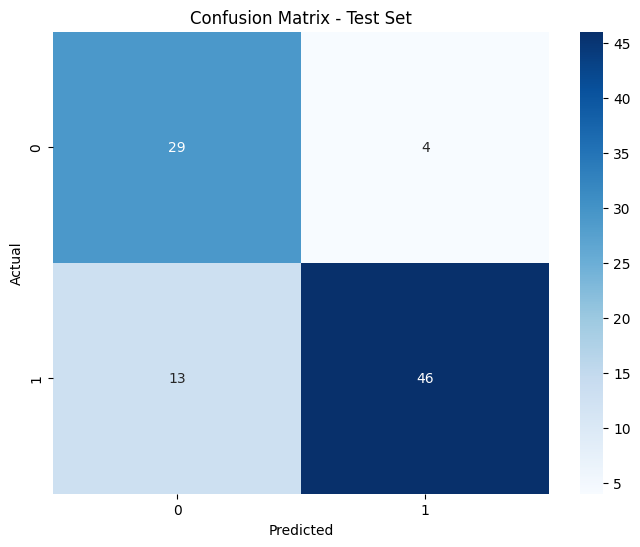

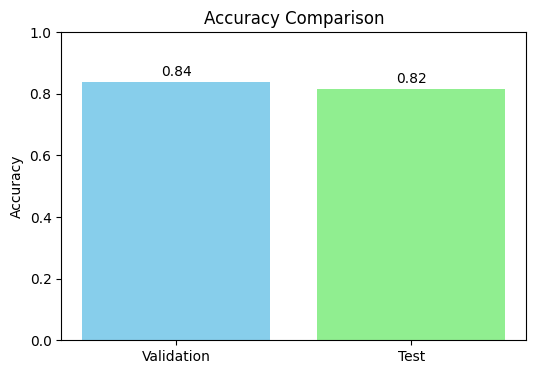

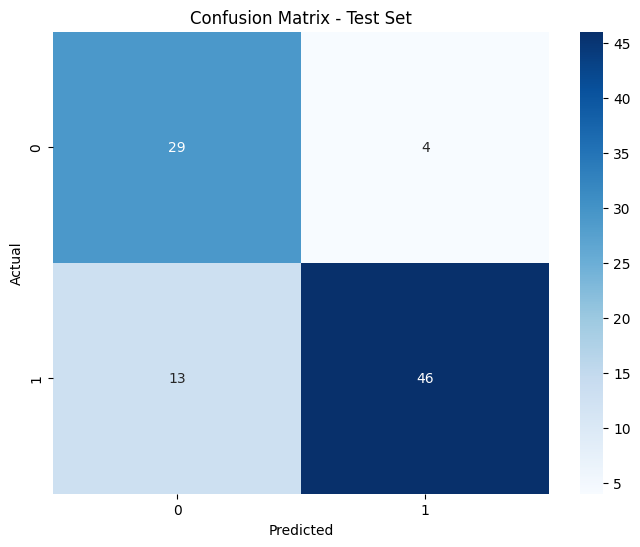

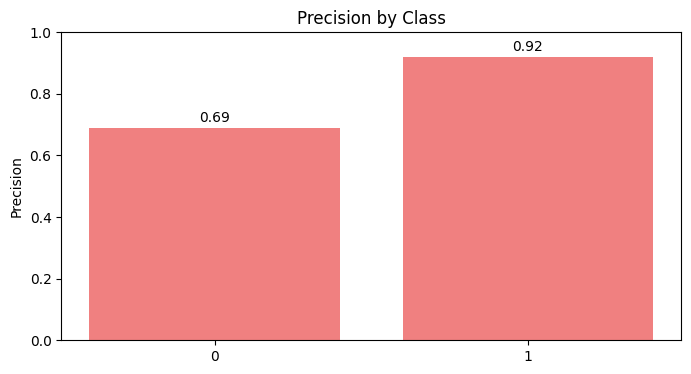

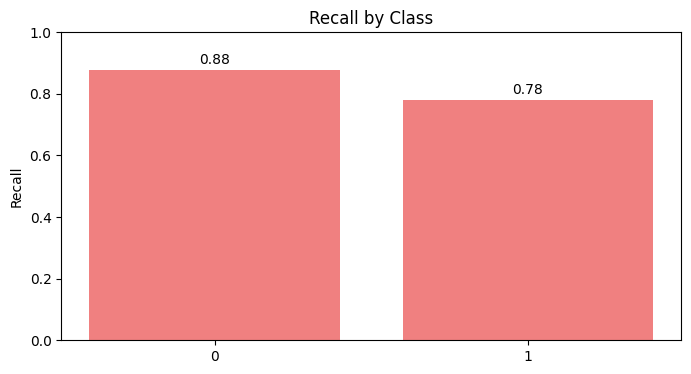

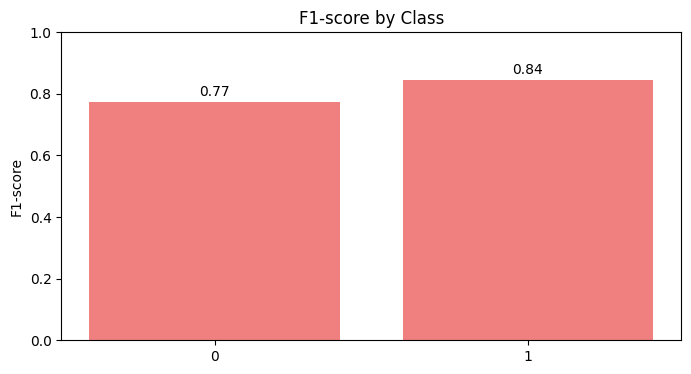

Scenario dataset_scenario_4_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 5_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with random for dataset_scenario_5_N...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_5_N
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8641
  Precision: 0.8677
  Recall: 0.8641
  F1 Score: 0.8647

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


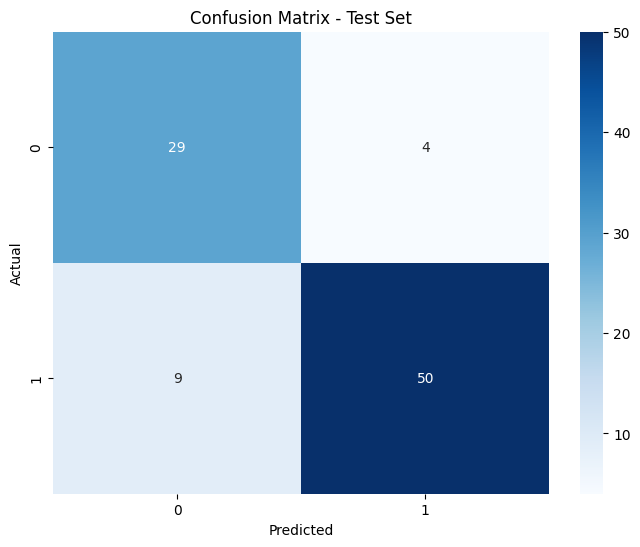

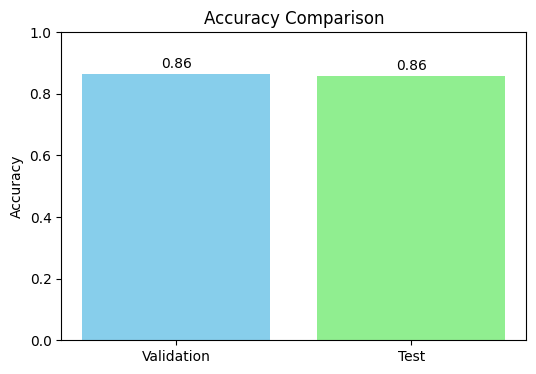

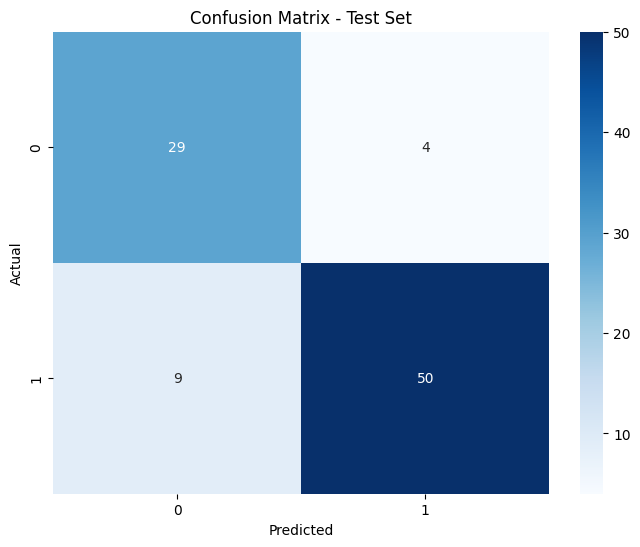

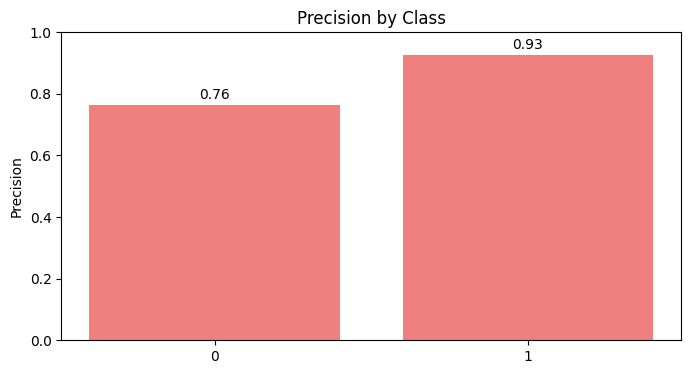

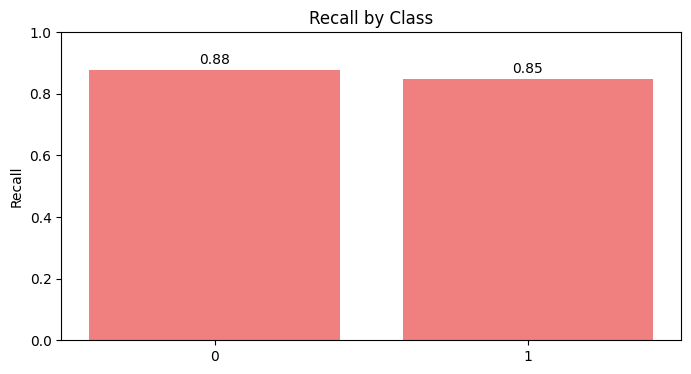

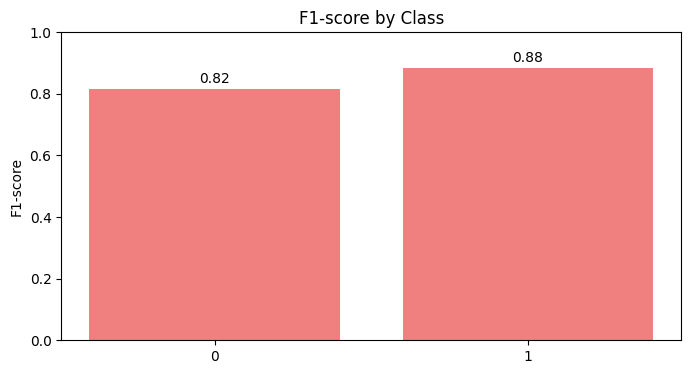

Scenario dataset_scenario_5_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 5_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with random for dataset_scenario_5_S...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_5_S
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8641
  Precision: 0.8677
  Recall: 0.8641
  F1 Score: 0.8647

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


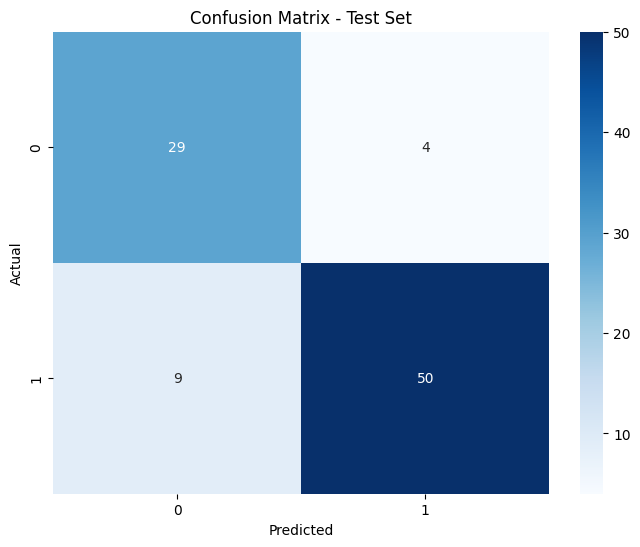

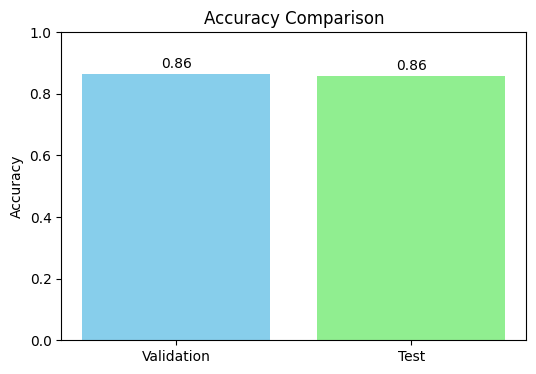

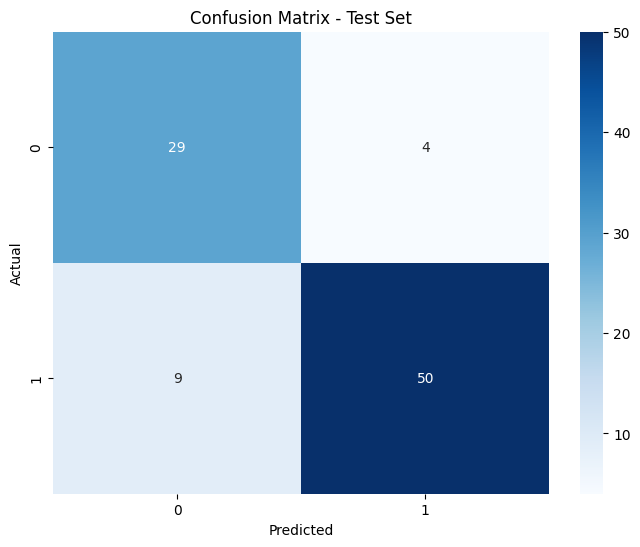

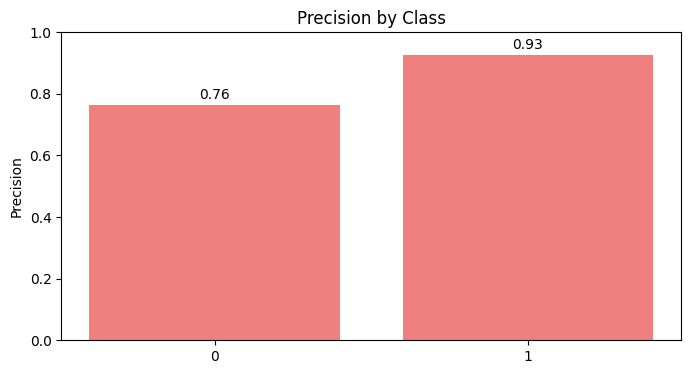

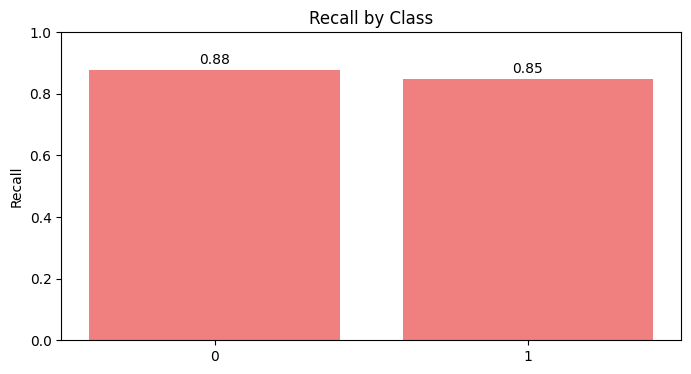

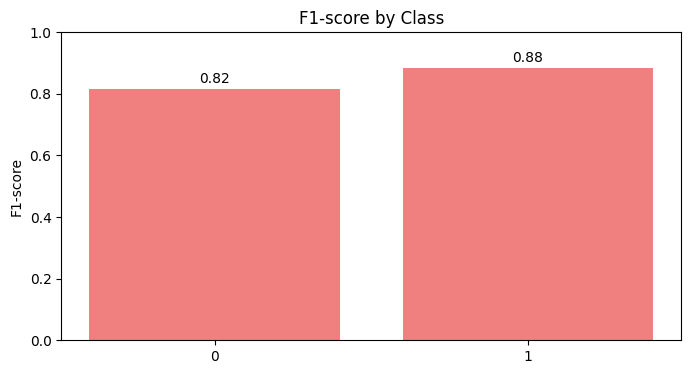

Scenario dataset_scenario_5_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 6_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running NaiveBayes with random for dataset_scenario_6_N...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_6_N
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8632
  Recall: 0.8587
  F1 Score: 0.8593

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


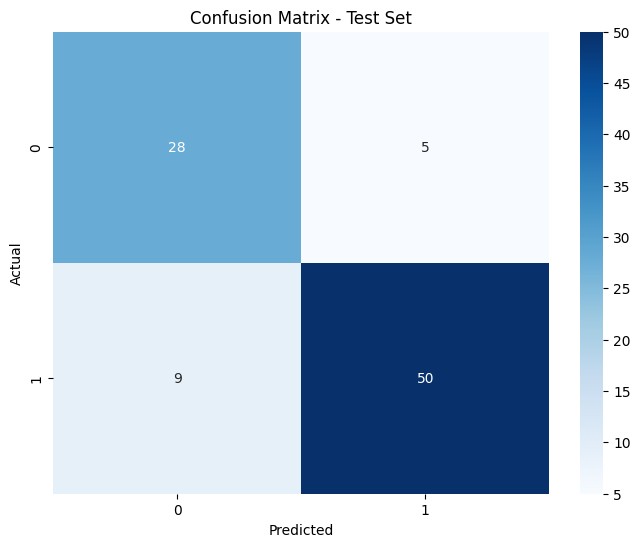

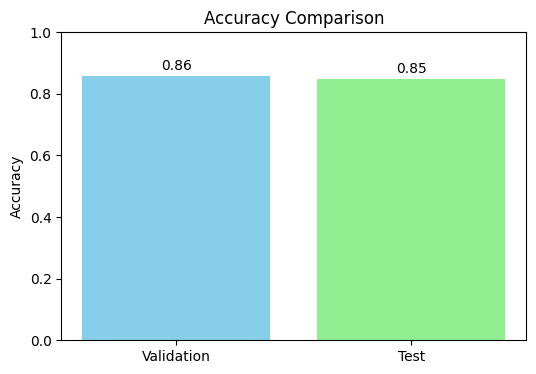

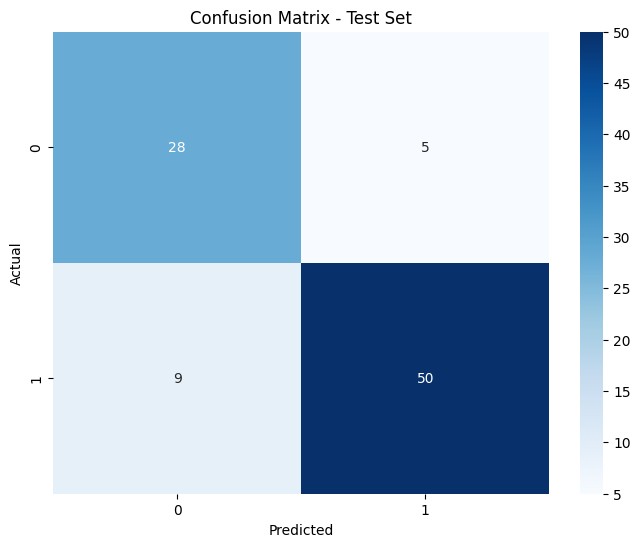

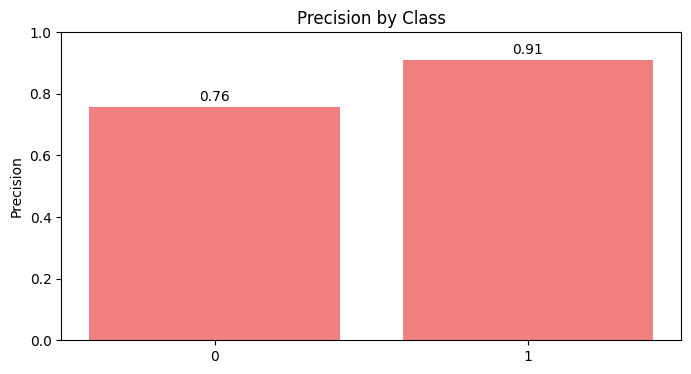

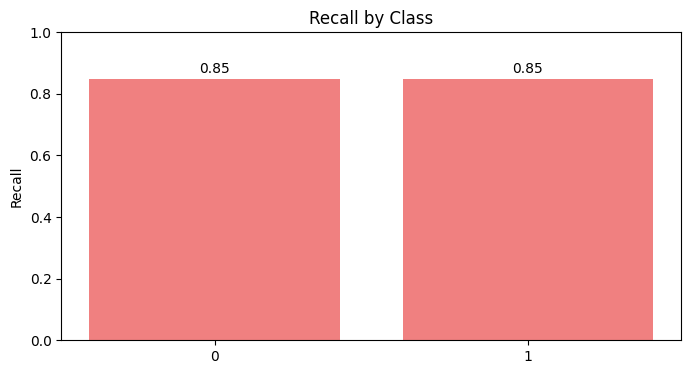

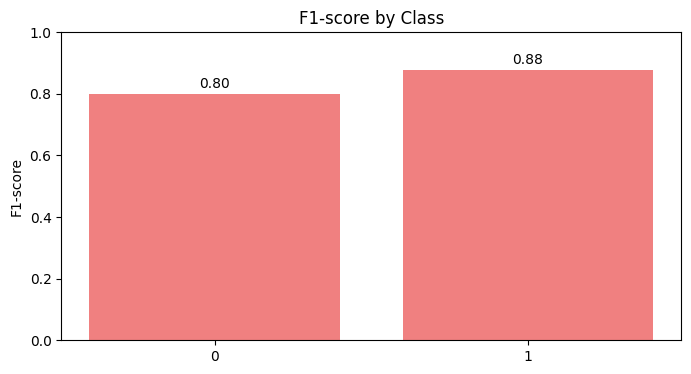

Scenario dataset_scenario_6_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 6_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with random for dataset_scenario_6_S...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_6_S
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8632
  Recall: 0.8587
  F1 Score: 0.8593

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


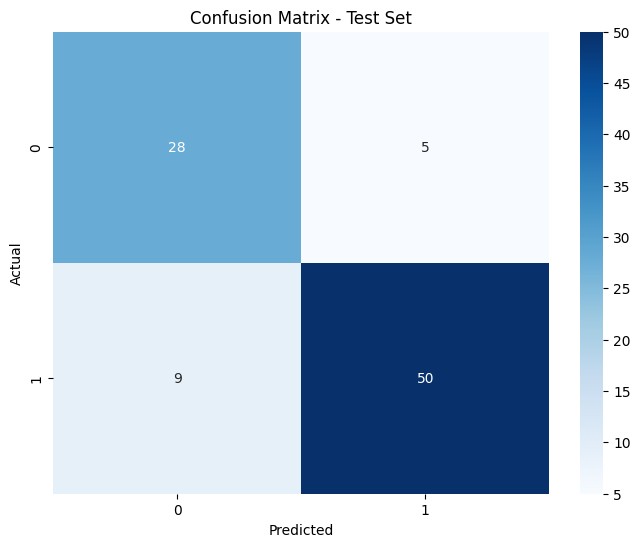

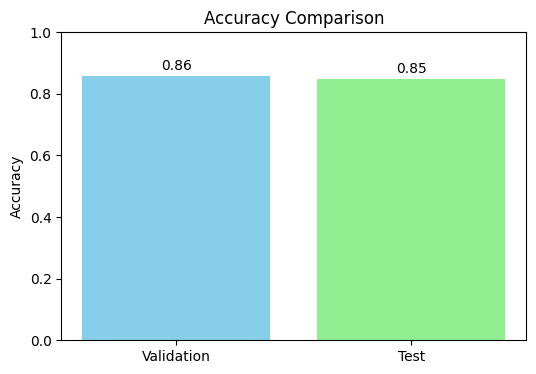

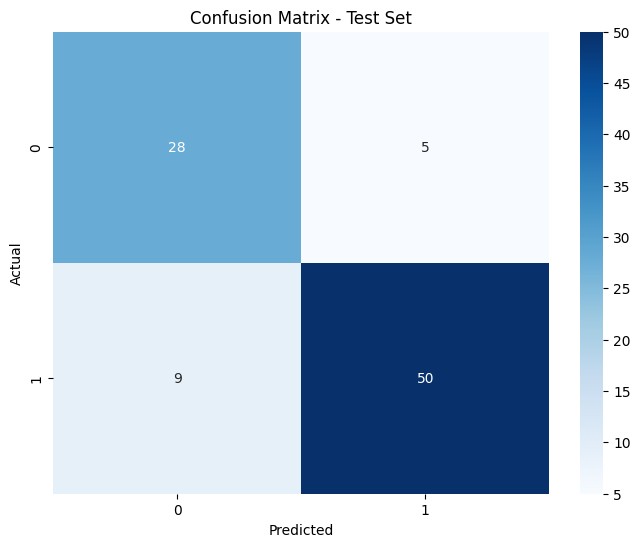

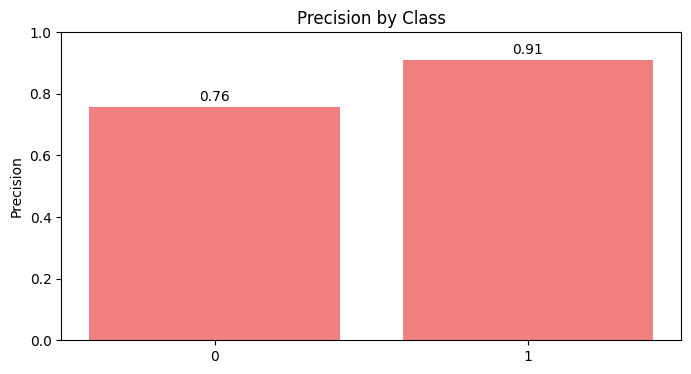

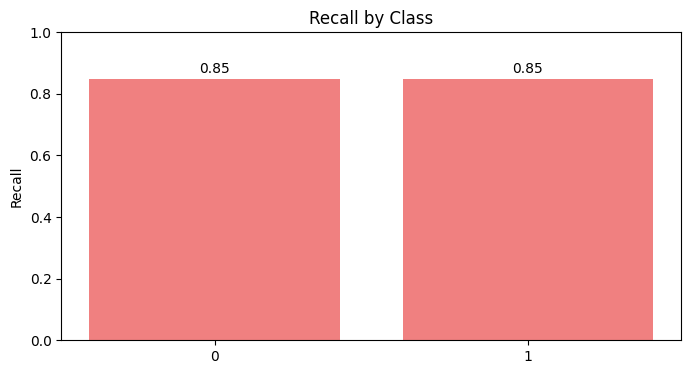

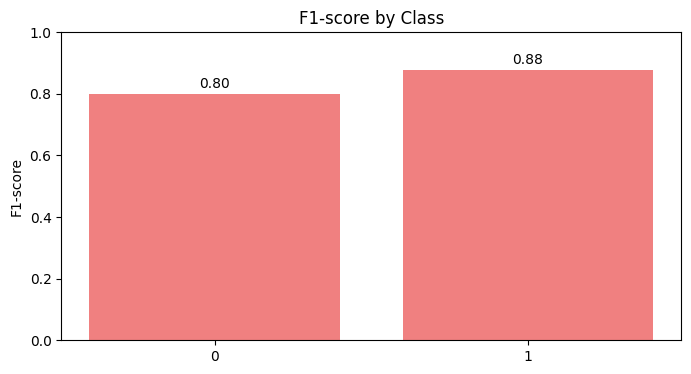

Scenario dataset_scenario_6_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 7_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with random for dataset_scenario_7_N...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_7_N
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8500
  Precision: 0.8499
  Recall: 0.8500
  F1 Score: 0.8499

Test Metrics:
  Accuracy: 0.8169
  Precision: 0.8436
  Recall: 0.8169
  F1 Score: 0.8169

Confusion Matrix (Test Set):
[[29 11]
 [ 2 29]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


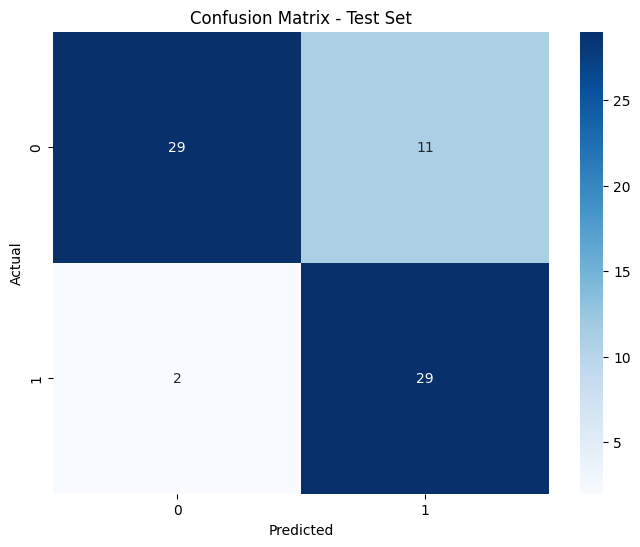

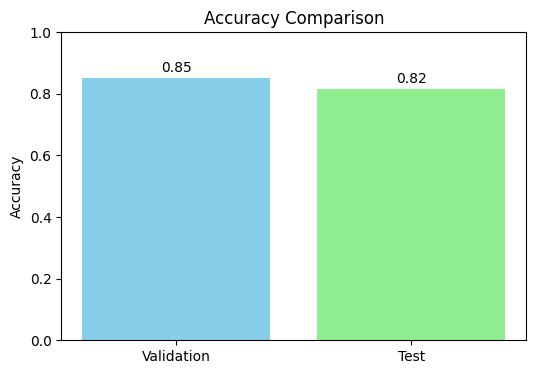

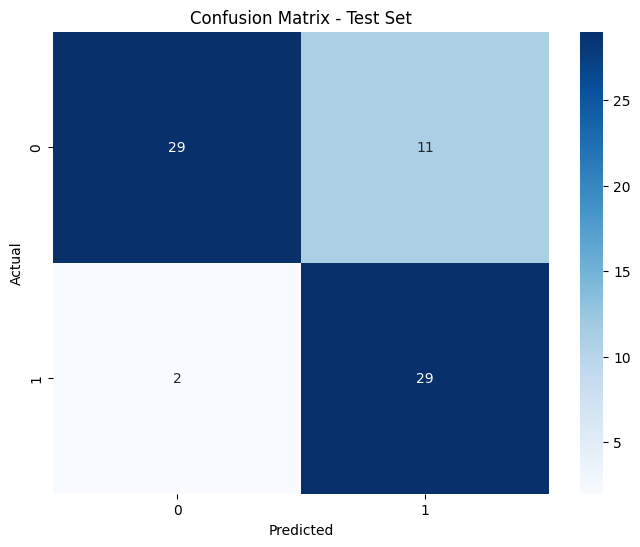

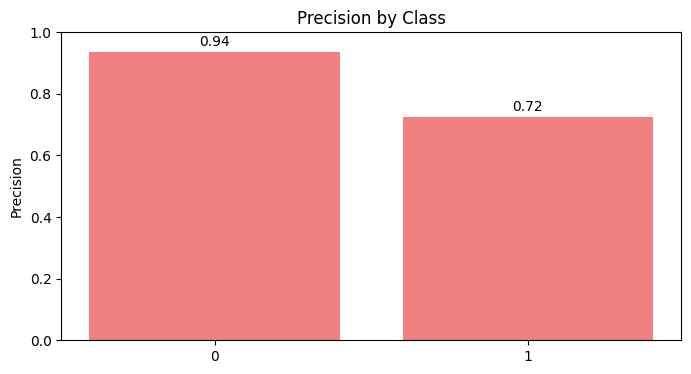

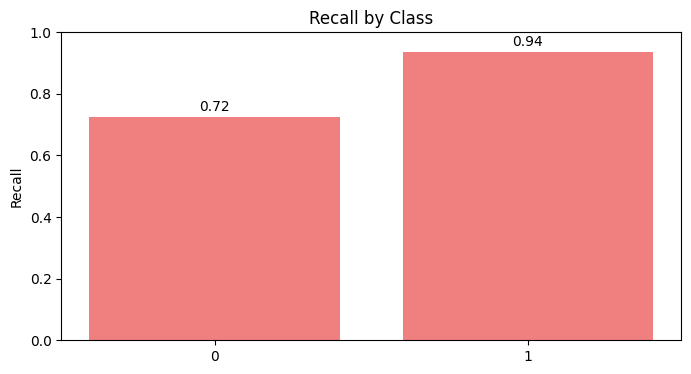

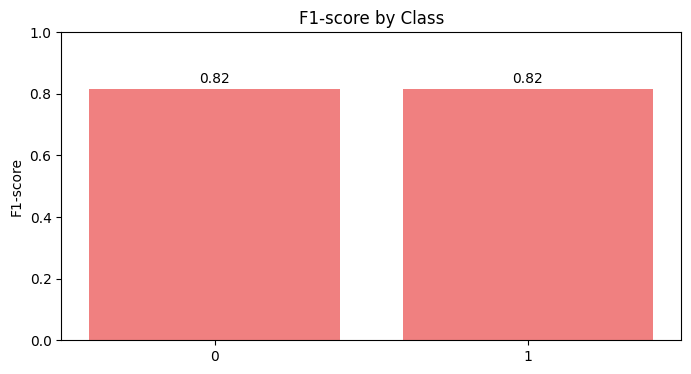

Scenario dataset_scenario_7_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 7_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with random for dataset_scenario_7_S...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_7_S
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8500
  Precision: 0.8499
  Recall: 0.8500
  F1 Score: 0.8499

Test Metrics:
  Accuracy: 0.8169
  Precision: 0.8436
  Recall: 0.8169
  F1 Score: 0.8169

Confusion Matrix (Test Set):
[[29 11]
 [ 2 29]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


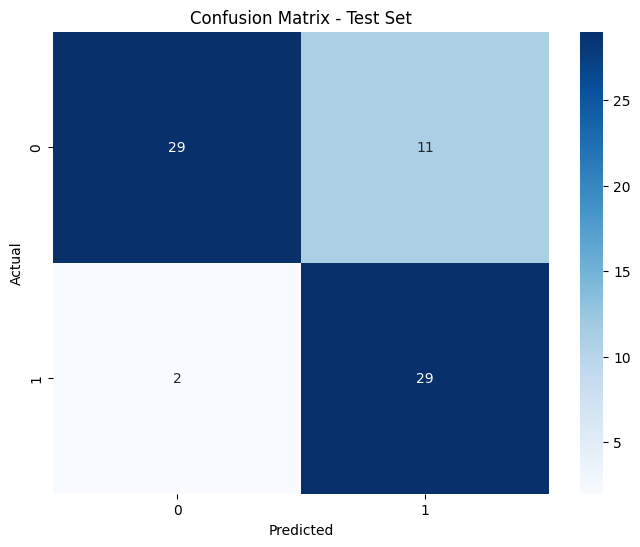

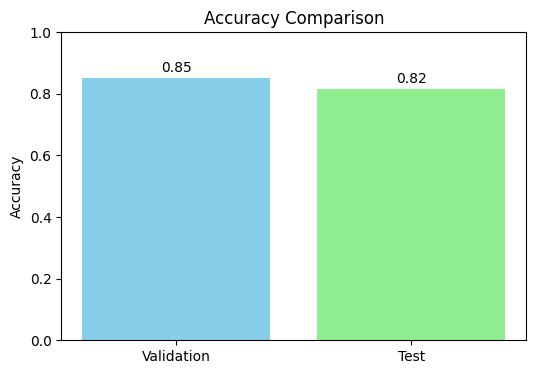

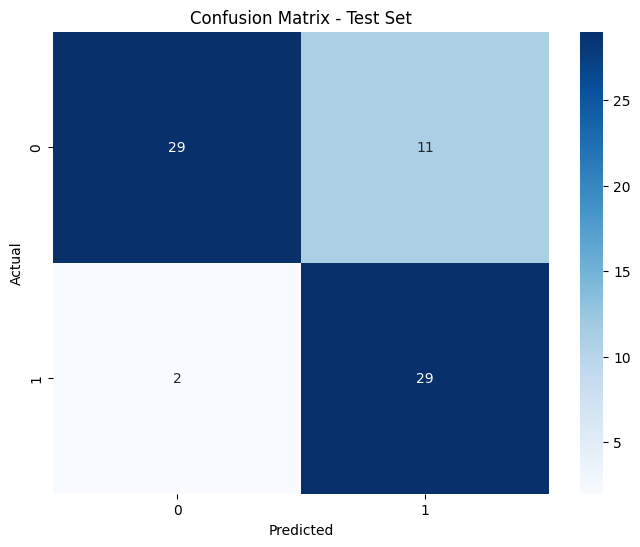

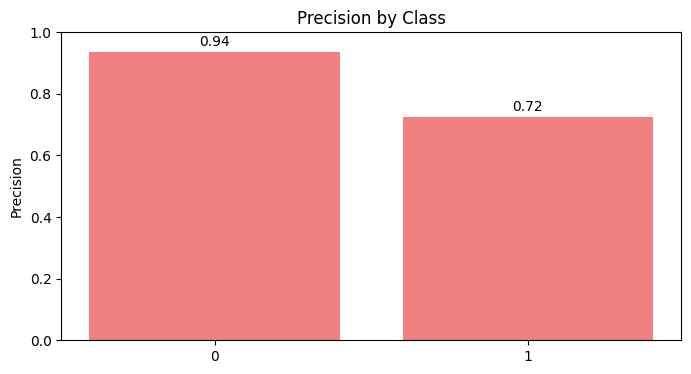

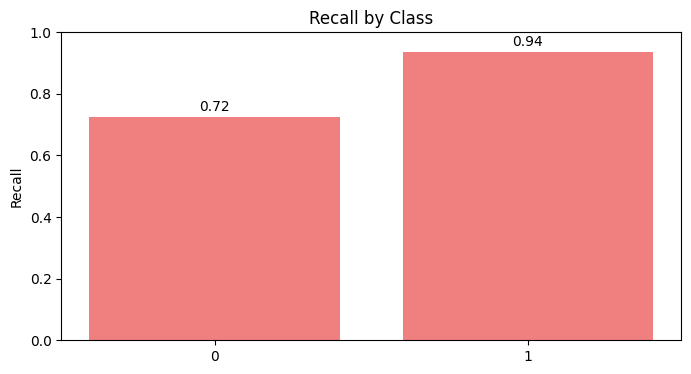

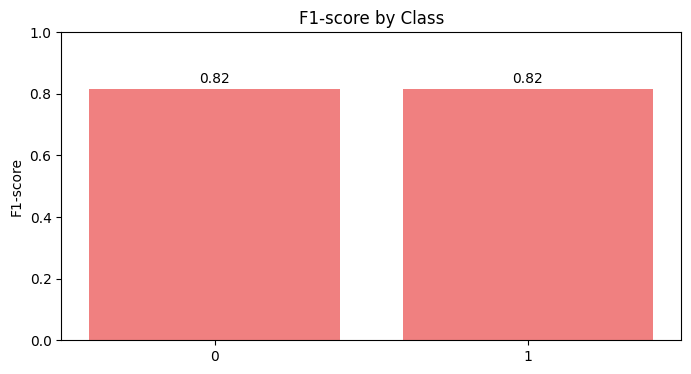

Scenario dataset_scenario_7_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 8_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running NaiveBayes with random for dataset_scenario_8_N...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_8_N
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8615
  Recall: 0.8587
  F1 Score: 0.8592

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


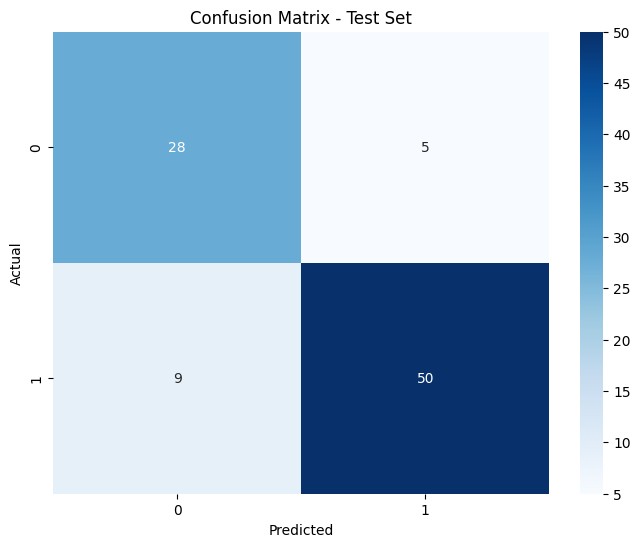

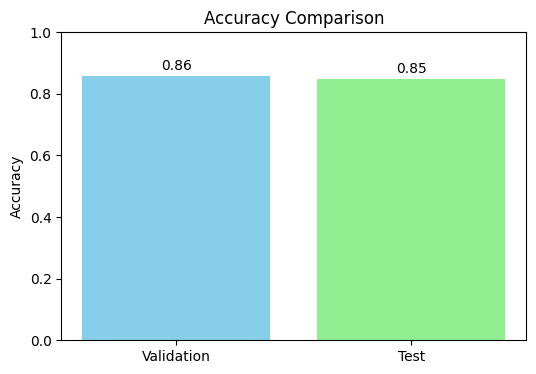

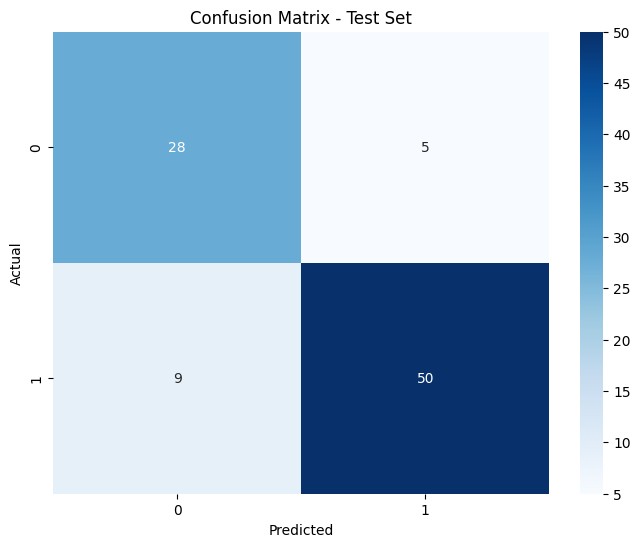

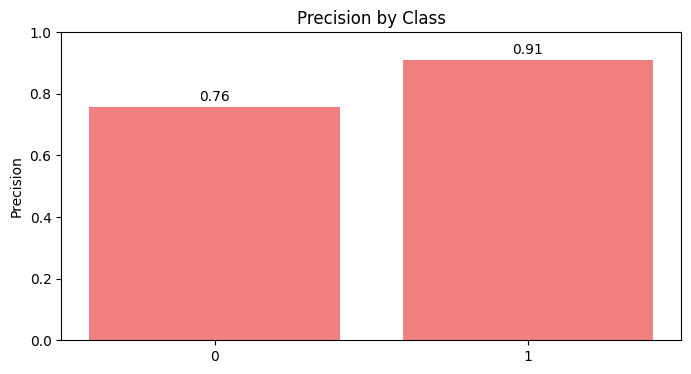

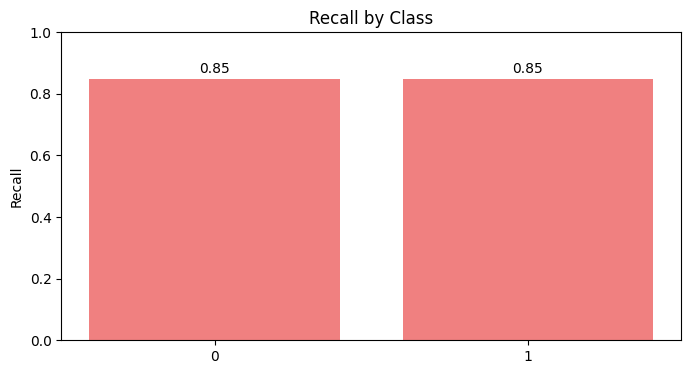

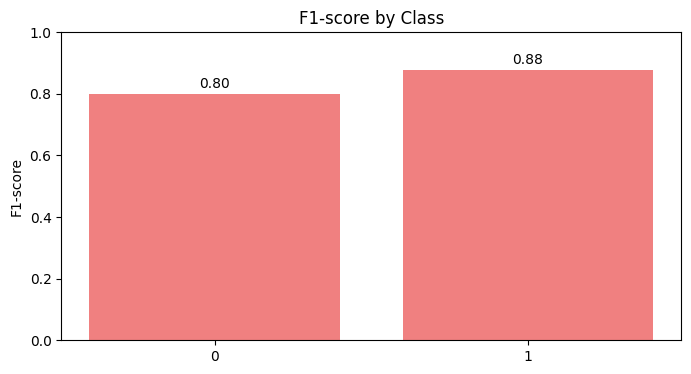

Scenario dataset_scenario_8_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 8_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running NaiveBayes with random for dataset_scenario_8_S...
Results will be saved in: SCORES\NaiveBayes\random\dataset_scenario_8_S
Best hyperparameters:  {'var_smoothing': 1e-09, 'priors': None}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8615
  Recall: 0.8587
  F1 Score: 0.8592

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


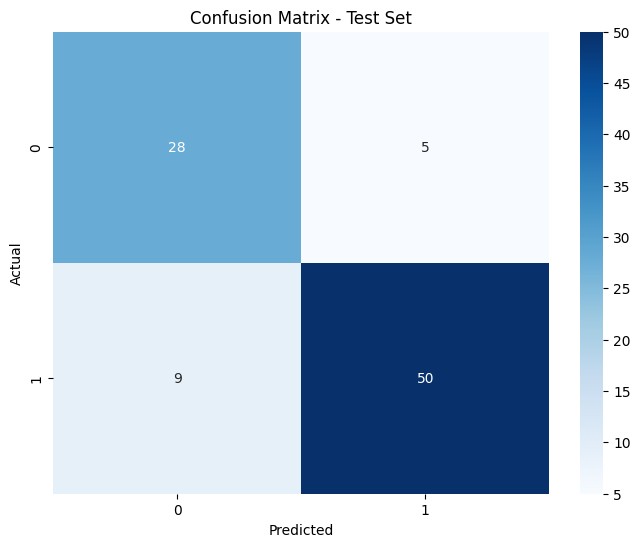

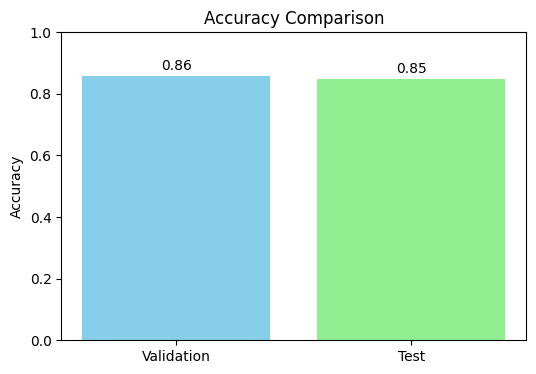

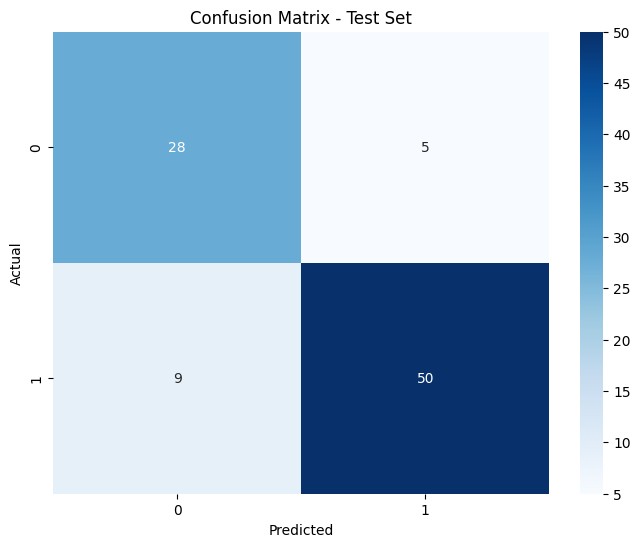

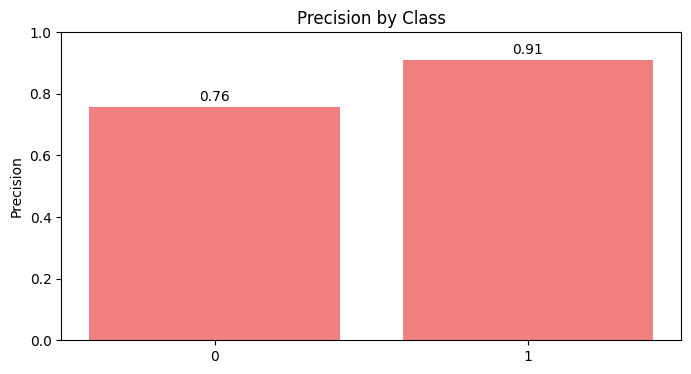

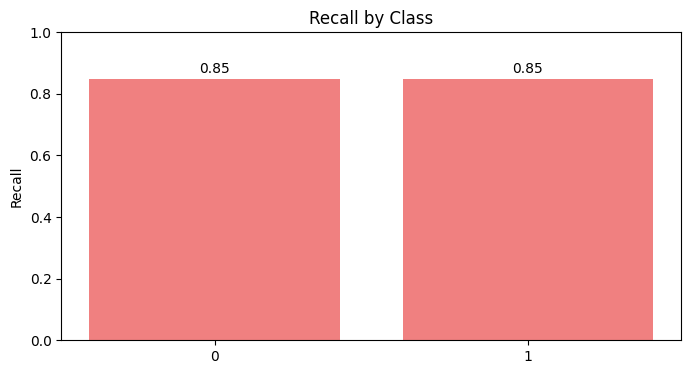

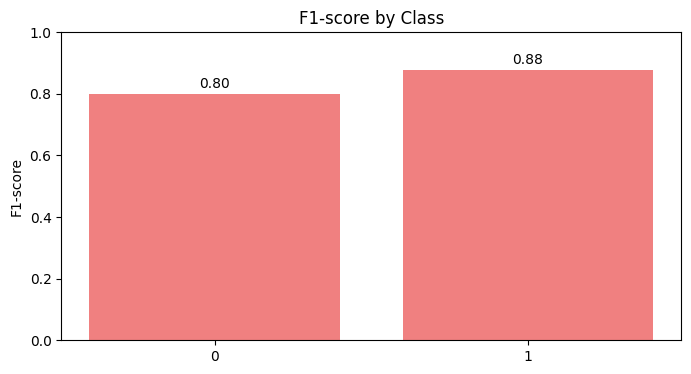

Scenario dataset_scenario_8_S with random completed and results saved.

----------------------------------------





In [10]:
for scenario, scenario_description in zip(scenario_datasets, scenarios_description):
    print(f"Scenario Name: {scenario_description['name']}")
    print(f"  Encoding: {scenario_description['encoding']}")
    print(f"  Remove Outliers: {scenario_description['remove_outliers']}")
    print(f"  Remove Errors: {scenario_description.get('remove_errors', 'Not Specified')}")
    print(f"  Impute Zeros: {scenario_description.get('impute_zeros', 'None')}")
    print(f"  Oldpeak Absolute: {scenario_description.get('oldpeak_abs', 'Not Specified')}")
    print(f"  Scaling: {scenario_description['scaling']}")

    # Run for Naive Bayes
    run_scenario(scenario, "NaiveBayes", "random", search_config_random, get_search_hyperparameters("NaiveBayes"))
    
    print("-" * 40)
    print("\n\n")

## 3. Bayesian Optimization (Optuna)

In [11]:
for scenario, scenario_description in zip(scenario_datasets, scenarios_description):
    print(f"Scenario Name: {scenario_description['name']}")
    print(f"  Encoding: {scenario_description['encoding']}")
    print(f"  Remove Outliers: {scenario_description['remove_outliers']}")
    print(f"  Remove Errors: {scenario_description.get('remove_errors', 'Not Specified')}")
    print(f"  Impute Zeros: {scenario_description.get('impute_zeros', 'None')}")
    print(f"  Oldpeak Absolute: {scenario_description.get('oldpeak_abs', 'Not Specified')}")
    print(f"  Scaling: {scenario_description['scaling']}")

    # Run for Naive Bayes
    run_scenario(scenario, "NaiveBayes", "optuna", search_config_optuna, get_search_hyperparameters("NaiveBayes"))
    
    print("-" * 40)
    print("\n\n")

[I 2024-12-01 01:08:47,463] A new study created in memory with name: no-name-adf7b8a1-2e4d-4857-99d1-a97b3f1db7e3


Scenario Name: Scenario 1_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running NaiveBayes with optuna for dataset_scenario_1_N...
Results will be saved in: SCORES\NaiveBayes\optuna\dataset_scenario_1_N


[I 2024-12-01 01:08:49,598] Trial 0 finished with value: 0.8488735465116278 and parameters: {'var_smoothing': 7.86537192078107e-06}. Best is trial 0 with value: 0.8488735465116278.
[I 2024-12-01 01:08:50,656] Trial 1 finished with value: 0.8488735465116278 and parameters: {'var_smoothing': 5.537829046309612e-06}. Best is trial 0 with value: 0.8488735465116278.
[I 2024-12-01 01:08:50,696] Trial 2 finished with value: 0.8488735465116278 and parameters: {'var_smoothing': 4.191424041104245e-06}. Best is trial 0 with value: 0.8488735465116278.
[I 2024-12-01 01:08:50,773] Trial 3 finished with value: 0.8488735465116278 and parameters: {'var_smoothing': 4.283263481826966e-06}. Best is trial 0 with value: 0.8488735465116278.
[I 2024-12-01 01:08:50,803] Trial 4 finished with value: 0.8488735465116278 and parameters: {'var_smoothing': 8.905758472017723e-06}. Best is trial 0 with value: 0.8488735465116278.
[I 2024-12-01 01:08:50,827] Trial 5 finished with value: 0.8488735465116278 and parameters:

Best hyperparameters:  {'var_smoothing': 7.86537192078107e-06}


NotFittedError: This GaussianNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# SVM

## 1. Grid Search

Scenario Name: Scenario 1_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with grid for dataset_scenario_1_N...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_1_N
Best hyperparameters:  {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Validation Metrics:
  Accuracy: 0.8750
  Precision: 0.8760
  Recall: 0.8750
  F1 Score: 0.8753

Test Metrics:
  Accuracy: 0.8913
  Precision: 0.8935
  Recall: 0.8913
  F1 Score: 0.8920

Confusion Matrix (Test Set):
[[29  4]
 [ 6 53]]


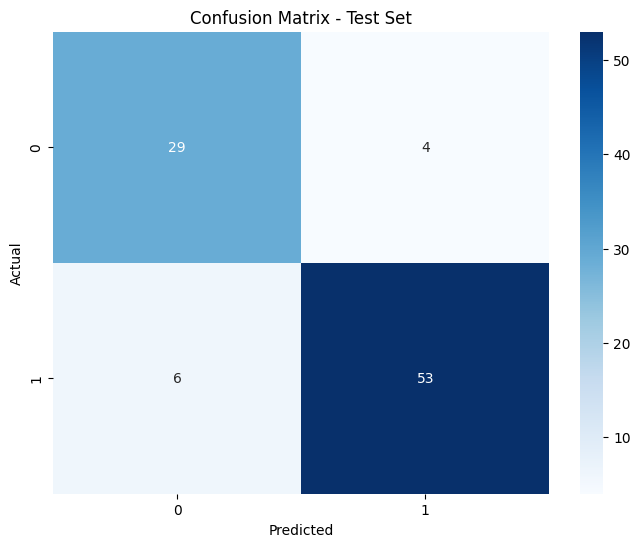

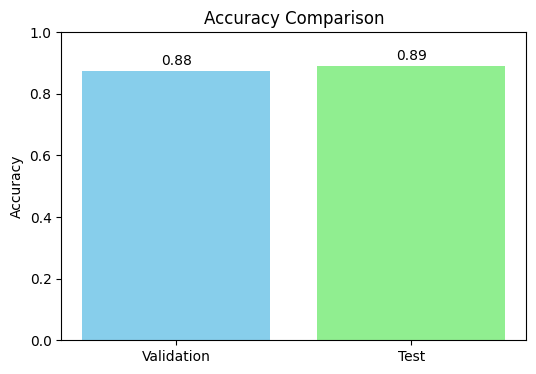

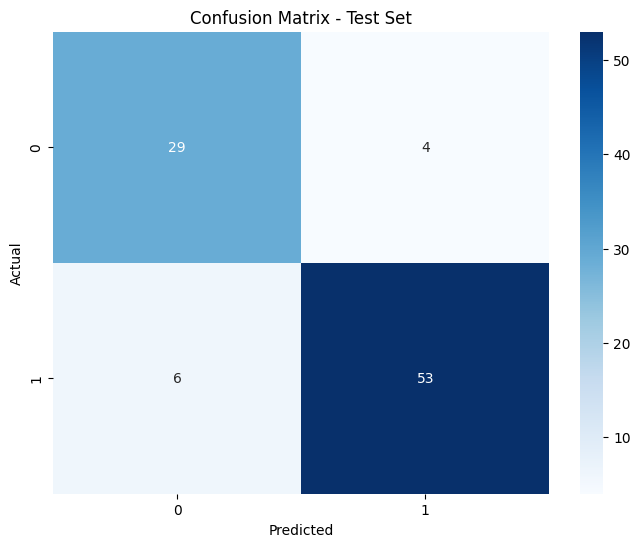

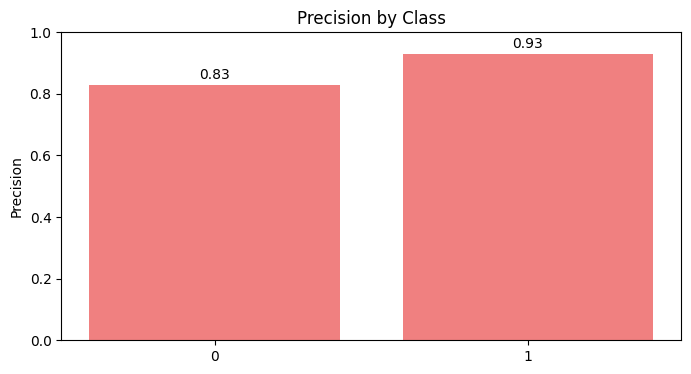

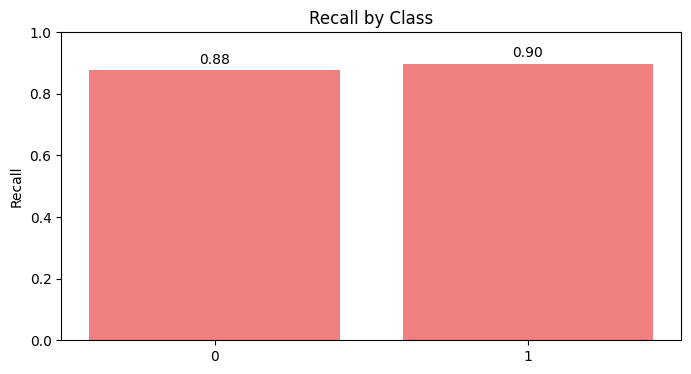

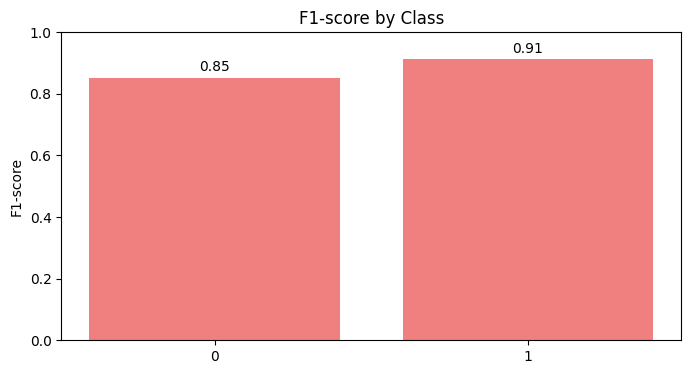

Scenario dataset_scenario_1_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 1_S
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with grid for dataset_scenario_1_S...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_1_S
Best hyperparameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8859
  Precision: 0.8868
  Recall: 0.8859
  F1 Score: 0.8861

Test Metrics:
  Accuracy: 0.8913
  Precision: 0.8913
  Recall: 0.8913
  F1 Score: 0.8913

Confusion Matrix (Test Set):
[[28  5]
 [ 5 54]]


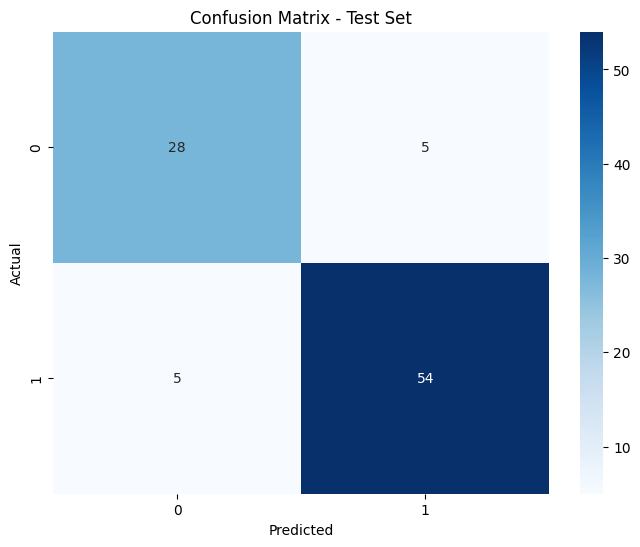

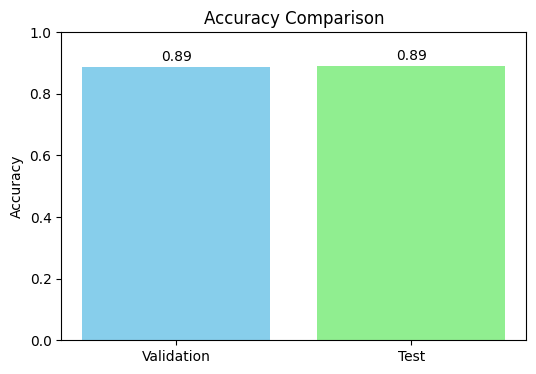

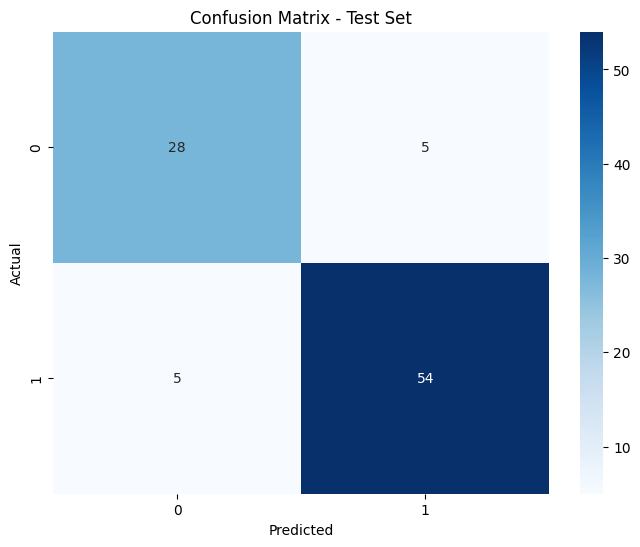

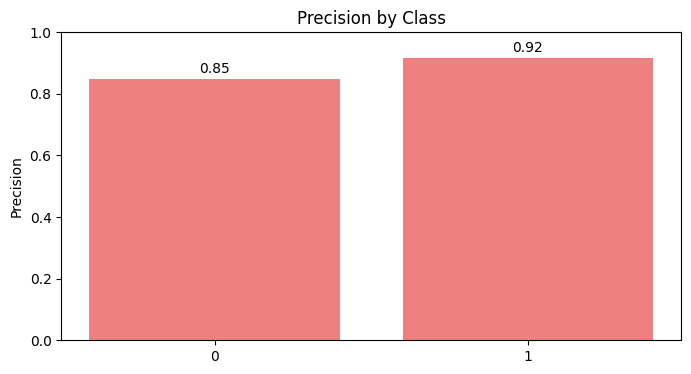

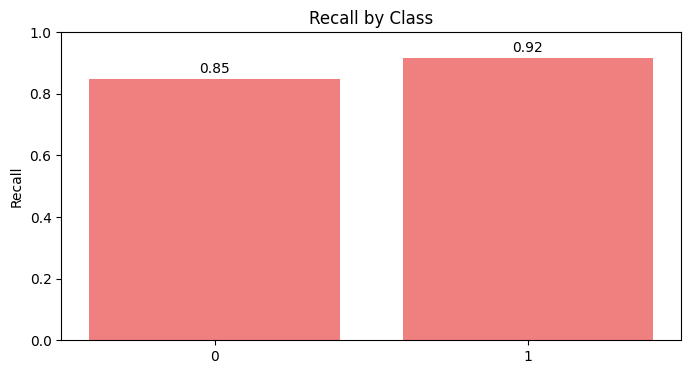

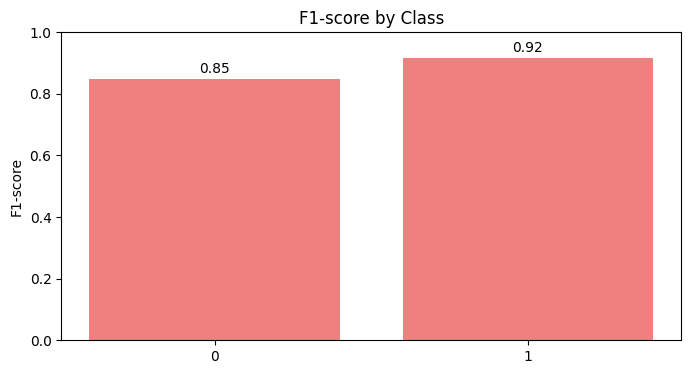

Scenario dataset_scenario_1_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 2_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: {'RestingBP': 'mean', 'Cholesterol': 'mean'}
  Oldpeak Absolute: True
  Scaling: MinMax
Running SVM with grid for dataset_scenario_2_N...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_2_N
Best hyperparameters:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8533
  Precision: 0.8569
  Recall: 0.8533
  F1 Score: 0.8538

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


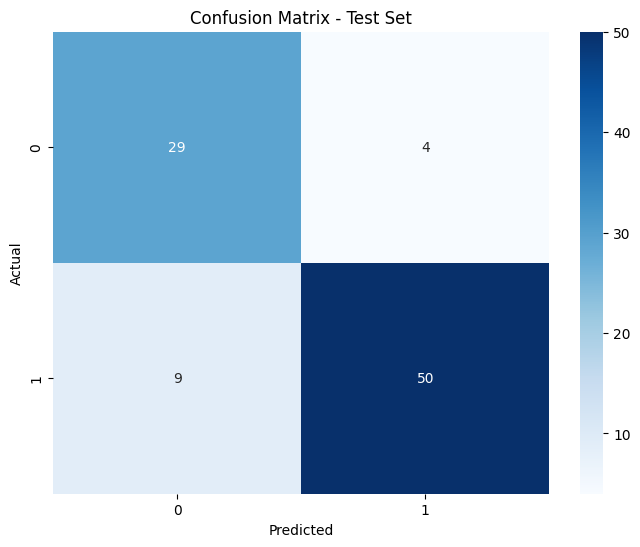

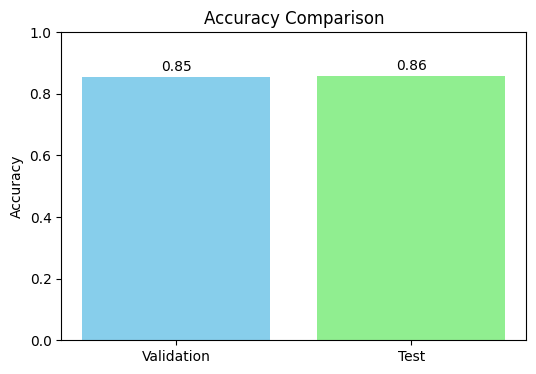

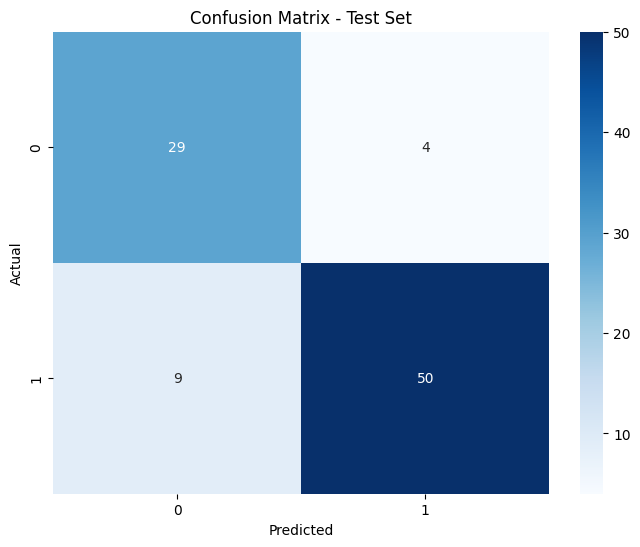

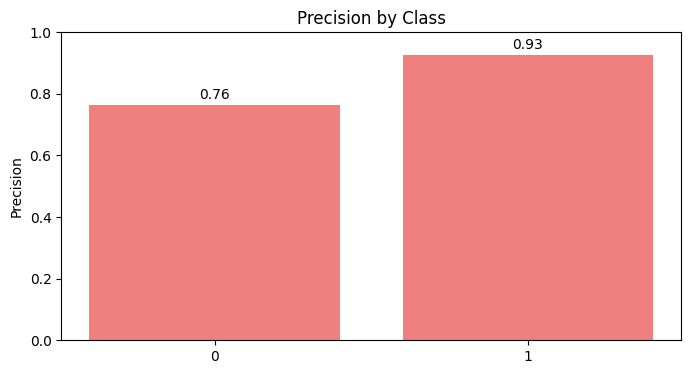

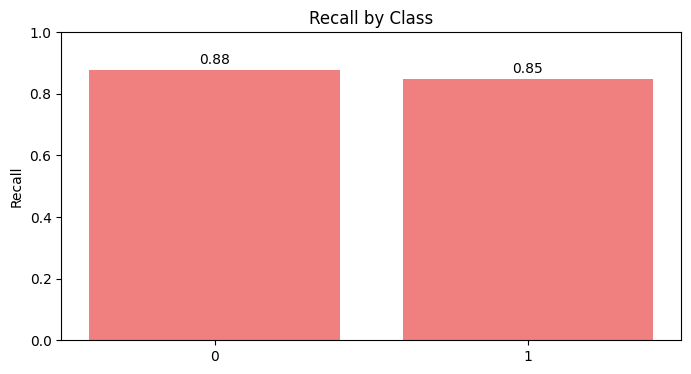

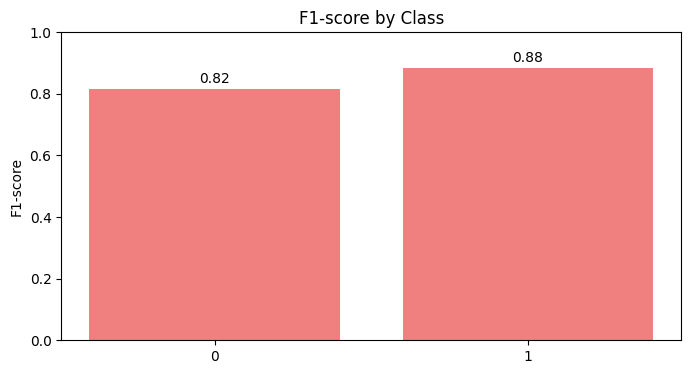

Scenario dataset_scenario_2_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 2_S
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: {'RestingBP': 'mean', 'Cholesterol': 'mean'}
  Oldpeak Absolute: True
  Scaling: Standard
Running SVM with grid for dataset_scenario_2_S...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_2_S
Best hyperparameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8696
  Precision: 0.8724
  Recall: 0.8696
  F1 Score: 0.8700

Test Metrics:
  Accuracy: 0.8804
  Precision: 0.8844
  Recall: 0.8804
  F1 Score: 0.8815

Confusion Matrix (Test Set):
[[29  4]
 [ 7 52]]


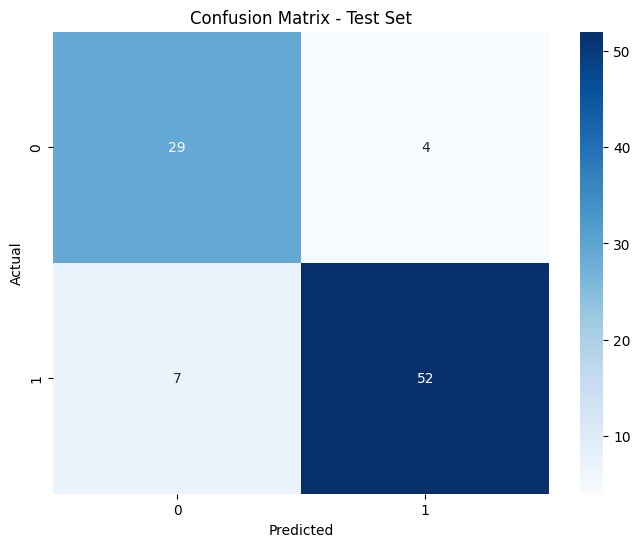

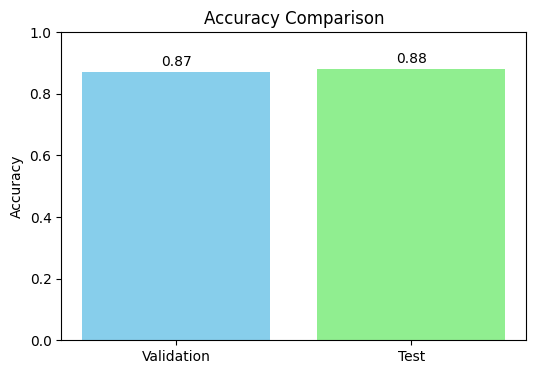

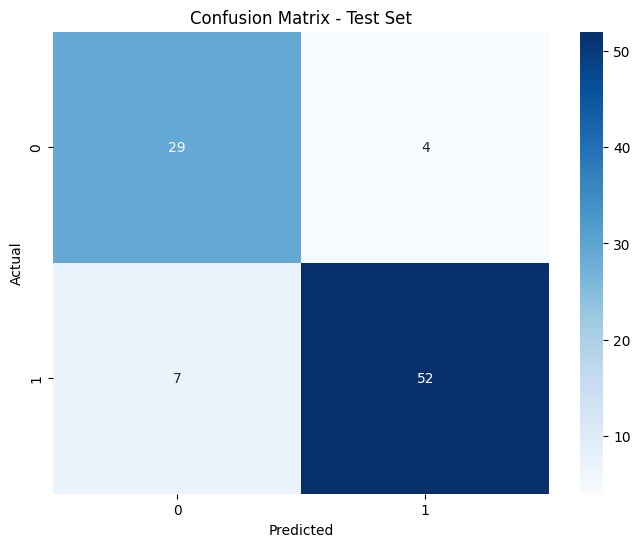

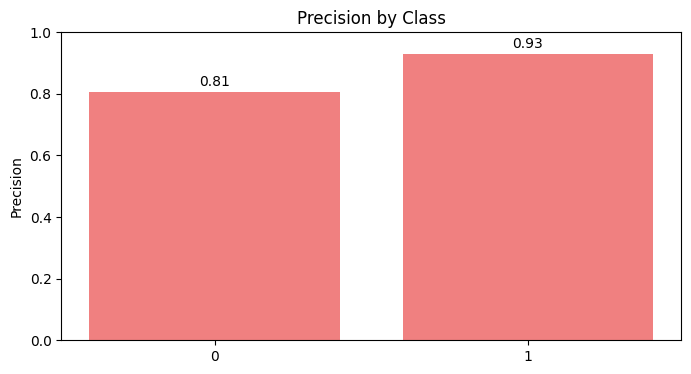

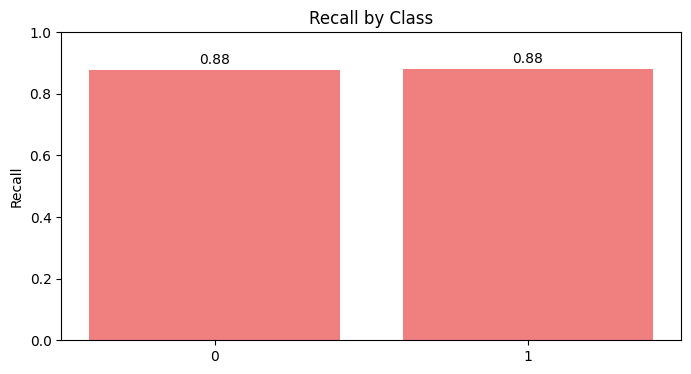

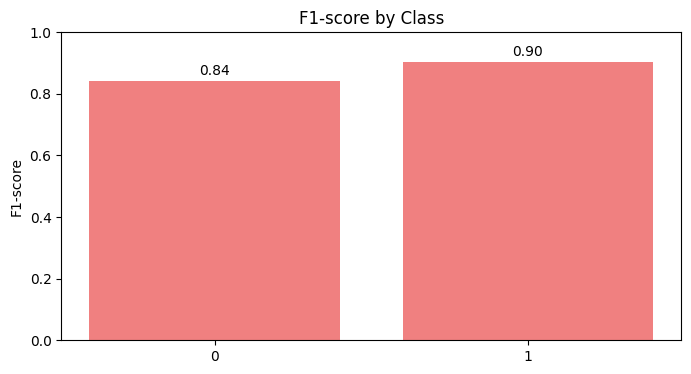

Scenario dataset_scenario_2_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 3_N
  Encoding: Label encoding
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running SVM with grid for dataset_scenario_3_N...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_3_N
Best hyperparameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}
Validation Metrics:
  Accuracy: 0.8643
  Precision: 0.8642
  Recall: 0.8643
  F1 Score: 0.8642

Test Metrics:
  Accuracy: 0.8169
  Precision: 0.8339
  Recall: 0.8169
  F1 Score: 0.8174

Confusion Matrix (Test Set):
[[30 10]
 [ 3 28]]


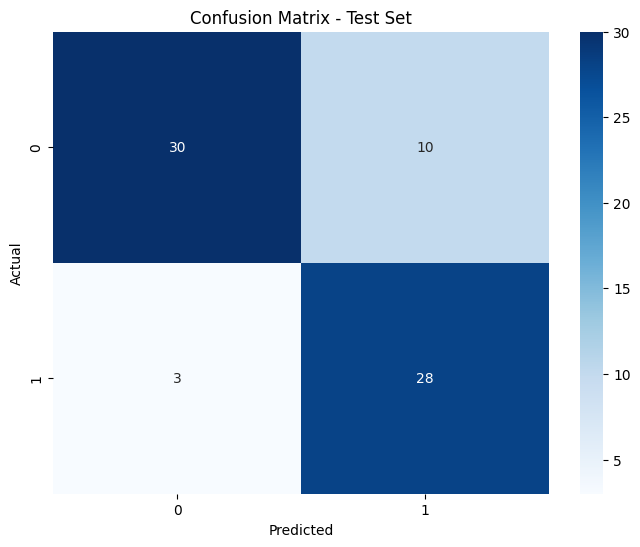

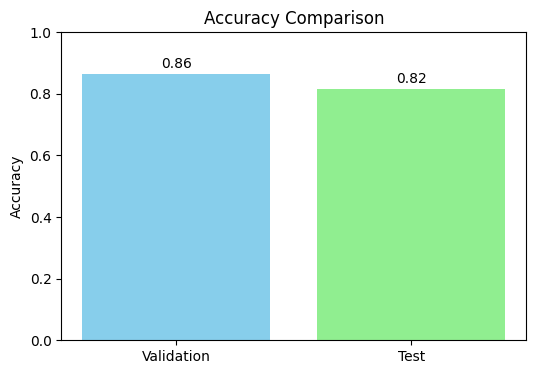

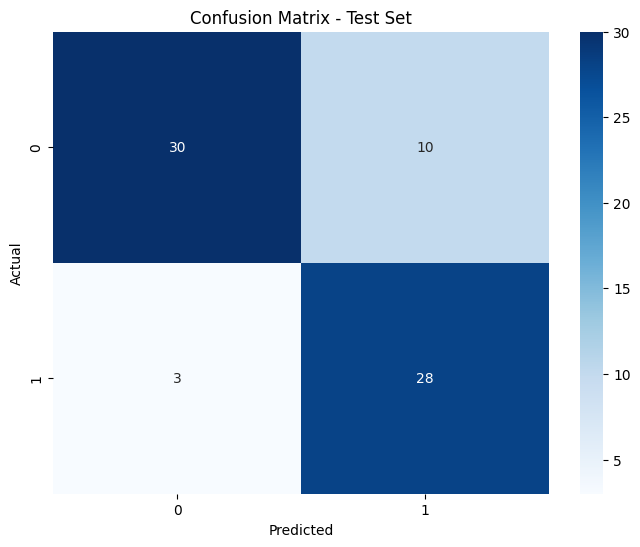

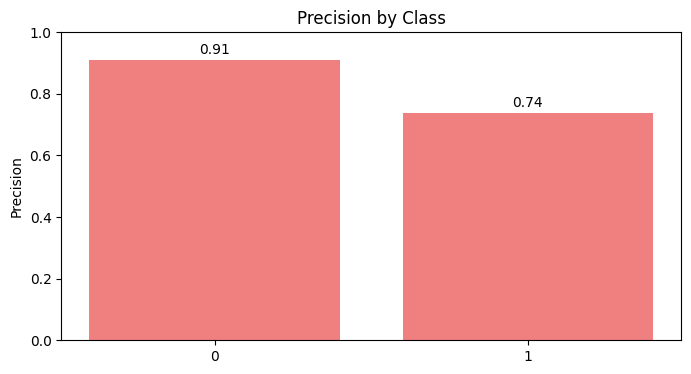

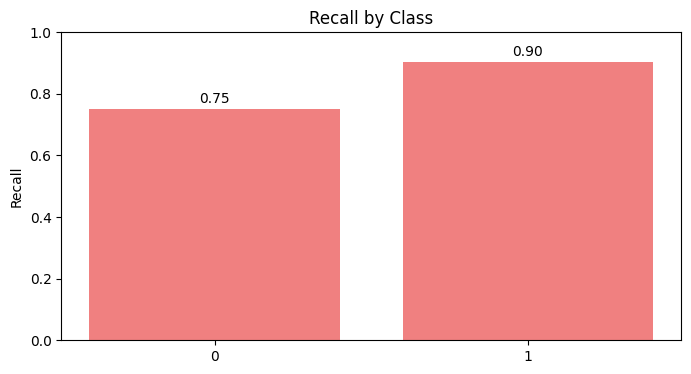

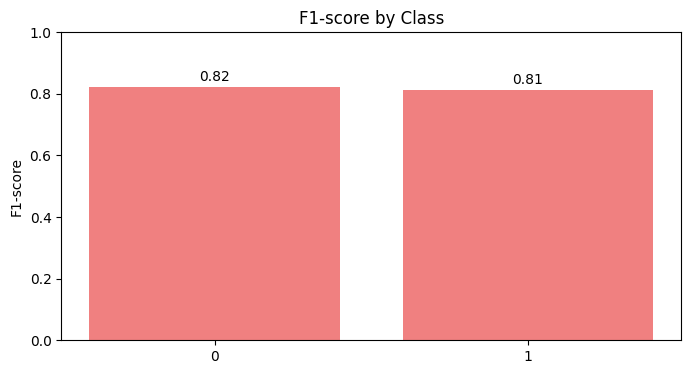

Scenario dataset_scenario_3_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 3_S
  Encoding: Label encoding
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with grid for dataset_scenario_3_S...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_3_S
Best hyperparameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8643
  Precision: 0.8655
  Recall: 0.8643
  F1 Score: 0.8645

Test Metrics:
  Accuracy: 0.8310
  Precision: 0.8528
  Recall: 0.8310
  F1 Score: 0.8313

Confusion Matrix (Test Set):
[[30 10]
 [ 2 29]]


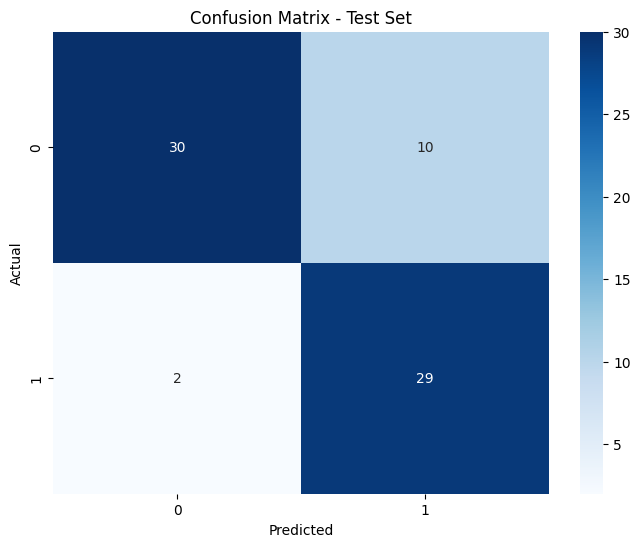

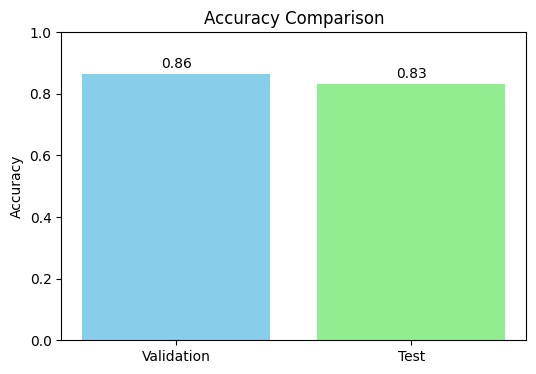

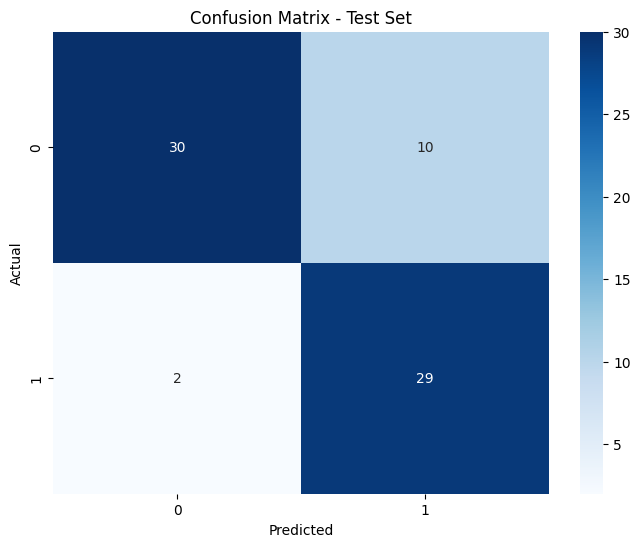

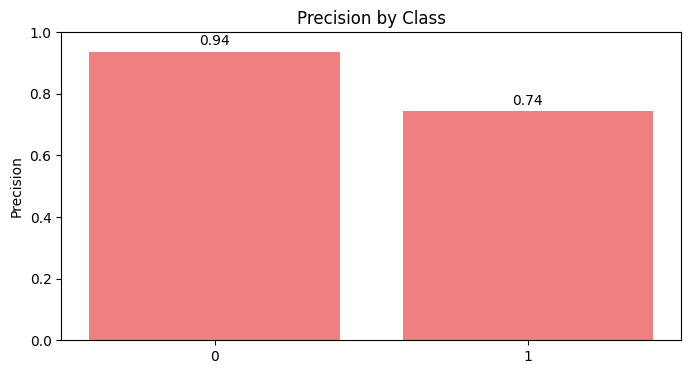

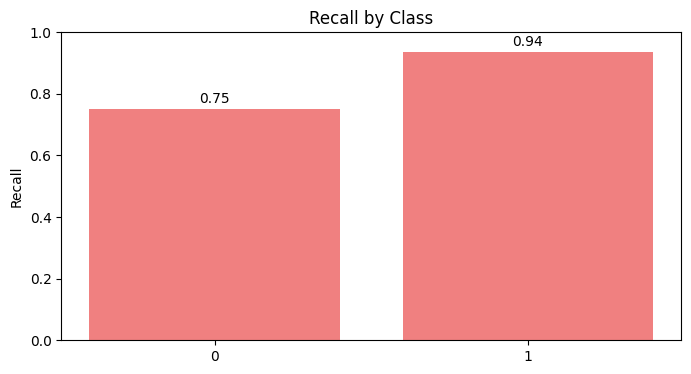

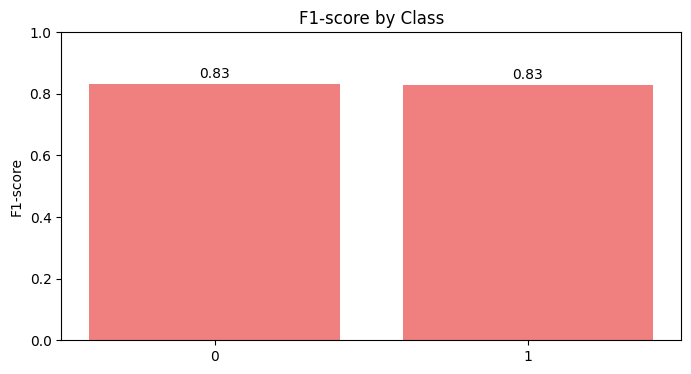

Scenario dataset_scenario_3_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 4_N
  Encoding: Label encoding
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with grid for dataset_scenario_4_N...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_4_N
Best hyperparameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8750
  Precision: 0.8748
  Recall: 0.8750
  F1 Score: 0.8749

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8630
  Recall: 0.8587
  F1 Score: 0.8599

Confusion Matrix (Test Set):
[[28  5]
 [ 8 51]]


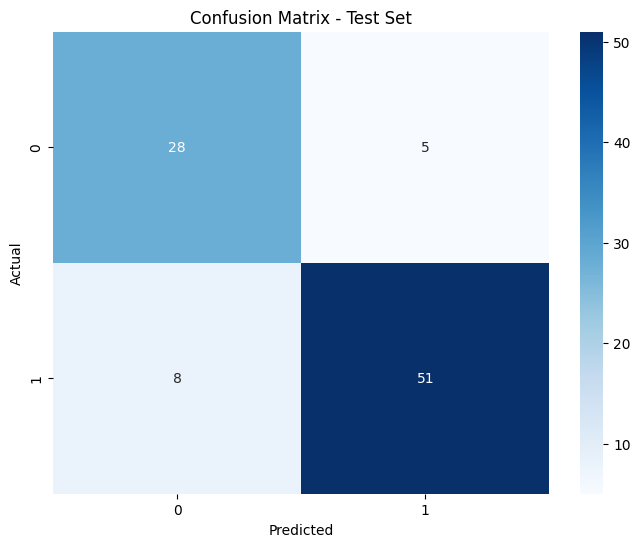

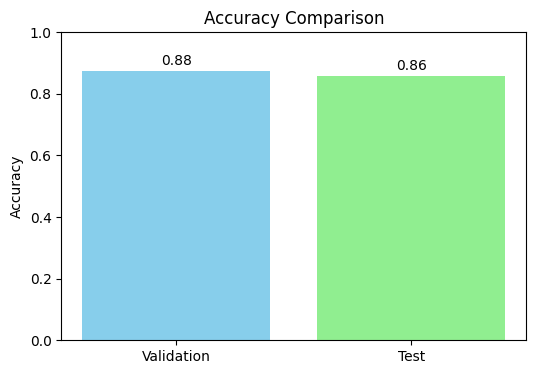

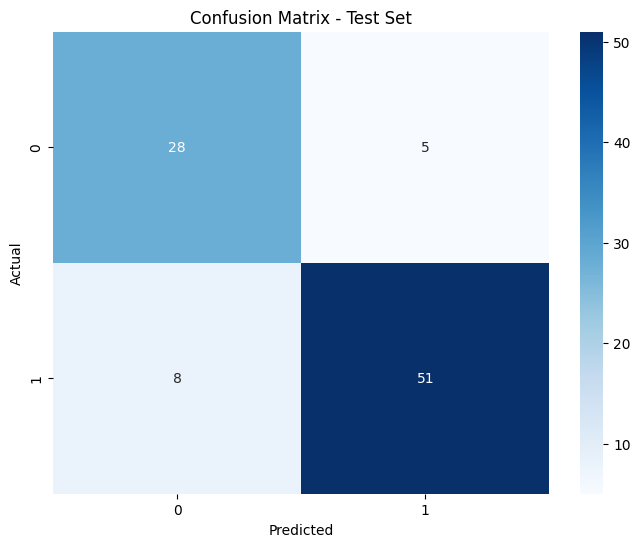

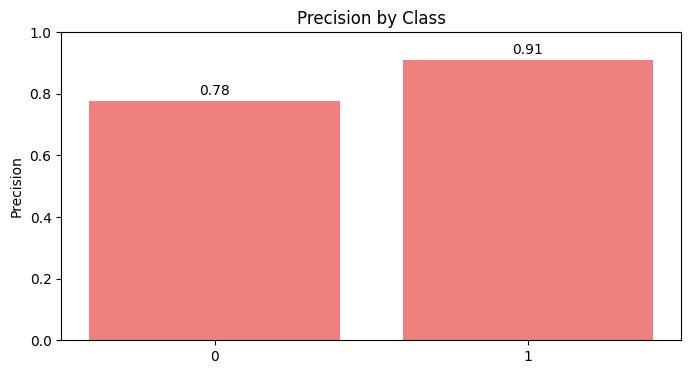

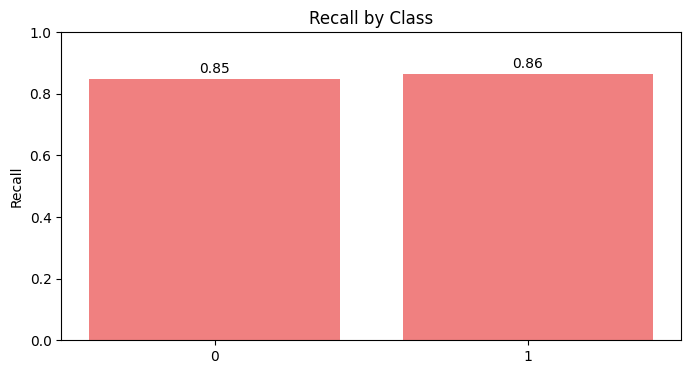

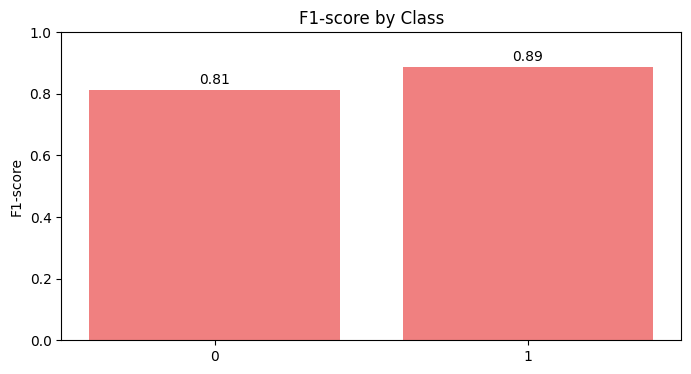

Scenario dataset_scenario_4_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 4_S
  Encoding: Label encoding
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with grid for dataset_scenario_4_S...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_4_S
Best hyperparameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8696
  Precision: 0.8711
  Recall: 0.8696
  F1 Score: 0.8699

Test Metrics:
  Accuracy: 0.8696
  Precision: 0.8720
  Recall: 0.8696
  F1 Score: 0.8704

Confusion Matrix (Test Set):
[[28  5]
 [ 7 52]]


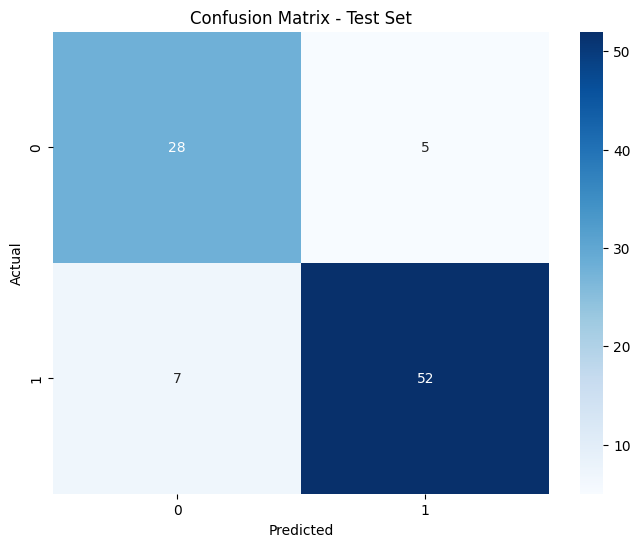

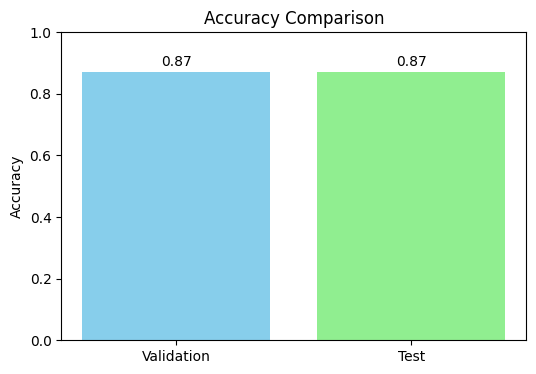

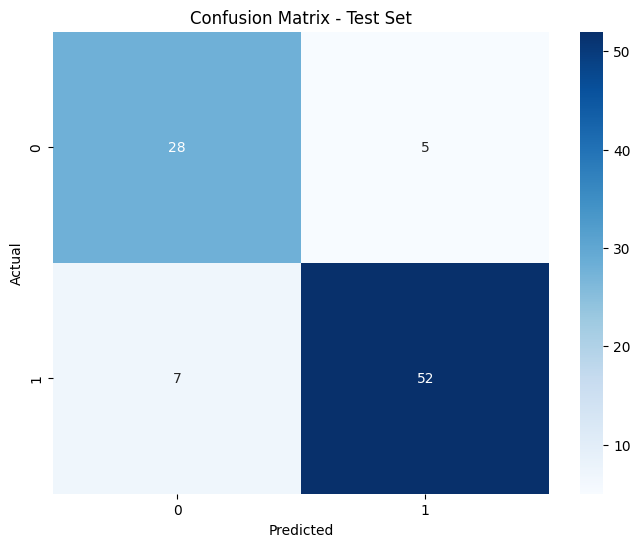

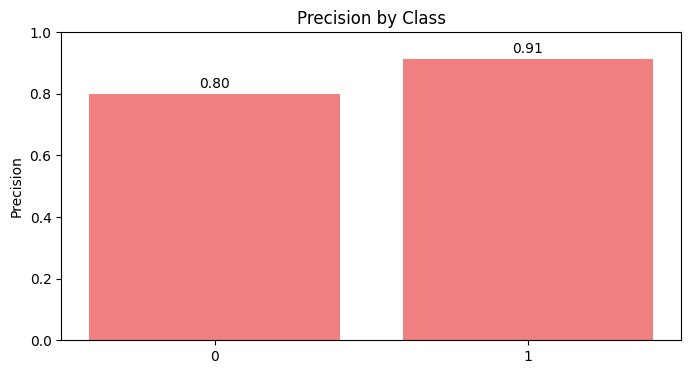

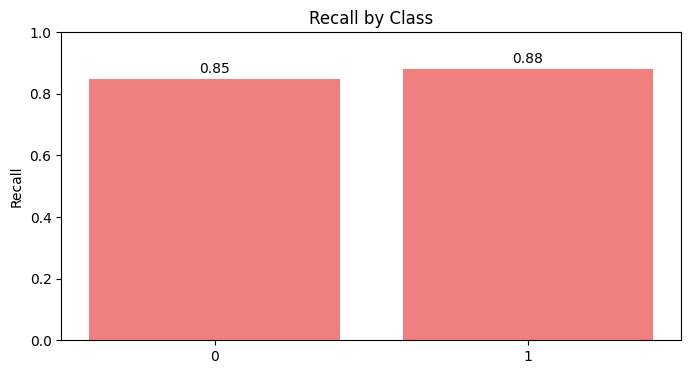

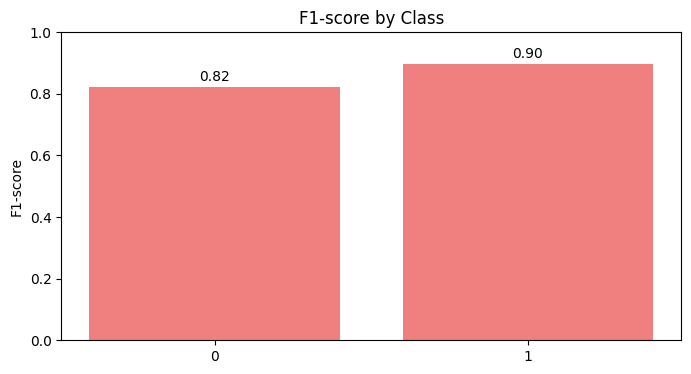

Scenario dataset_scenario_4_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 5_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with grid for dataset_scenario_5_N...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_5_N
Best hyperparameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'poly'}
Validation Metrics:
  Accuracy: 0.8587
  Precision: 0.8603
  Recall: 0.8587
  F1 Score: 0.8591

Test Metrics:
  Accuracy: 0.8913
  Precision: 0.8935
  Recall: 0.8913
  F1 Score: 0.8920

Confusion Matrix (Test Set):
[[29  4]
 [ 6 53]]


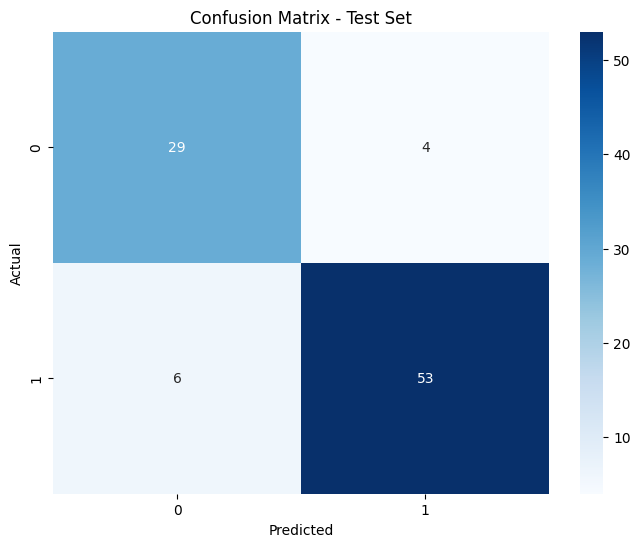

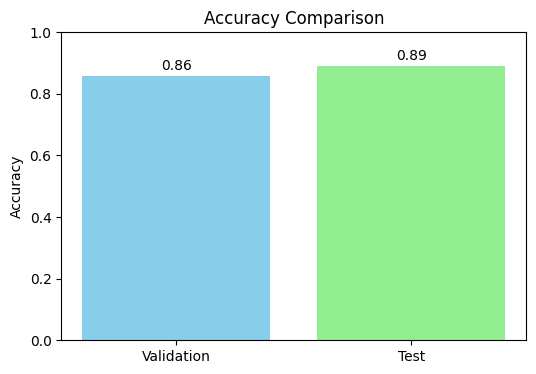

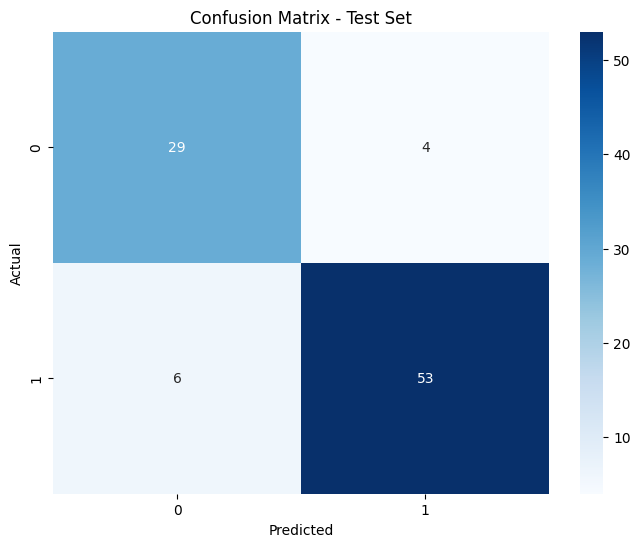

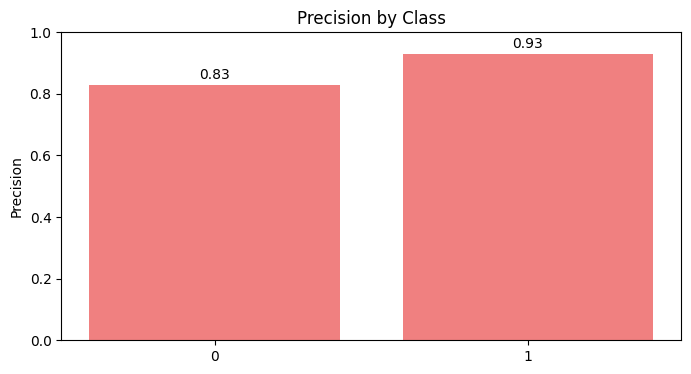

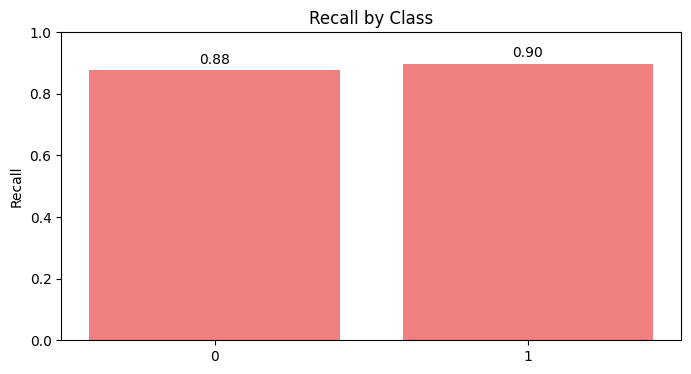

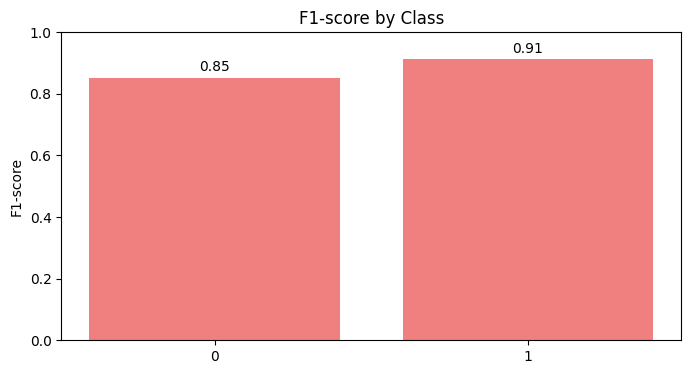

Scenario dataset_scenario_5_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 5_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with grid for dataset_scenario_5_S...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_5_S
Best hyperparameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8804
  Precision: 0.8804
  Recall: 0.8804
  F1 Score: 0.8804

Test Metrics:
  Accuracy: 0.8913
  Precision: 0.8935
  Recall: 0.8913
  F1 Score: 0.8920

Confusion Matrix (Test Set):
[[29  4]
 [ 6 53]]


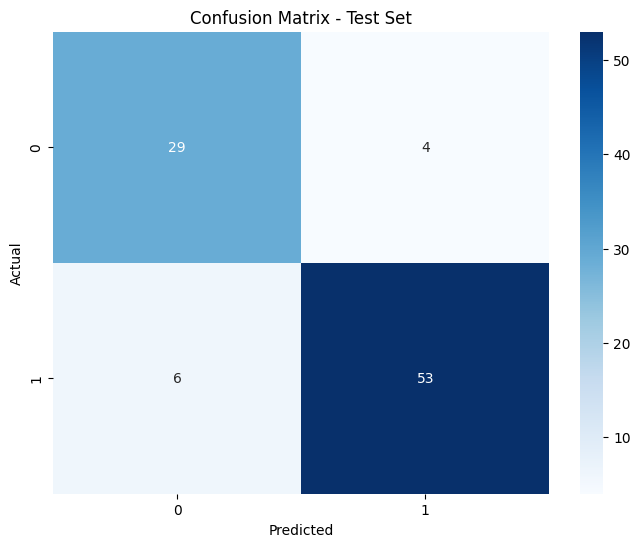

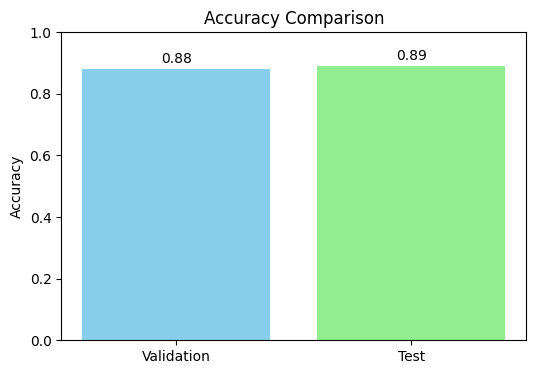

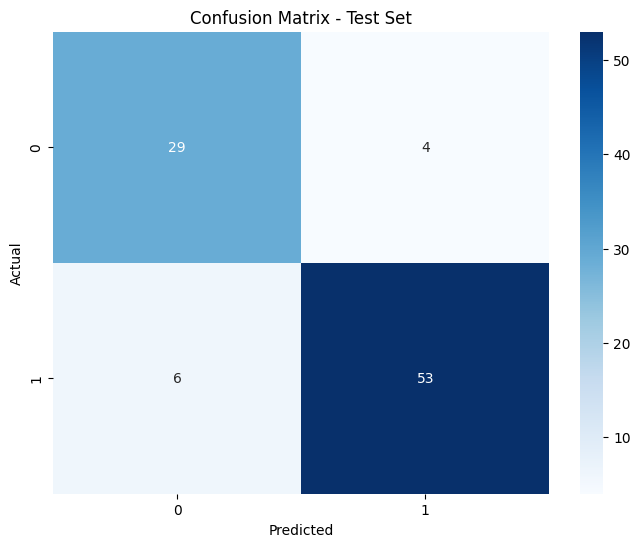

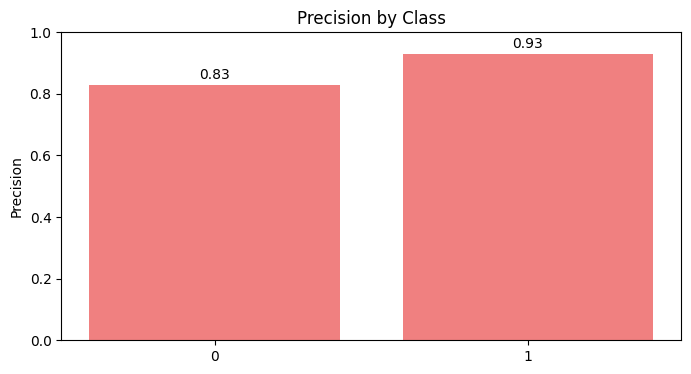

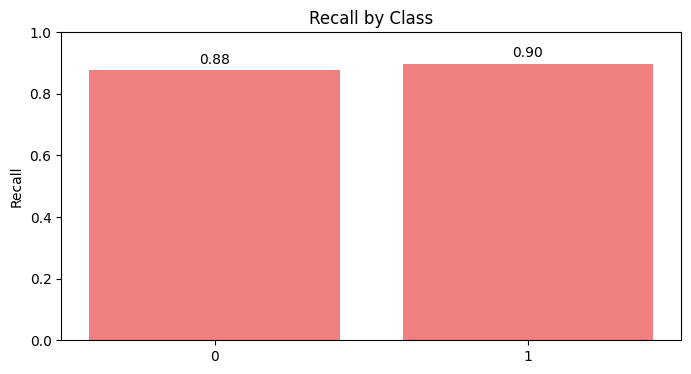

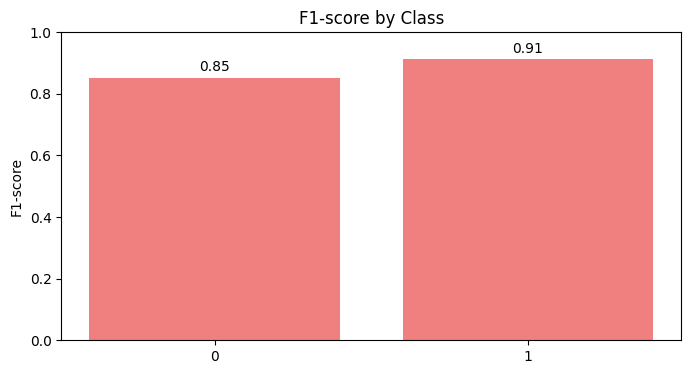

Scenario dataset_scenario_5_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 6_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running SVM with grid for dataset_scenario_6_N...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_6_N
Best hyperparameters:  {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Validation Metrics:
  Accuracy: 0.8696
  Precision: 0.8711
  Recall: 0.8696
  F1 Score: 0.8699

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


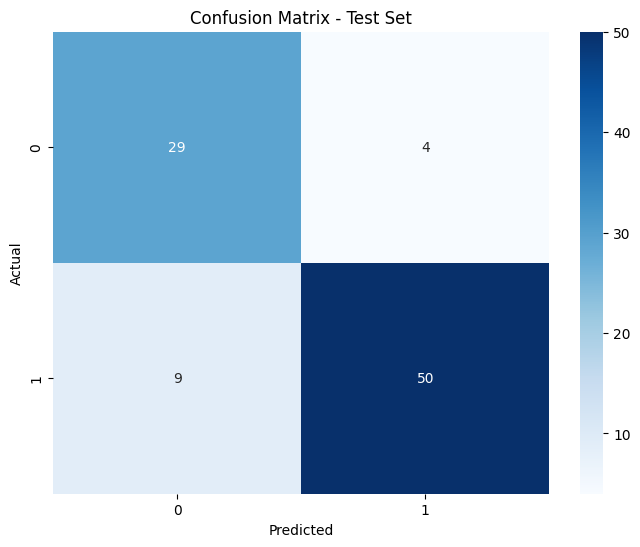

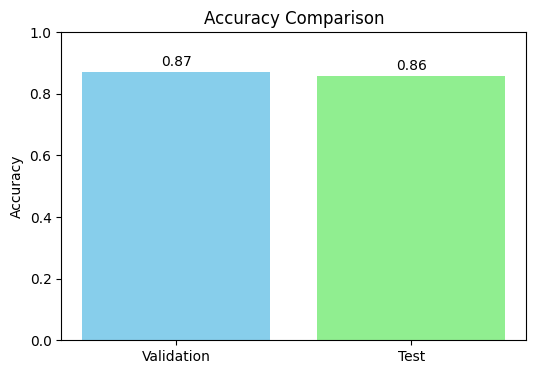

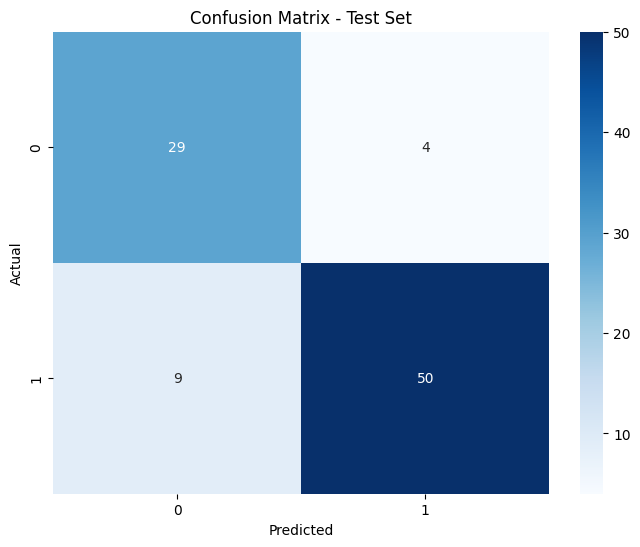

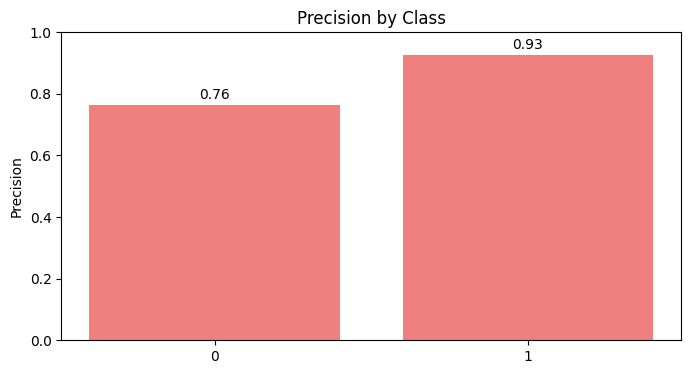

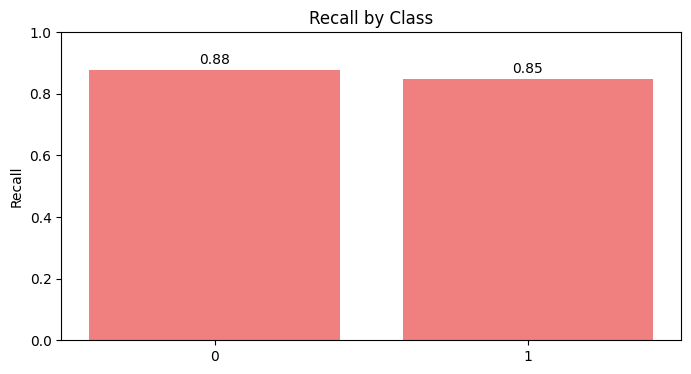

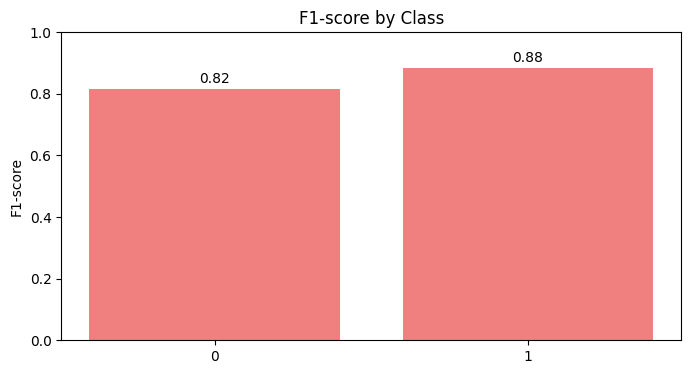

Scenario dataset_scenario_6_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 6_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with grid for dataset_scenario_6_S...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_6_S
Best hyperparameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8696
  Precision: 0.8711
  Recall: 0.8696
  F1 Score: 0.8699

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8630
  Recall: 0.8587
  F1 Score: 0.8599

Confusion Matrix (Test Set):
[[28  5]
 [ 8 51]]


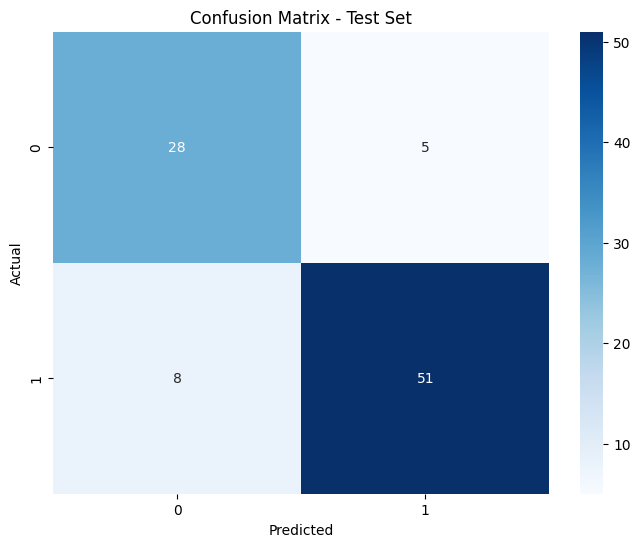

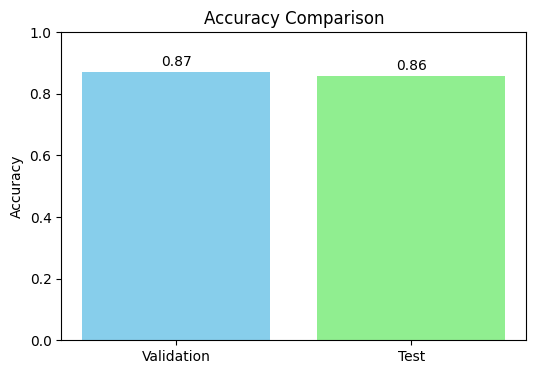

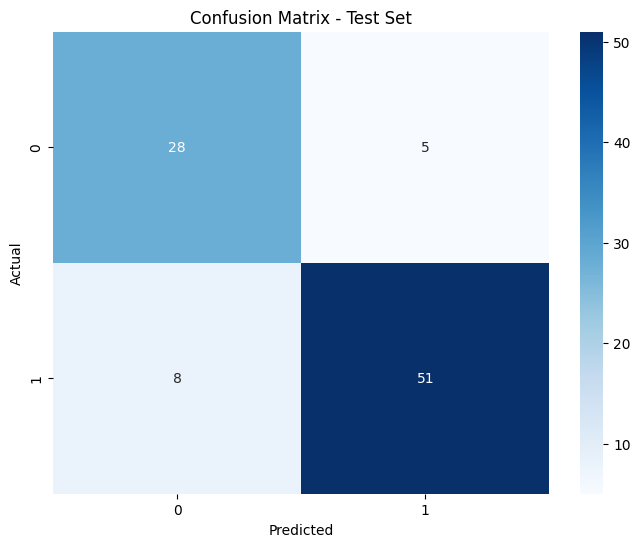

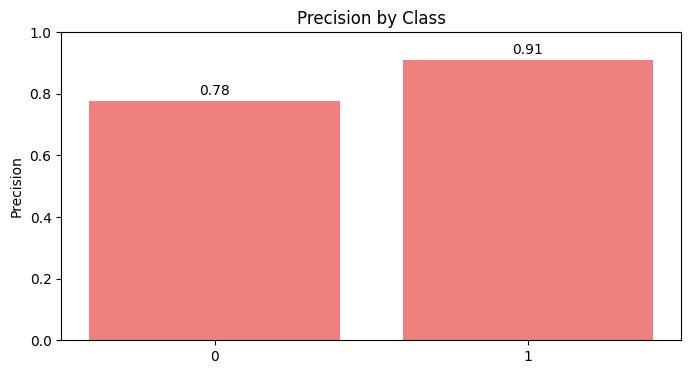

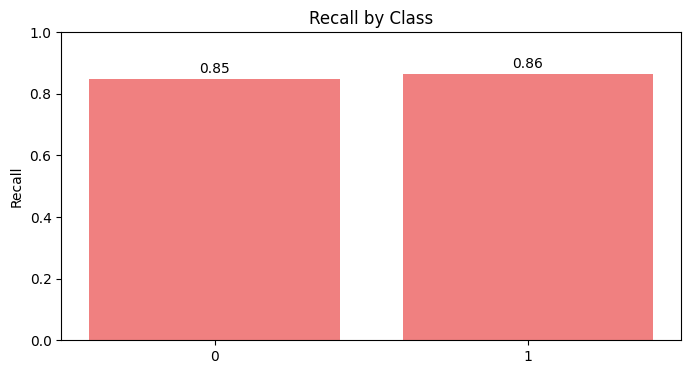

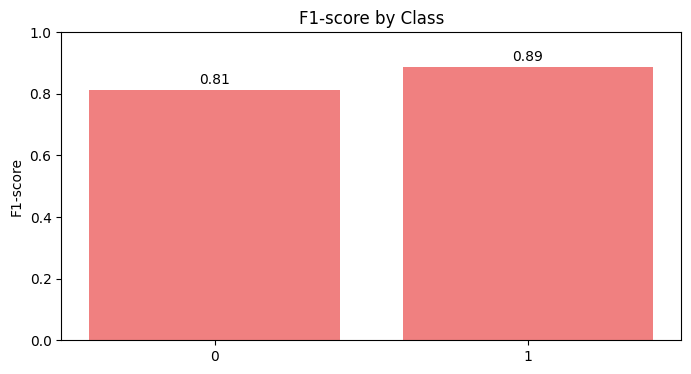

Scenario dataset_scenario_6_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 7_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with grid for dataset_scenario_7_N...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_7_N
Best hyperparameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}
Validation Metrics:
  Accuracy: 0.8571
  Precision: 0.8578
  Recall: 0.8571
  F1 Score: 0.8573

Test Metrics:
  Accuracy: 0.7746
  Precision: 0.8052
  Recall: 0.7746
  F1 Score: 0.7742

Confusion Matrix (Test Set):
[[27 13]
 [ 3 28]]


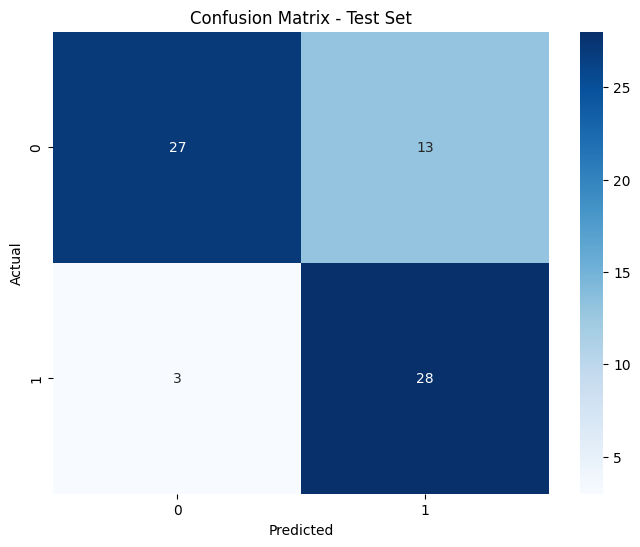

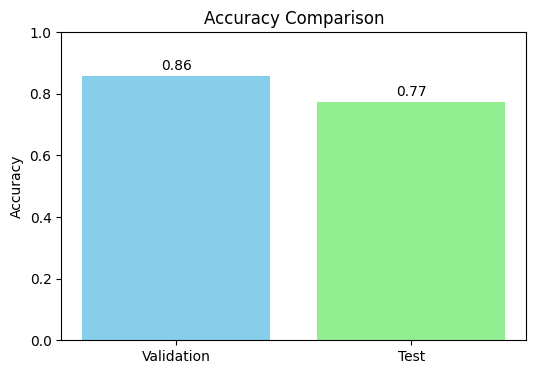

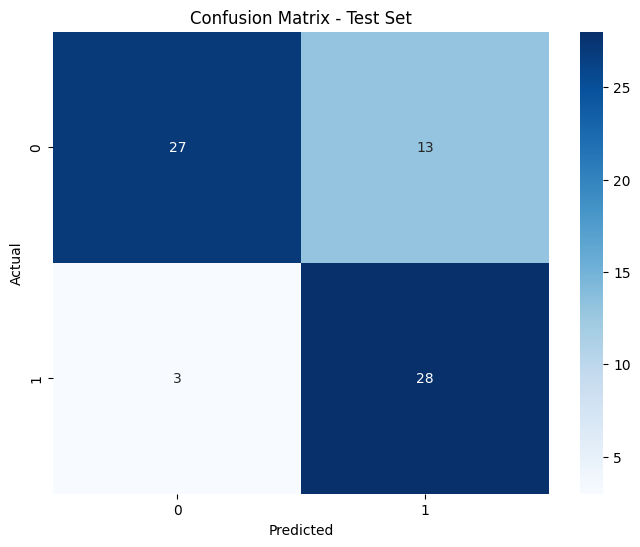

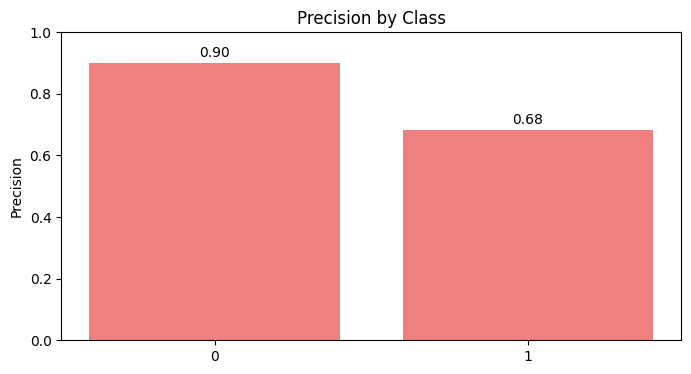

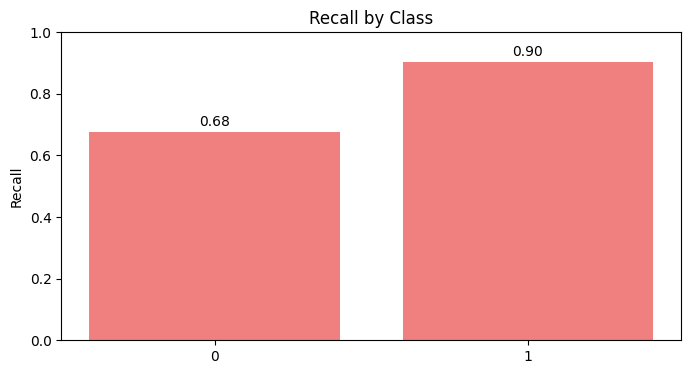

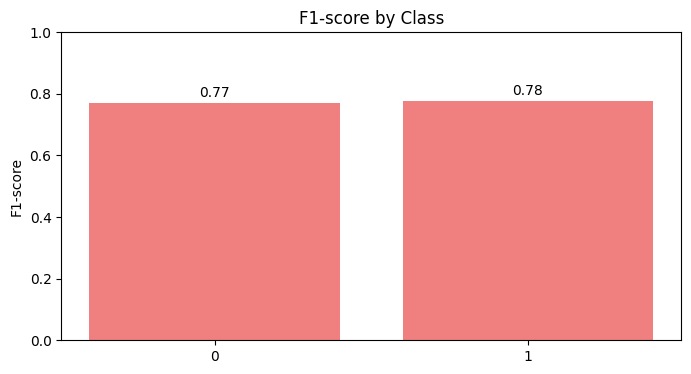

Scenario dataset_scenario_7_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 7_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with grid for dataset_scenario_7_S...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_7_S
Best hyperparameters:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Validation Metrics:
  Accuracy: 0.8714
  Precision: 0.8721
  Recall: 0.8714
  F1 Score: 0.8716

Test Metrics:
  Accuracy: 0.8028
  Precision: 0.8240
  Recall: 0.8028
  F1 Score: 0.8031

Confusion Matrix (Test Set):
[[29 11]
 [ 3 28]]


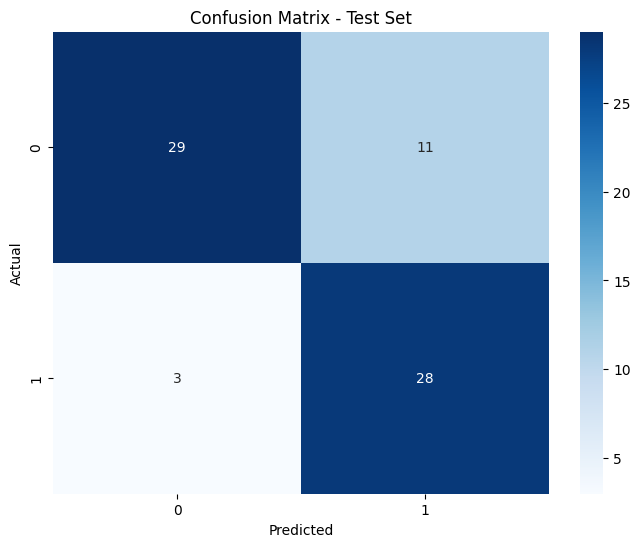

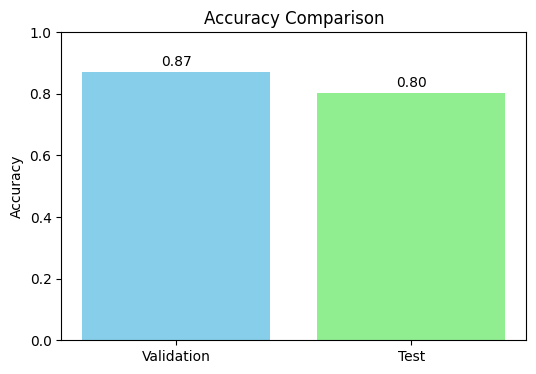

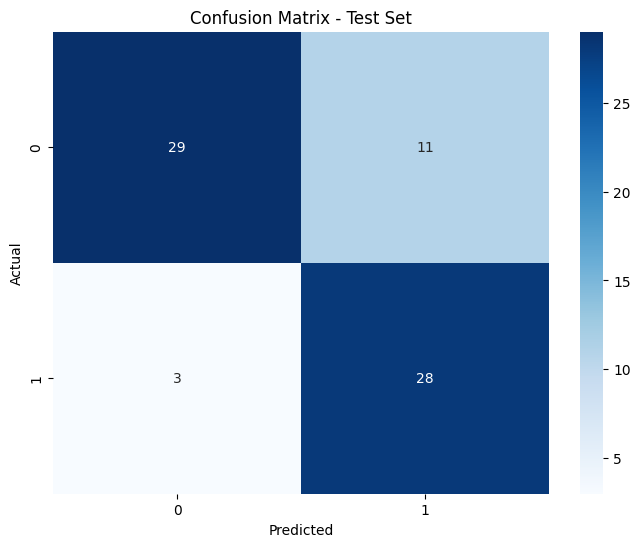

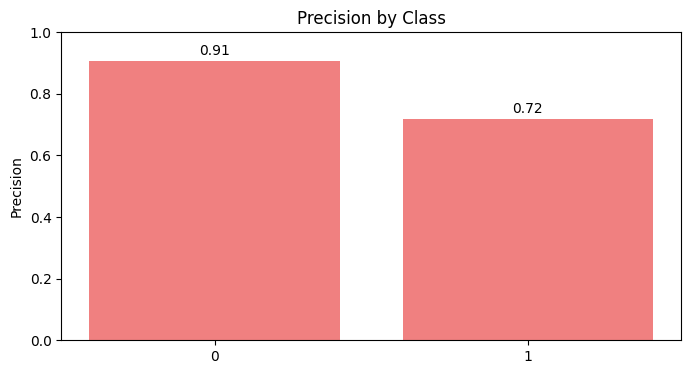

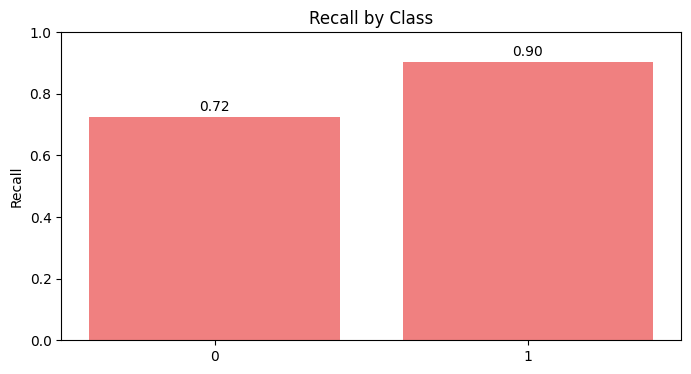

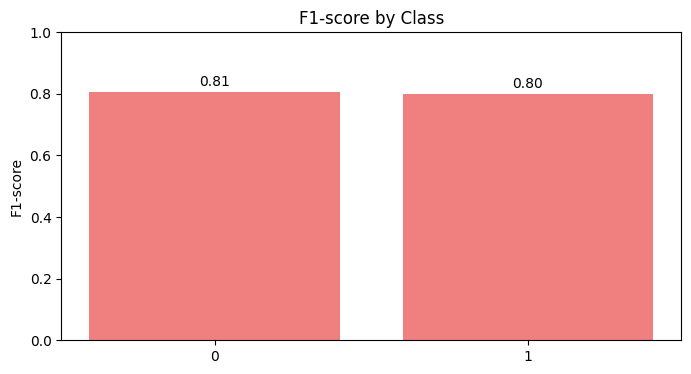

Scenario dataset_scenario_7_S with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 8_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running SVM with grid for dataset_scenario_8_N...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_8_N
Best hyperparameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'poly'}
Validation Metrics:
  Accuracy: 0.8696
  Precision: 0.8696
  Recall: 0.8696
  F1 Score: 0.8696

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


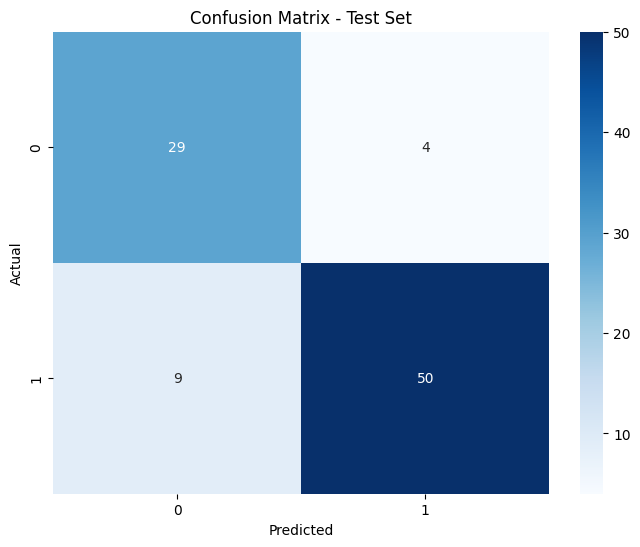

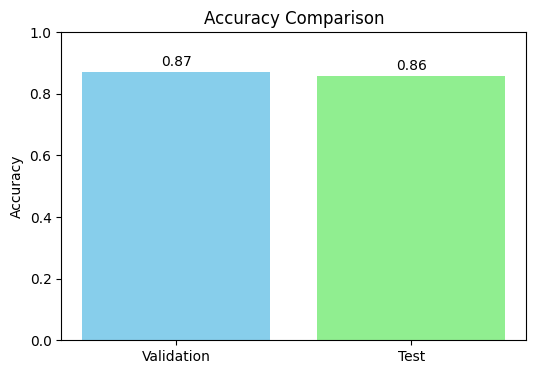

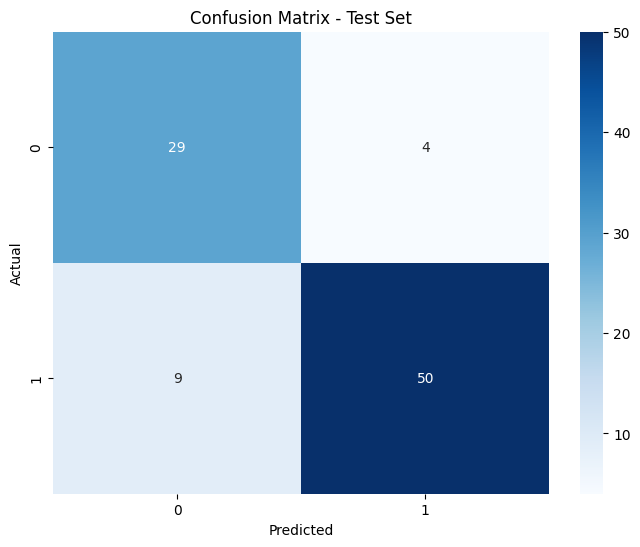

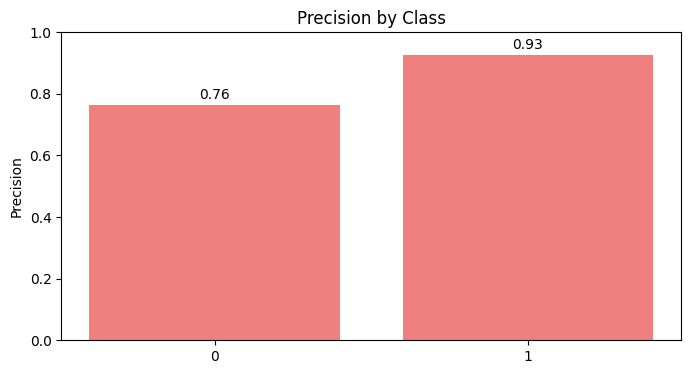

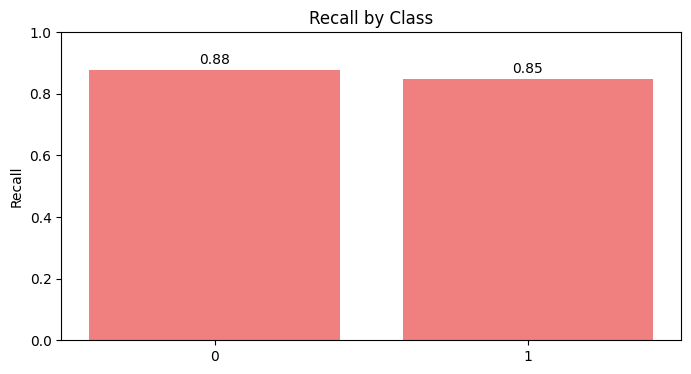

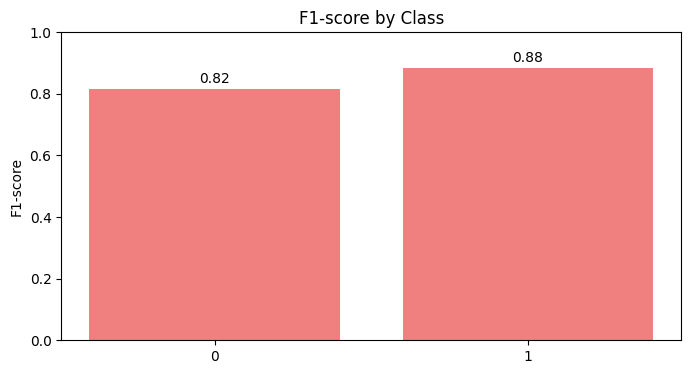

Scenario dataset_scenario_8_N with grid completed and results saved.

----------------------------------------



Scenario Name: Scenario 8_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with grid for dataset_scenario_8_S...
Results will be saved in: SCORES\SVM\grid\dataset_scenario_8_S
Best hyperparameters:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Validation Metrics:
  Accuracy: 0.8641
  Precision: 0.8644
  Recall: 0.8641
  F1 Score: 0.8642

Test Metrics:
  Accuracy: 0.8370
  Precision: 0.8462
  Recall: 0.8370
  F1 Score: 0.8391

Confusion Matrix (Test Set):
[[28  5]
 [10 49]]


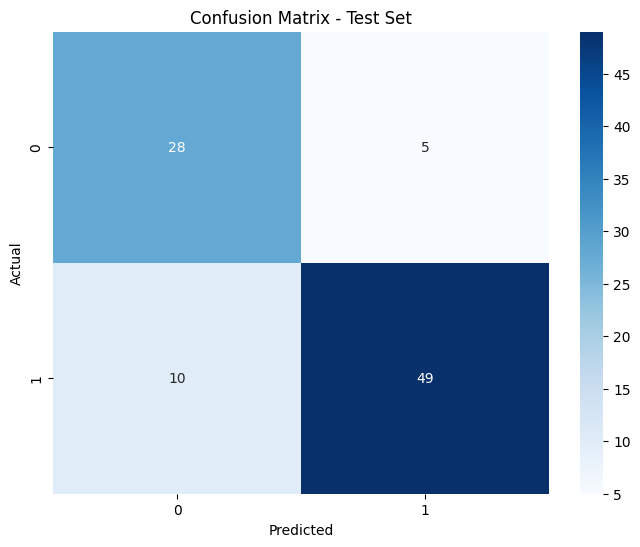

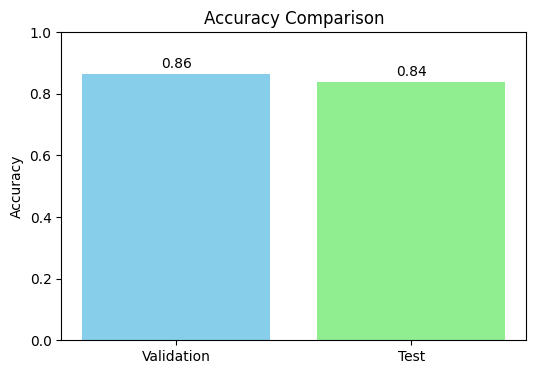

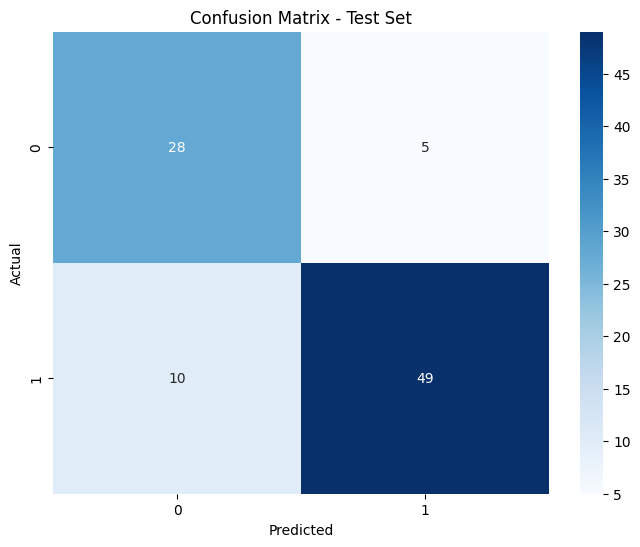

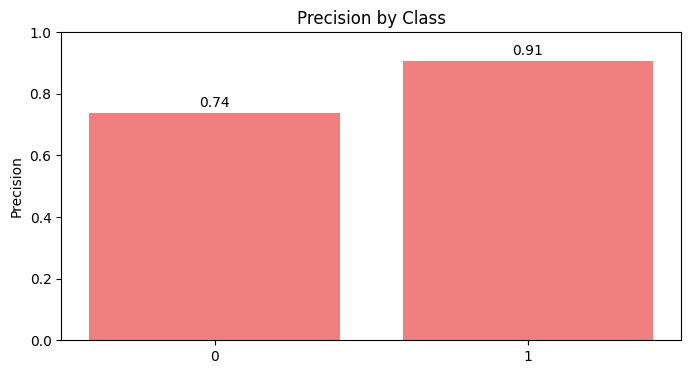

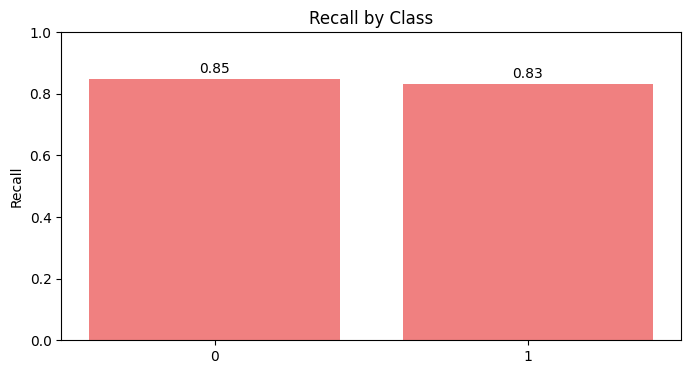

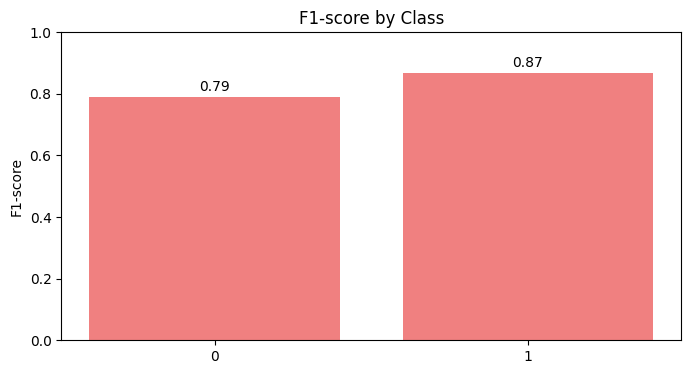

Scenario dataset_scenario_8_S with grid completed and results saved.

----------------------------------------





In [12]:
for scenario, scenario_description in zip(scenario_datasets, scenarios_description):
    print(f"Scenario Name: {scenario_description['name']}")
    print(f"  Encoding: {scenario_description['encoding']}")
    print(f"  Remove Outliers: {scenario_description['remove_outliers']}")
    print(f"  Remove Errors: {scenario_description.get('remove_errors', 'Not Specified')}")
    print(f"  Impute Zeros: {scenario_description.get('impute_zeros', 'None')}")
    print(f"  Oldpeak Absolute: {scenario_description.get('oldpeak_abs', 'Not Specified')}")
    print(f"  Scaling: {scenario_description['scaling']}")

    run_scenario(scenario, "SVM", "grid", search_config_grid, get_search_hyperparameters("SVM"))

    print("-" * 40)
    print("\n\n")

## 2. Random Search

Scenario Name: Scenario 1_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with random for dataset_scenario_1_N...
Results will be saved in: SCORES\SVM\random\dataset_scenario_1_N
Best hyperparameters:  {'kernel': 'poly', 'gamma': 1, 'C': 0.1}
Validation Metrics:
  Accuracy: 0.8750
  Precision: 0.8760
  Recall: 0.8750
  F1 Score: 0.8753

Test Metrics:
  Accuracy: 0.8913
  Precision: 0.8935
  Recall: 0.8913
  F1 Score: 0.8920

Confusion Matrix (Test Set):
[[29  4]
 [ 6 53]]


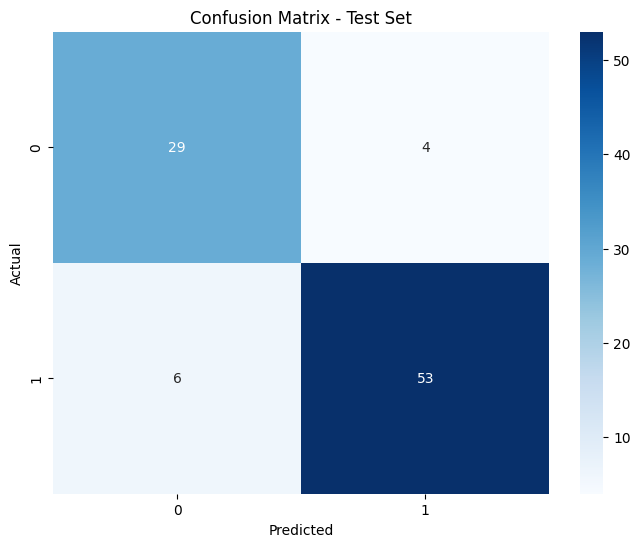

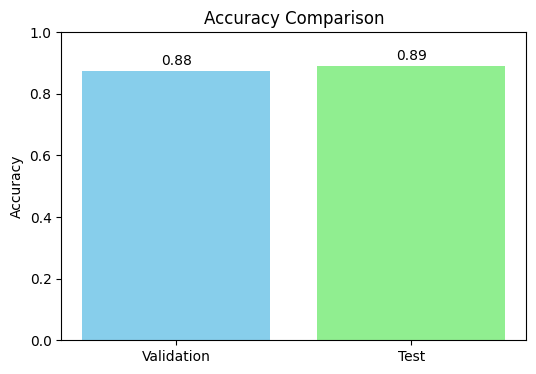

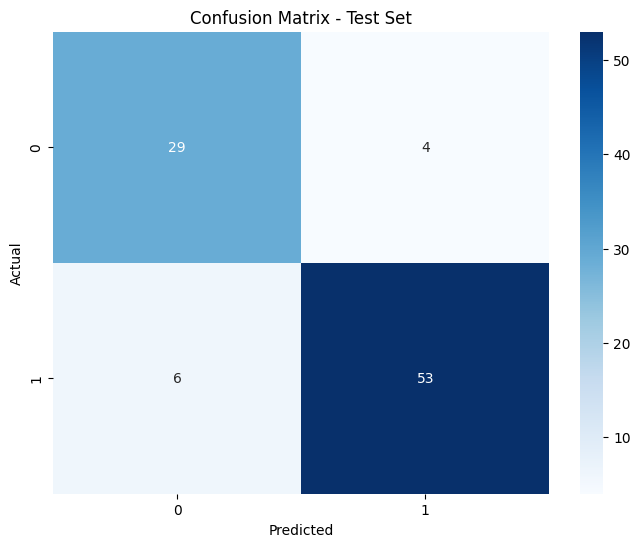

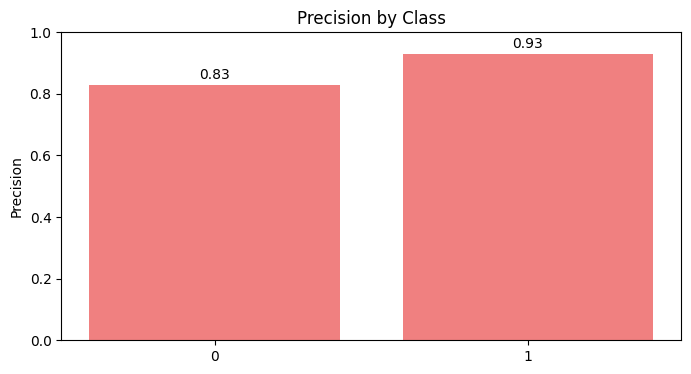

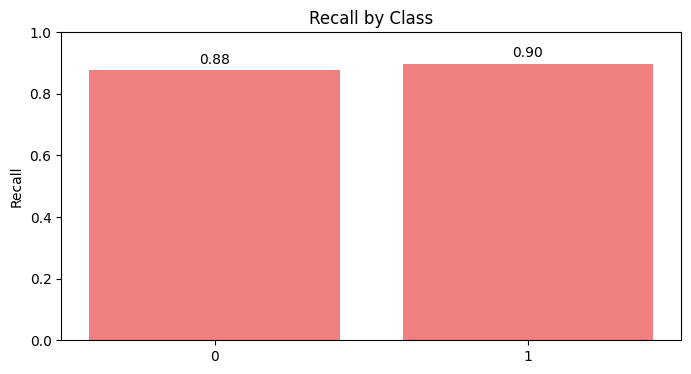

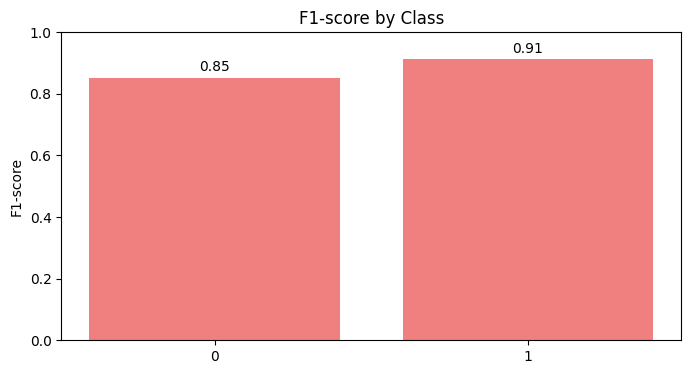

Scenario dataset_scenario_1_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 1_S
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with random for dataset_scenario_1_S...
Results will be saved in: SCORES\SVM\random\dataset_scenario_1_S
Best hyperparameters:  {'kernel': 'rbf', 'gamma': 0.01, 'C': 100}
Validation Metrics:
  Accuracy: 0.8859
  Precision: 0.8893
  Recall: 0.8859
  F1 Score: 0.8863

Test Metrics:
  Accuracy: 0.9130
  Precision: 0.9185
  Recall: 0.9130
  F1 Score: 0.9140

Confusion Matrix (Test Set):
[[31  2]
 [ 6 53]]


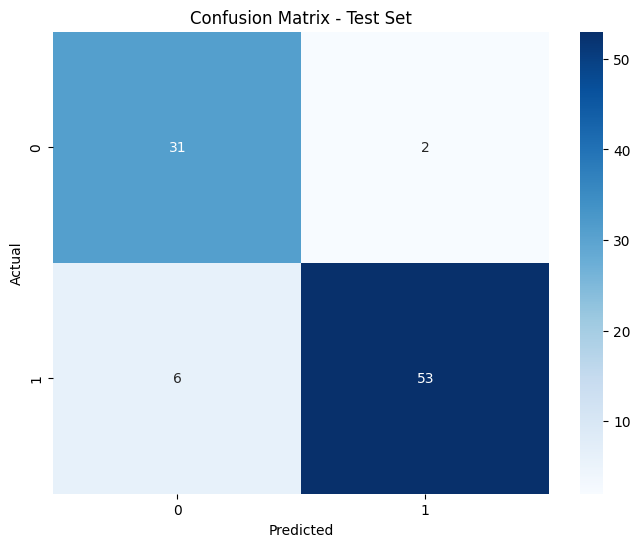

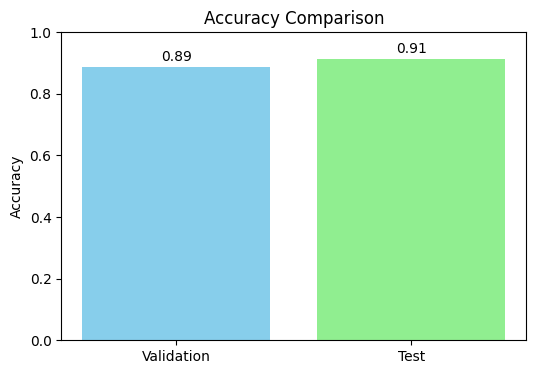

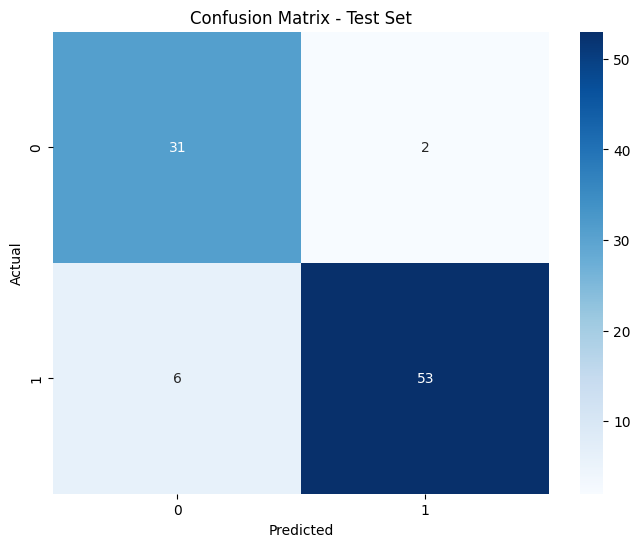

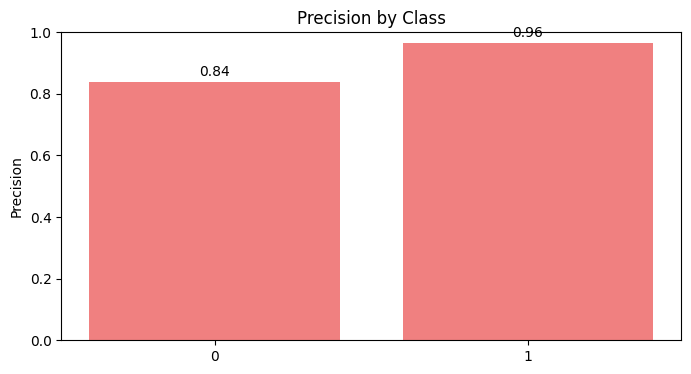

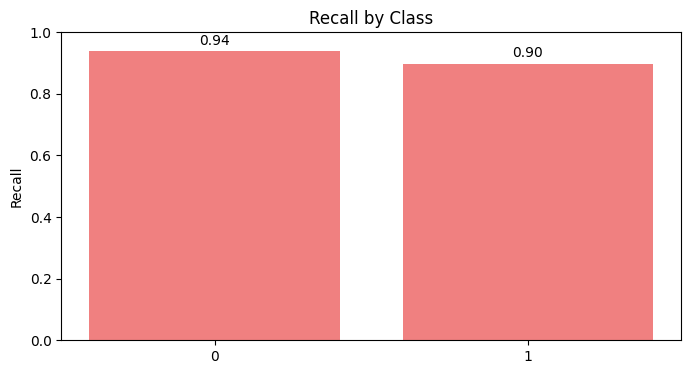

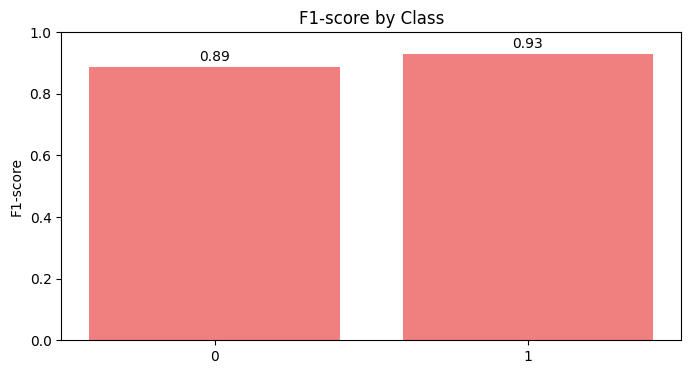

Scenario dataset_scenario_1_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 2_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: {'RestingBP': 'mean', 'Cholesterol': 'mean'}
  Oldpeak Absolute: True
  Scaling: MinMax
Running SVM with random for dataset_scenario_2_N...
Results will be saved in: SCORES\SVM\random\dataset_scenario_2_N
Best hyperparameters:  {'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}
Validation Metrics:
  Accuracy: 0.8533
  Precision: 0.8569
  Recall: 0.8533
  F1 Score: 0.8538

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


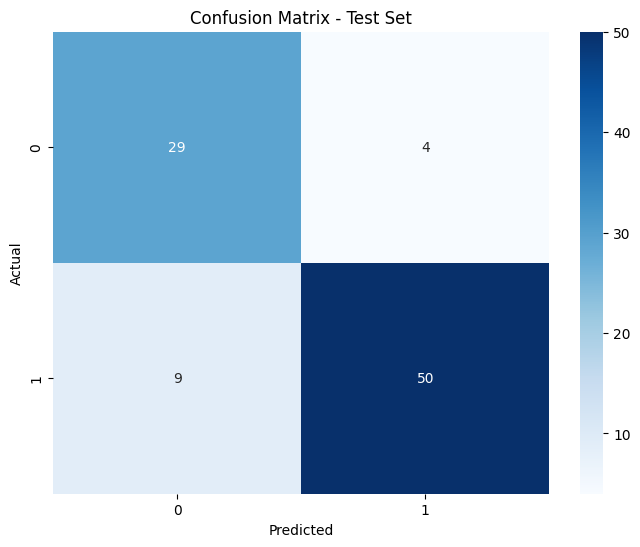

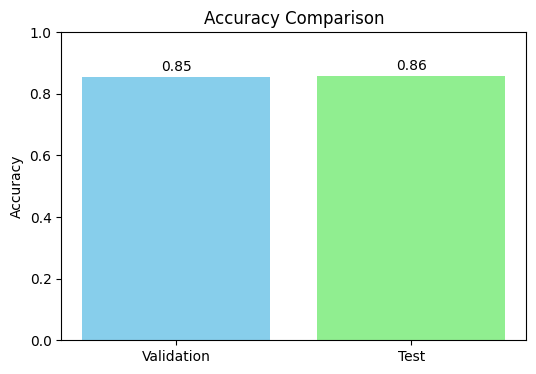

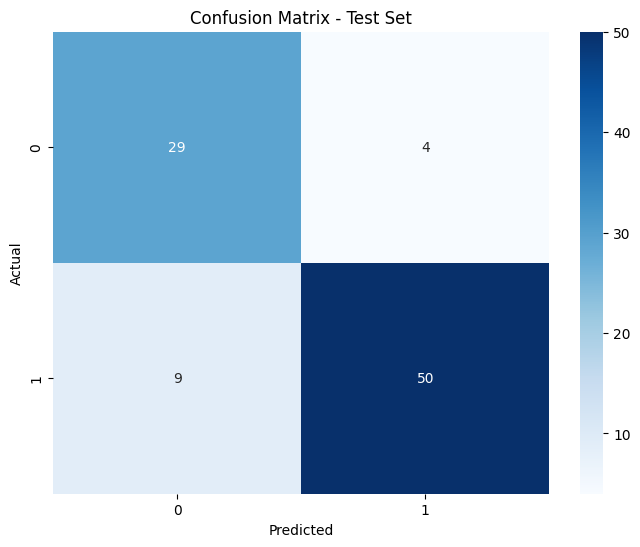

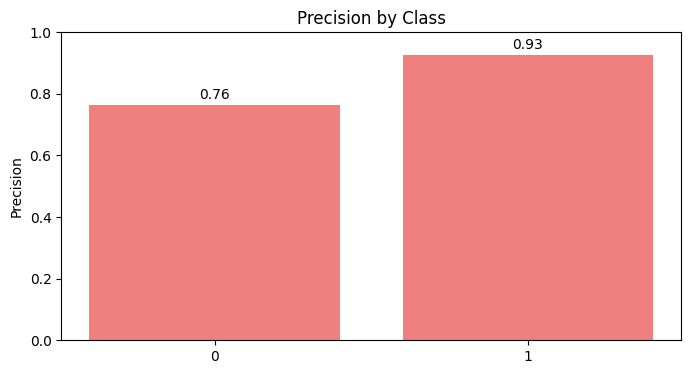

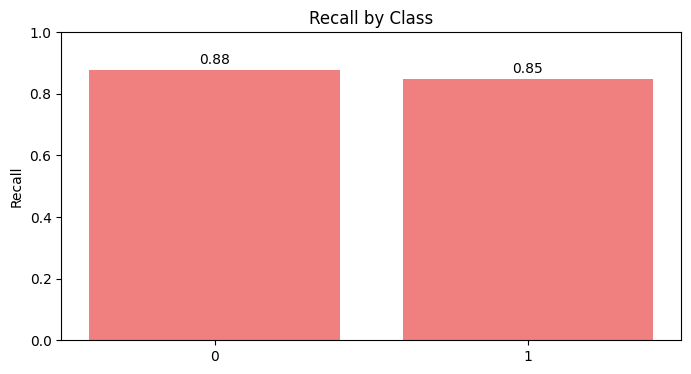

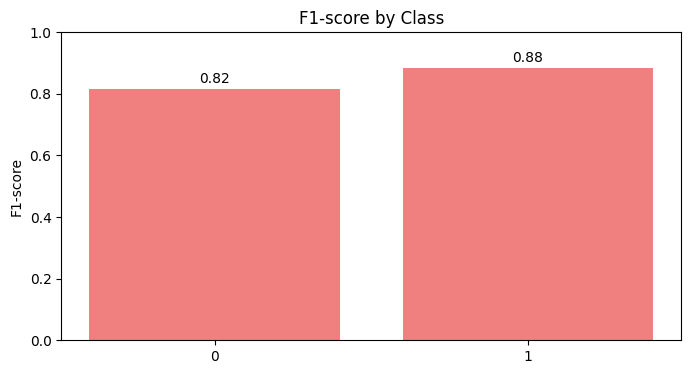

Scenario dataset_scenario_2_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 2_S
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: {'RestingBP': 'mean', 'Cholesterol': 'mean'}
  Oldpeak Absolute: True
  Scaling: Standard
Running SVM with random for dataset_scenario_2_S...
Results will be saved in: SCORES\SVM\random\dataset_scenario_2_S
Best hyperparameters:  {'kernel': 'linear', 'gamma': 1, 'C': 100}
Validation Metrics:
  Accuracy: 0.8533
  Precision: 0.8569
  Recall: 0.8533
  F1 Score: 0.8538

Test Metrics:
  Accuracy: 0.8696
  Precision: 0.8758
  Recall: 0.8696
  F1 Score: 0.8710

Confusion Matrix (Test Set):
[[29  4]
 [ 8 51]]


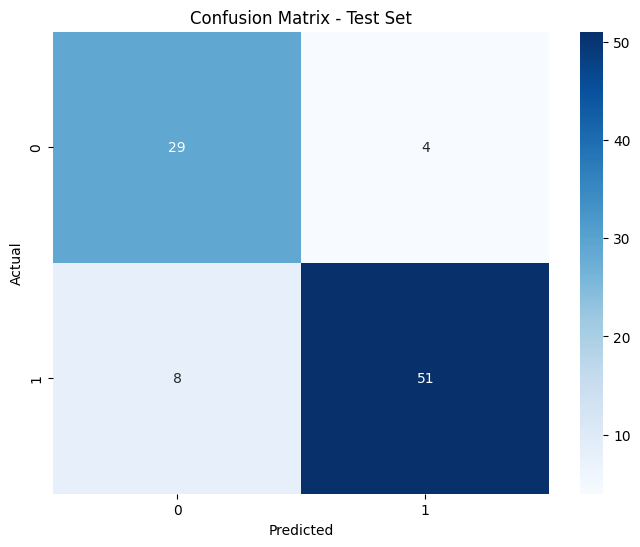

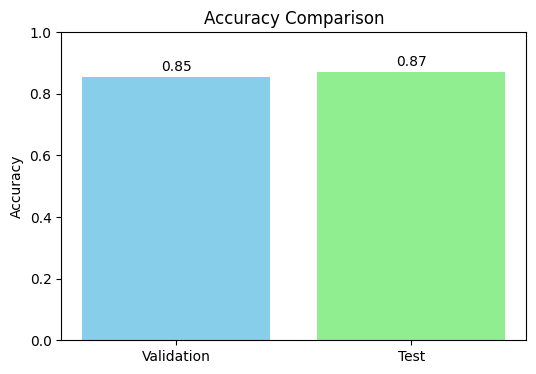

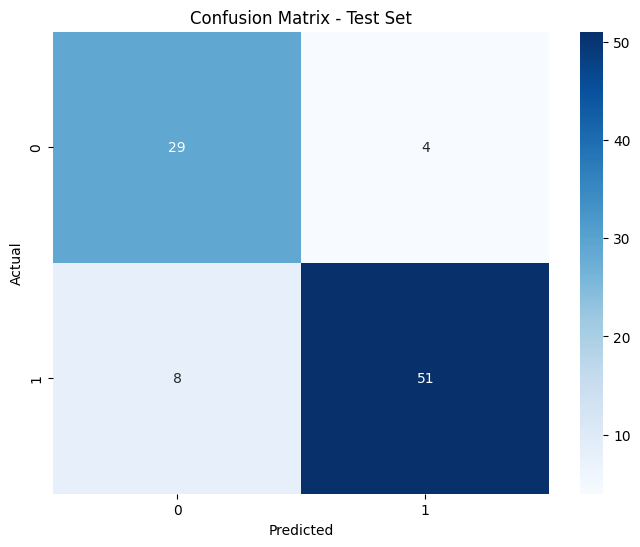

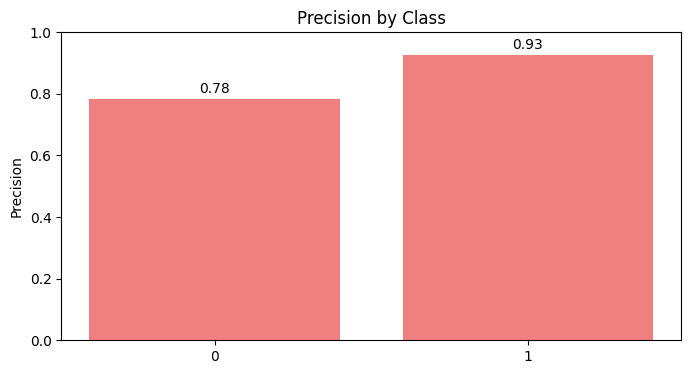

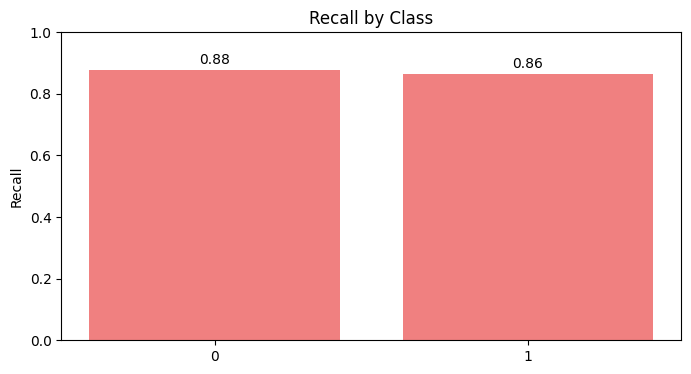

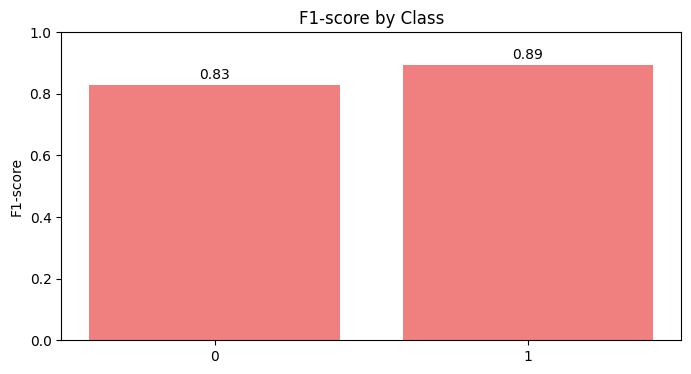

Scenario dataset_scenario_2_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 3_N
  Encoding: Label encoding
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running SVM with random for dataset_scenario_3_N...
Results will be saved in: SCORES\SVM\random\dataset_scenario_3_N
Best hyperparameters:  {'kernel': 'poly', 'gamma': 1, 'C': 0.1}
Validation Metrics:
  Accuracy: 0.8714
  Precision: 0.8734
  Recall: 0.8714
  F1 Score: 0.8717

Test Metrics:
  Accuracy: 0.8028
  Precision: 0.8240
  Recall: 0.8028
  F1 Score: 0.8031

Confusion Matrix (Test Set):
[[29 11]
 [ 3 28]]


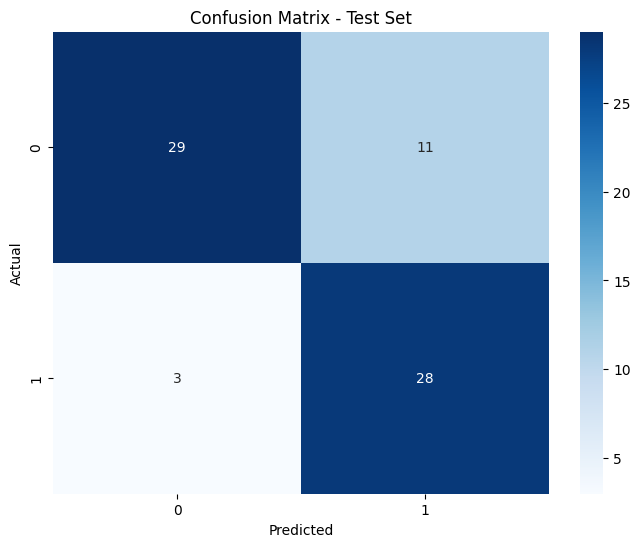

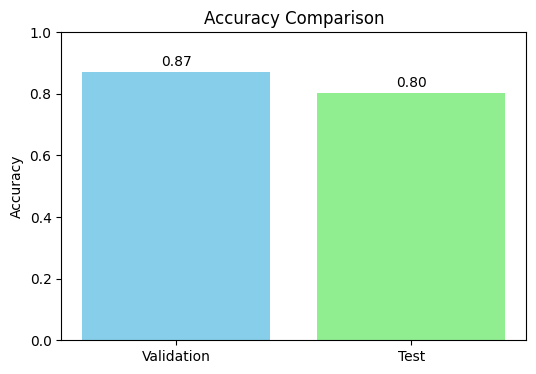

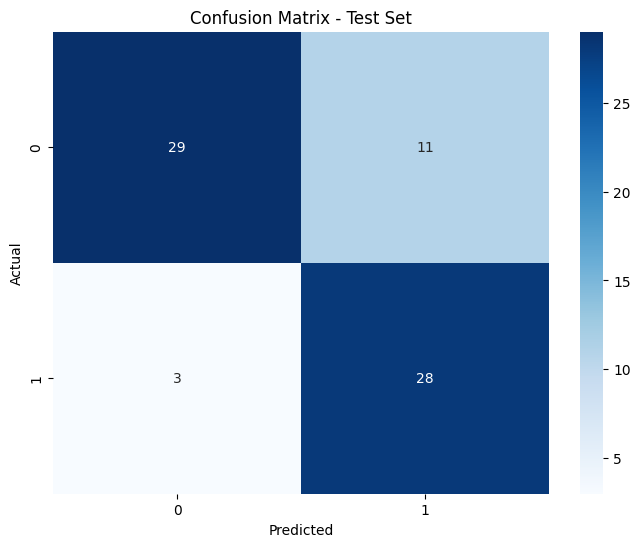

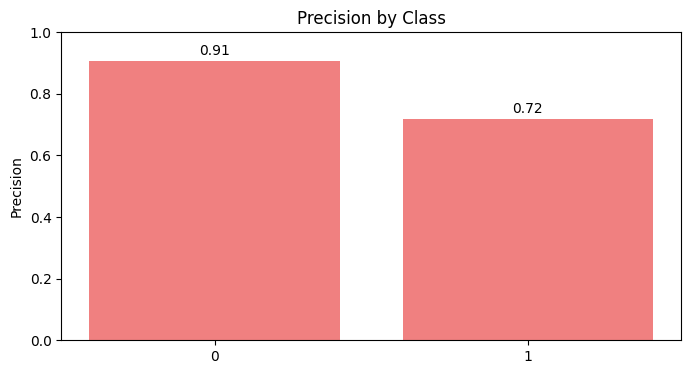

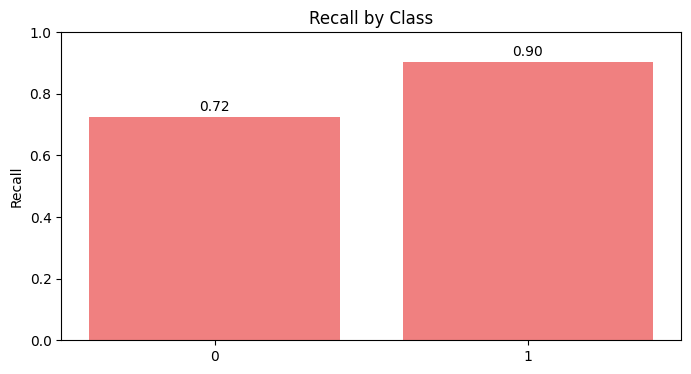

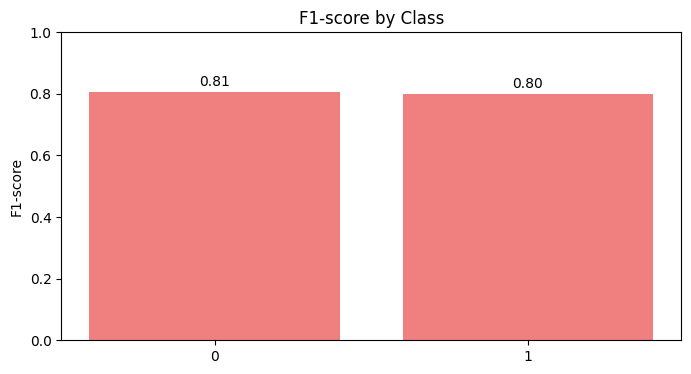

Scenario dataset_scenario_3_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 3_S
  Encoding: Label encoding
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with random for dataset_scenario_3_S...
Results will be saved in: SCORES\SVM\random\dataset_scenario_3_S
Best hyperparameters:  {'kernel': 'sigmoid', 'gamma': 0.01, 'C': 1}
Validation Metrics:
  Accuracy: 0.8643
  Precision: 0.8642
  Recall: 0.8643
  F1 Score: 0.8642

Test Metrics:
  Accuracy: 0.7887
  Precision: 0.7982
  Recall: 0.7887
  F1 Score: 0.7896

Confusion Matrix (Test Set):
[[30 10]
 [ 5 26]]


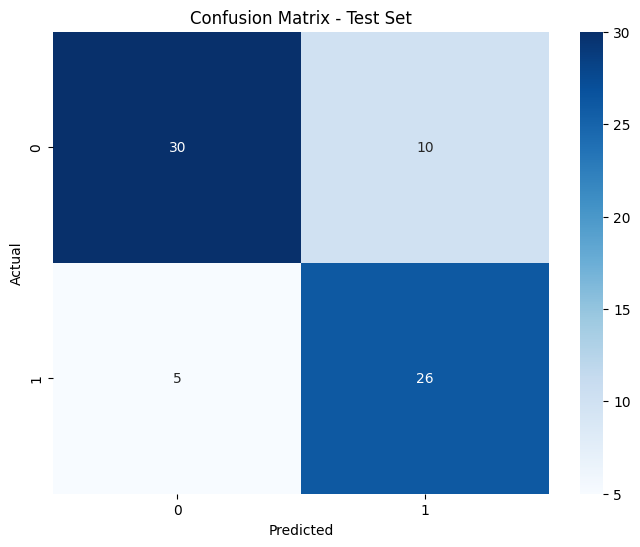

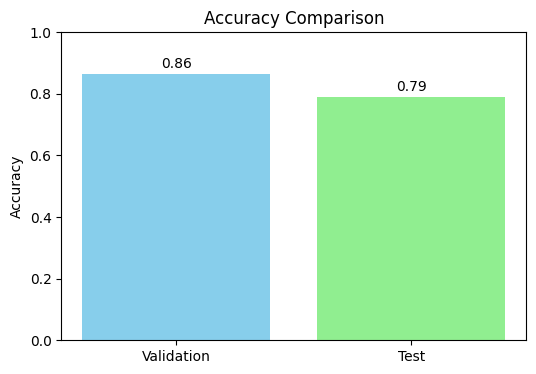

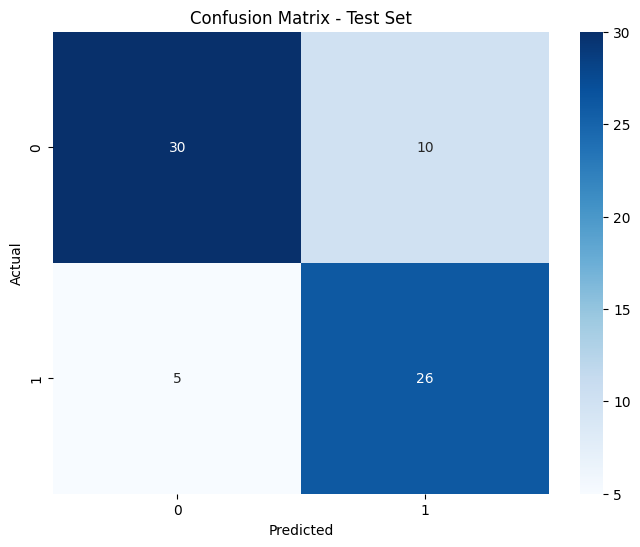

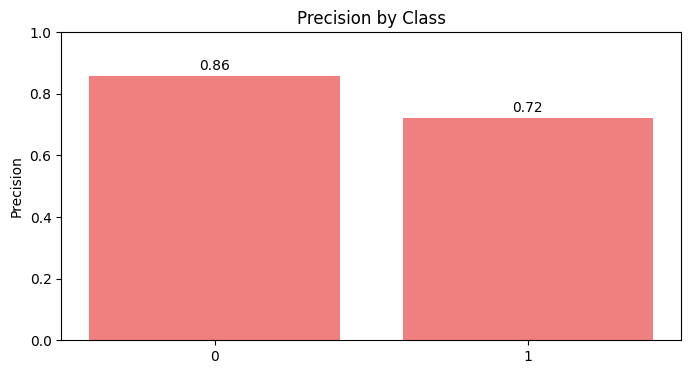

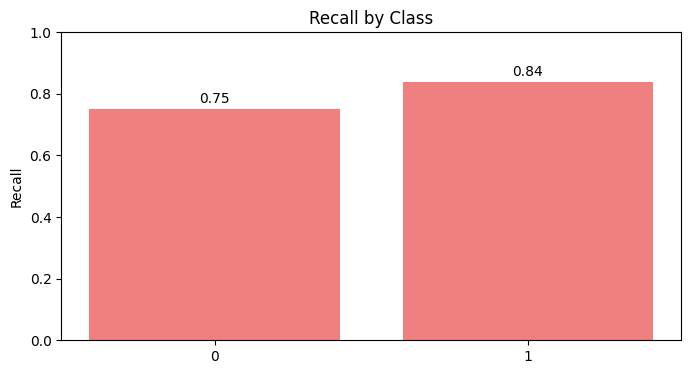

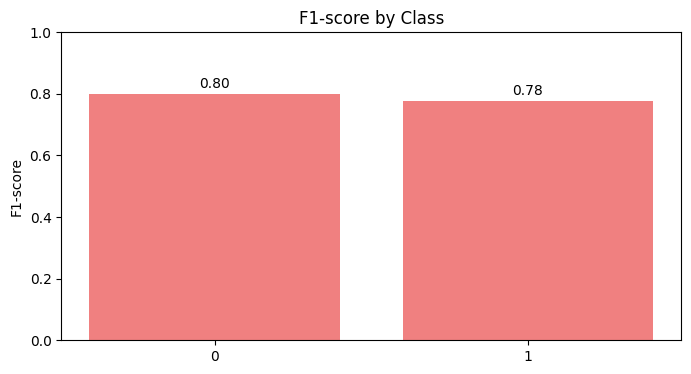

Scenario dataset_scenario_3_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 4_N
  Encoding: Label encoding
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with random for dataset_scenario_4_N...
Results will be saved in: SCORES\SVM\random\dataset_scenario_4_N
Best hyperparameters:  {'kernel': 'rbf', 'gamma': 1, 'C': 1}
Validation Metrics:
  Accuracy: 0.8750
  Precision: 0.8748
  Recall: 0.8750
  F1 Score: 0.8749

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8630
  Recall: 0.8587
  F1 Score: 0.8599

Confusion Matrix (Test Set):
[[28  5]
 [ 8 51]]


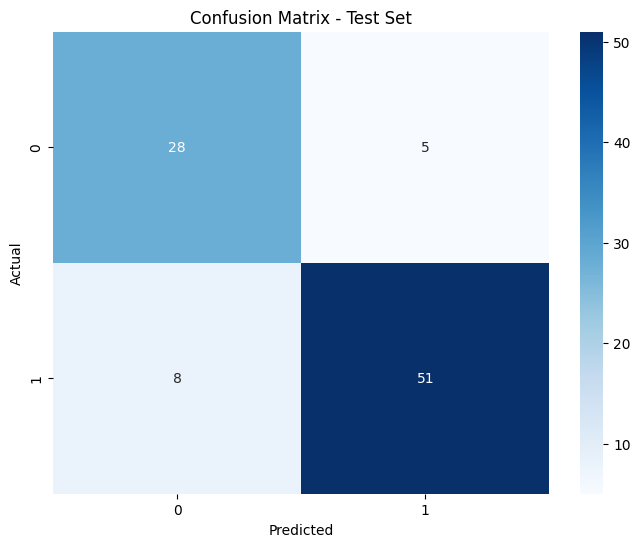

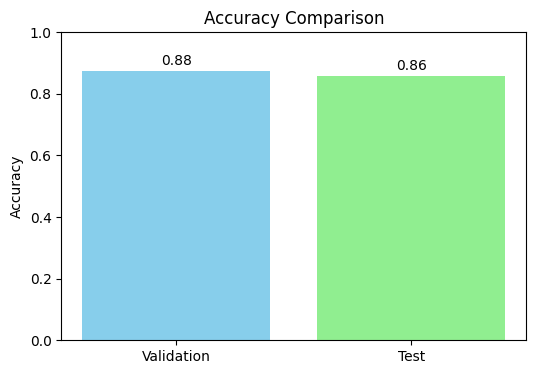

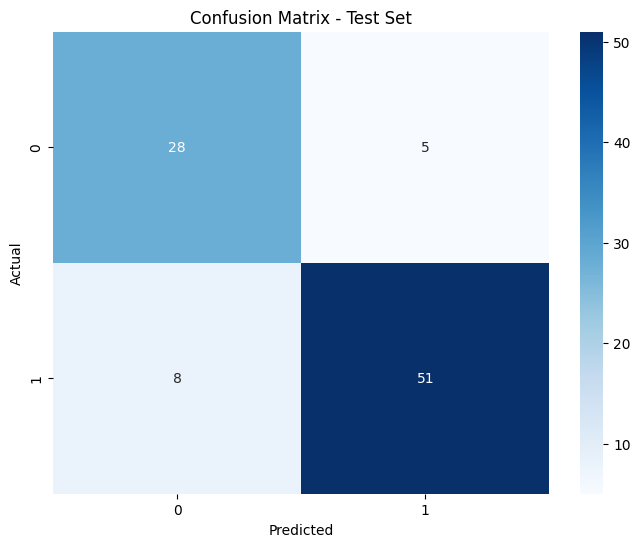

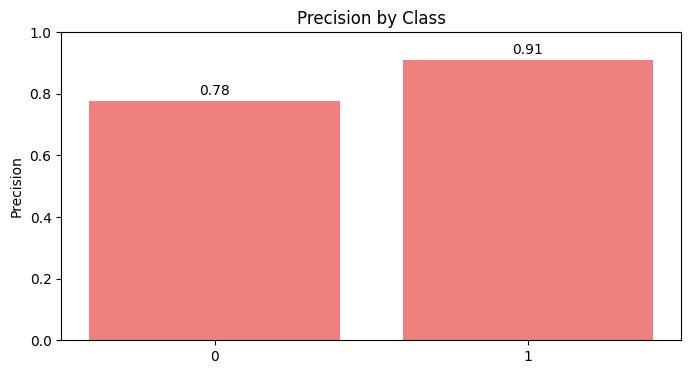

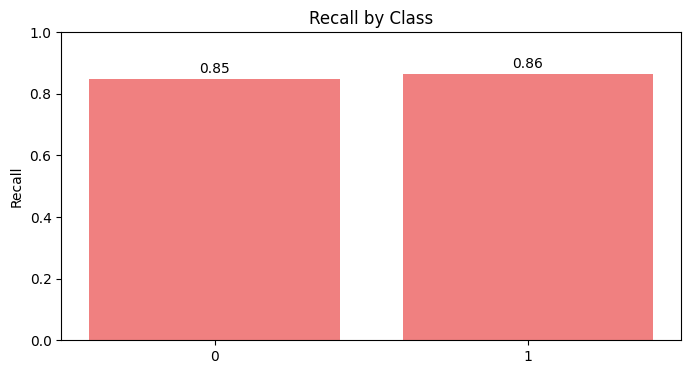

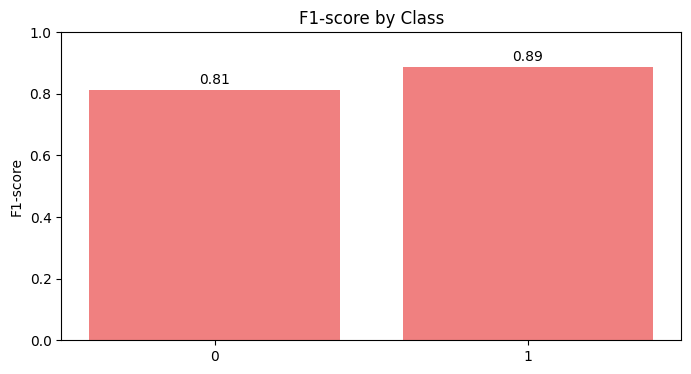

Scenario dataset_scenario_4_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 4_S
  Encoding: Label encoding
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with random for dataset_scenario_4_S...
Results will be saved in: SCORES\SVM\random\dataset_scenario_4_S
Best hyperparameters:  {'kernel': 'linear', 'gamma': 0.01, 'C': 10}
Validation Metrics:
  Accuracy: 0.8533
  Precision: 0.8569
  Recall: 0.8533
  F1 Score: 0.8538

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8596
  Recall: 0.8478
  F1 Score: 0.8501

Confusion Matrix (Test Set):
[[29  4]
 [10 49]]


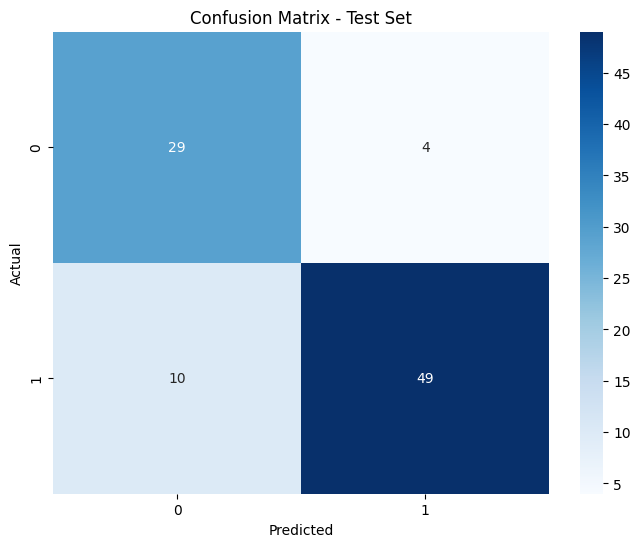

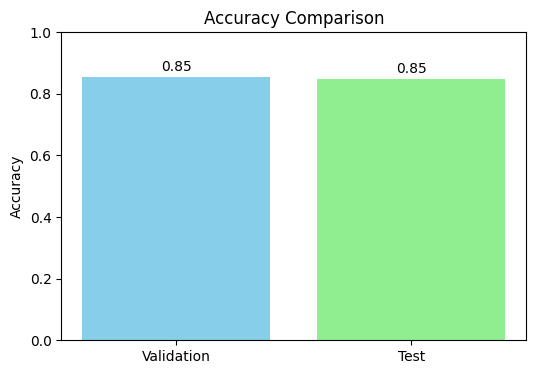

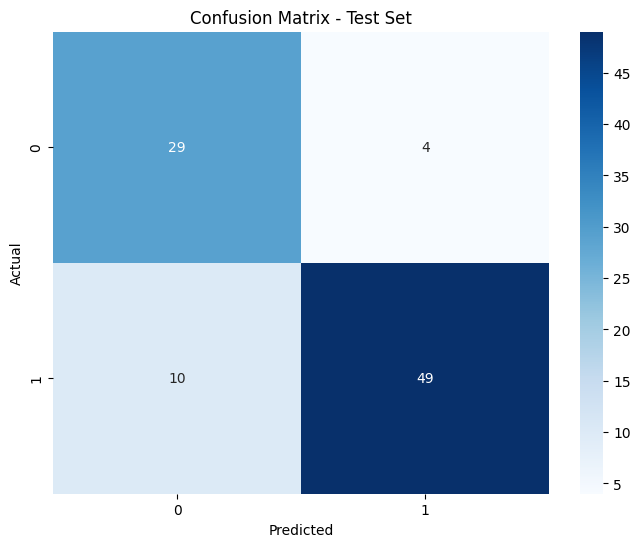

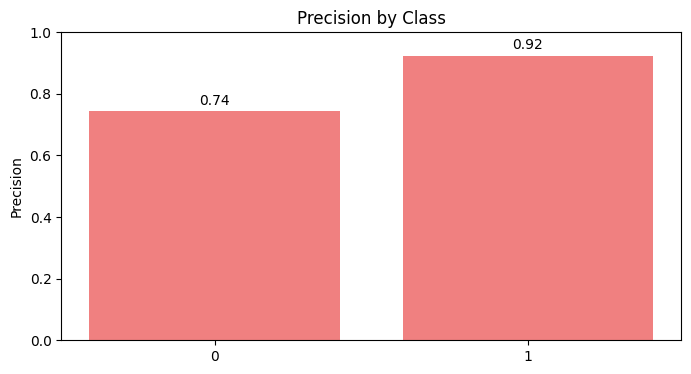

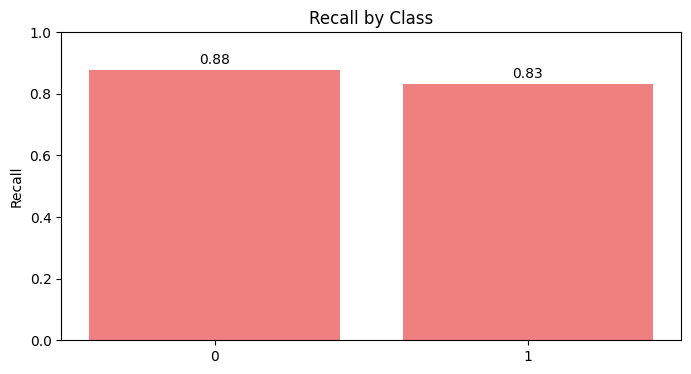

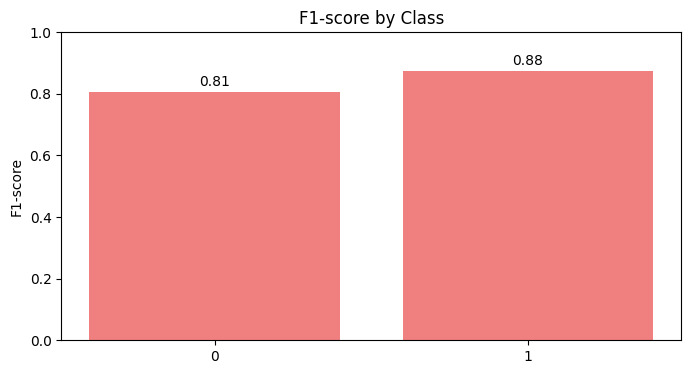

Scenario dataset_scenario_4_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 5_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with random for dataset_scenario_5_N...
Results will be saved in: SCORES\SVM\random\dataset_scenario_5_N
Best hyperparameters:  {'kernel': 'rbf', 'gamma': 1, 'C': 1}
Validation Metrics:
  Accuracy: 0.8641
  Precision: 0.8644
  Recall: 0.8641
  F1 Score: 0.8642

Test Metrics:
  Accuracy: 0.8804
  Precision: 0.8889
  Recall: 0.8804
  F1 Score: 0.8820

Confusion Matrix (Test Set):
[[30  3]
 [ 8 51]]


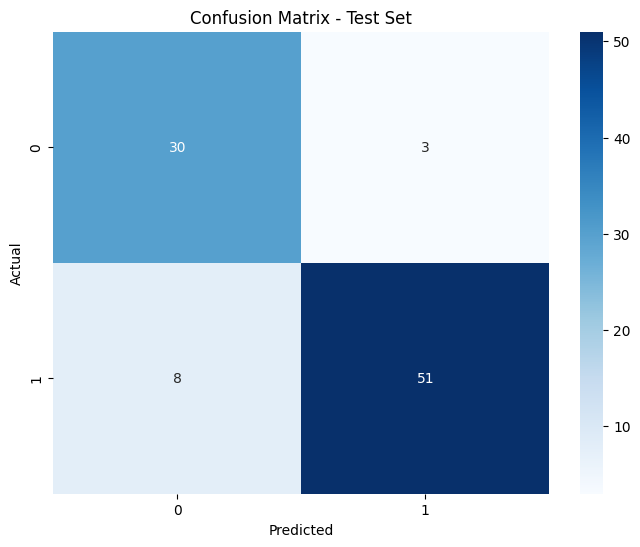

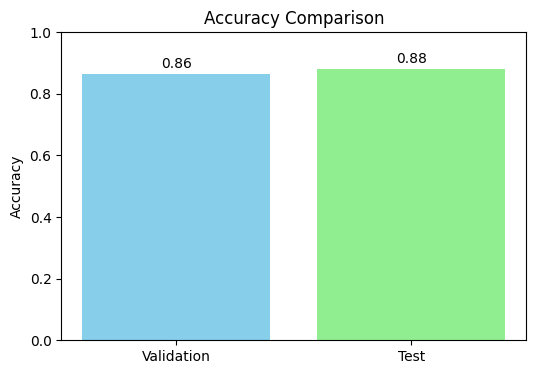

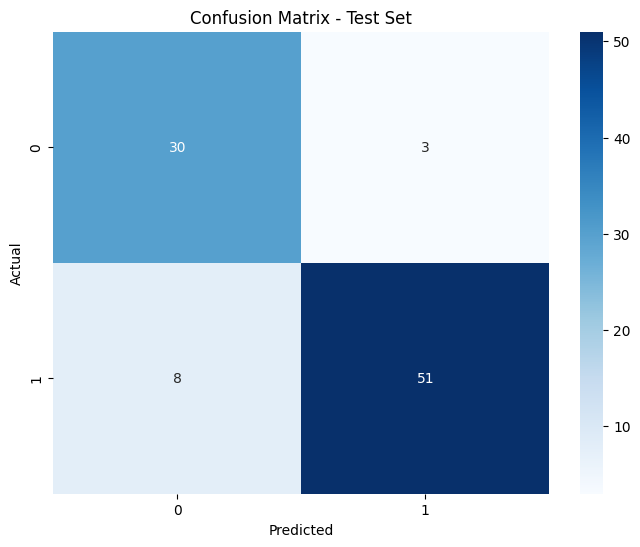

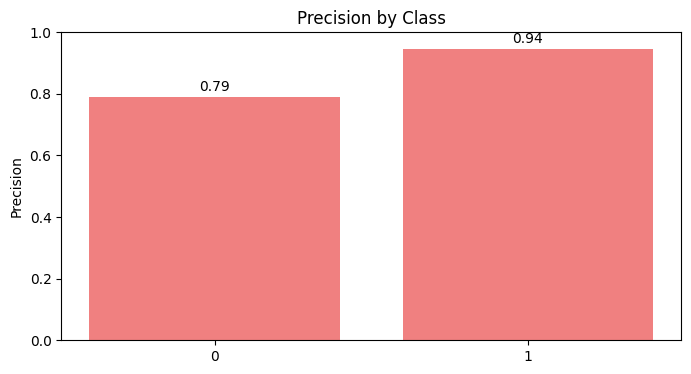

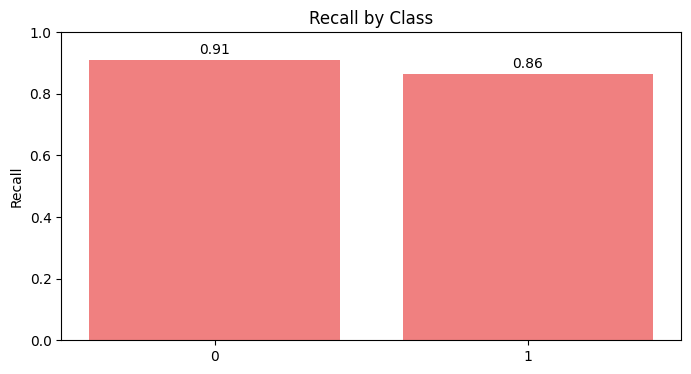

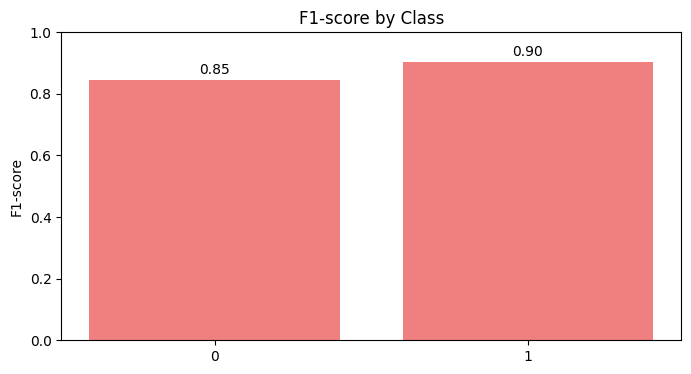

Scenario dataset_scenario_5_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 5_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with random for dataset_scenario_5_S...
Results will be saved in: SCORES\SVM\random\dataset_scenario_5_S
Best hyperparameters:  {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Validation Metrics:
  Accuracy: 0.8804
  Precision: 0.8804
  Recall: 0.8804
  F1 Score: 0.8804

Test Metrics:
  Accuracy: 0.8913
  Precision: 0.8935
  Recall: 0.8913
  F1 Score: 0.8920

Confusion Matrix (Test Set):
[[29  4]
 [ 6 53]]


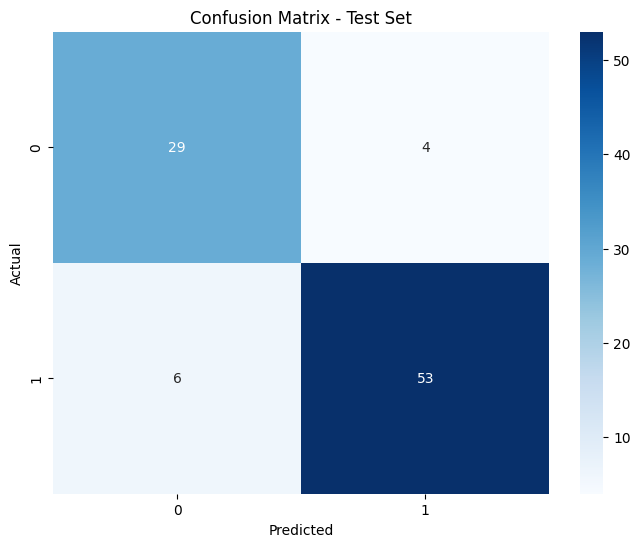

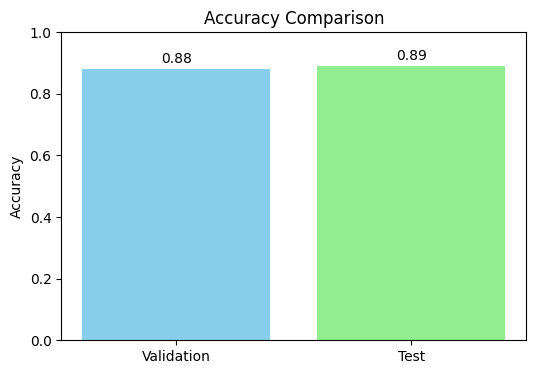

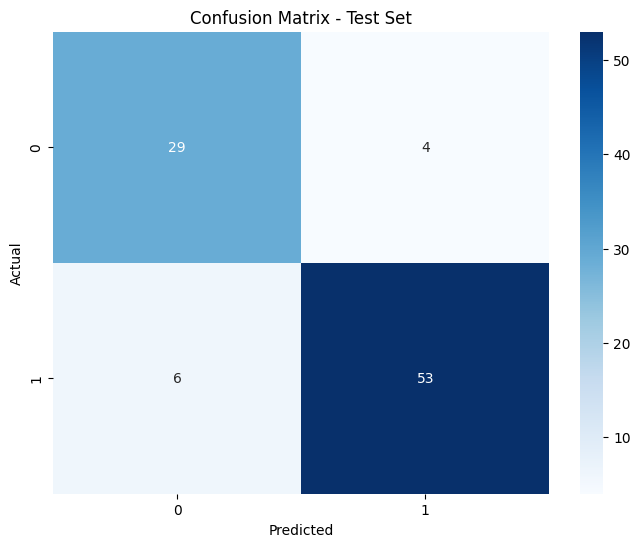

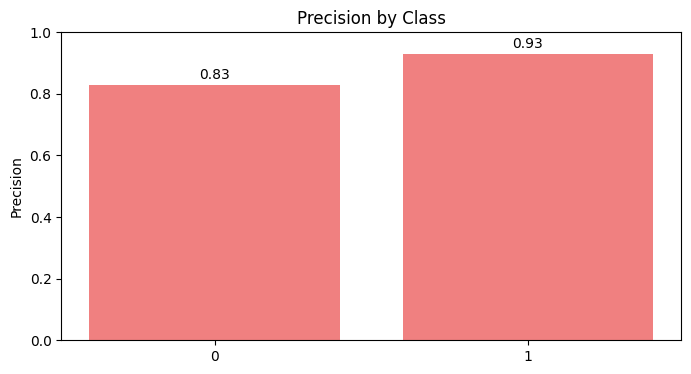

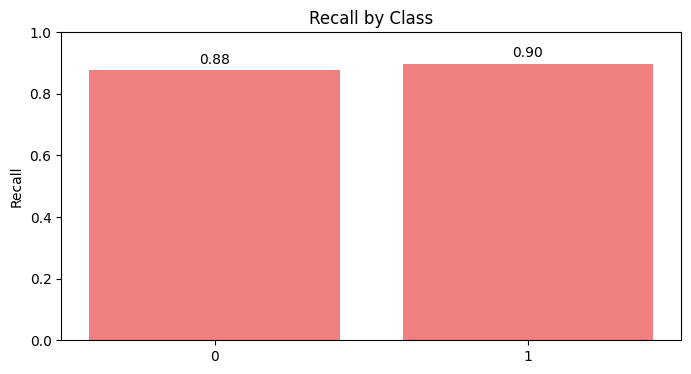

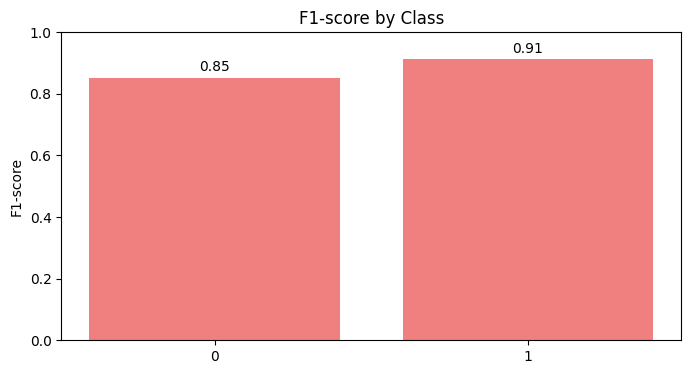

Scenario dataset_scenario_5_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 6_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running SVM with random for dataset_scenario_6_N...
Results will be saved in: SCORES\SVM\random\dataset_scenario_6_N
Best hyperparameters:  {'kernel': 'linear', 'gamma': 1, 'C': 10}
Validation Metrics:
  Accuracy: 0.8696
  Precision: 0.8711
  Recall: 0.8696
  F1 Score: 0.8699

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8675
  Recall: 0.8587
  F1 Score: 0.8605

Confusion Matrix (Test Set):
[[29  4]
 [ 9 50]]


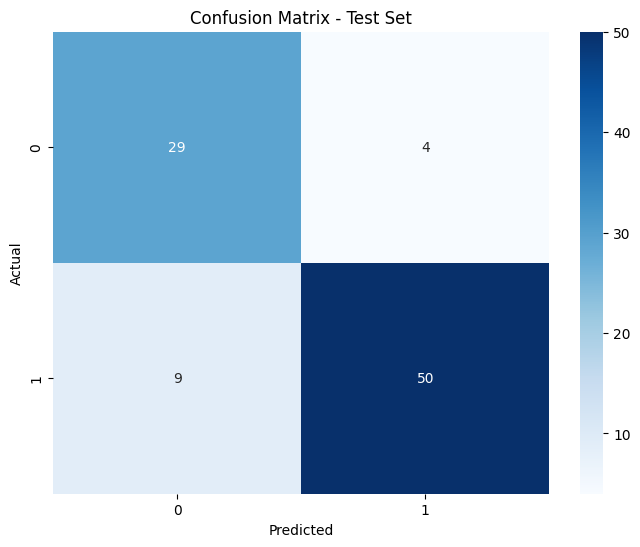

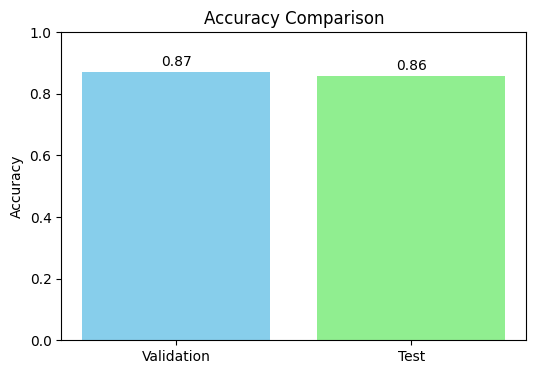

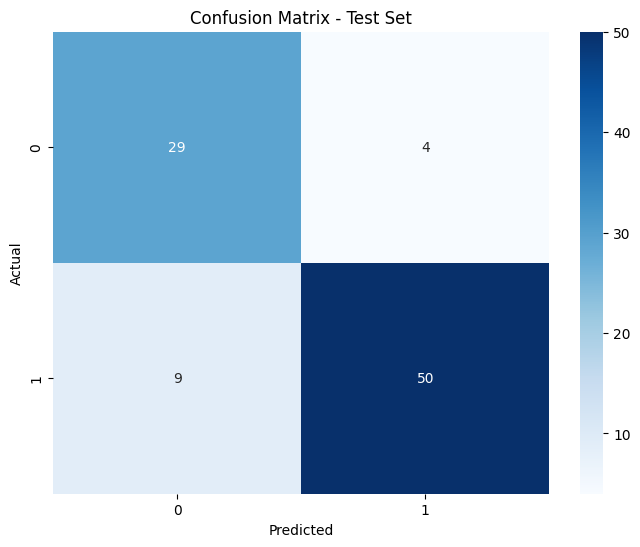

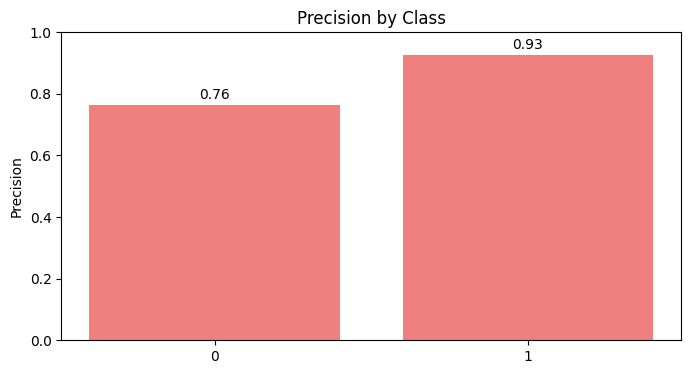

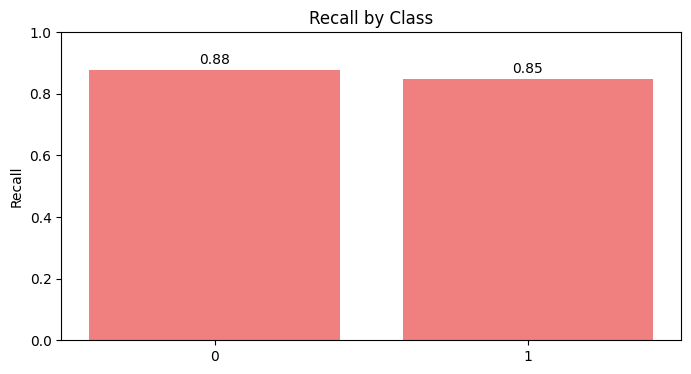

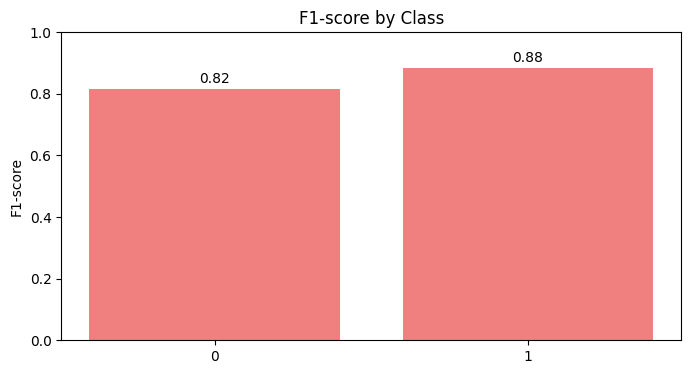

Scenario dataset_scenario_6_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 6_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: False
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with random for dataset_scenario_6_S...
Results will be saved in: SCORES\SVM\random\dataset_scenario_6_S
Best hyperparameters:  {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Validation Metrics:
  Accuracy: 0.8696
  Precision: 0.8711
  Recall: 0.8696
  F1 Score: 0.8699

Test Metrics:
  Accuracy: 0.8587
  Precision: 0.8630
  Recall: 0.8587
  F1 Score: 0.8599

Confusion Matrix (Test Set):
[[28  5]
 [ 8 51]]


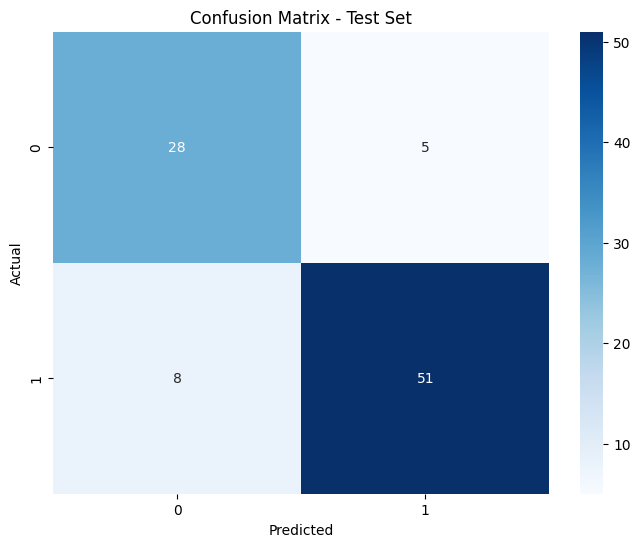

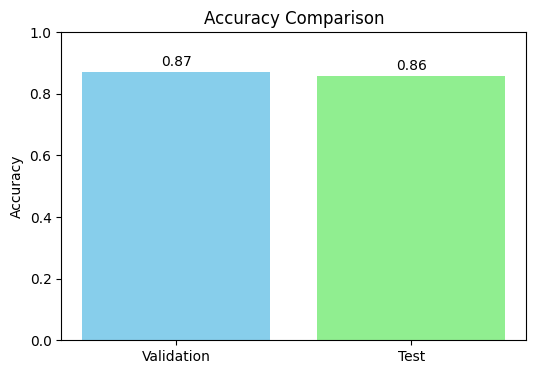

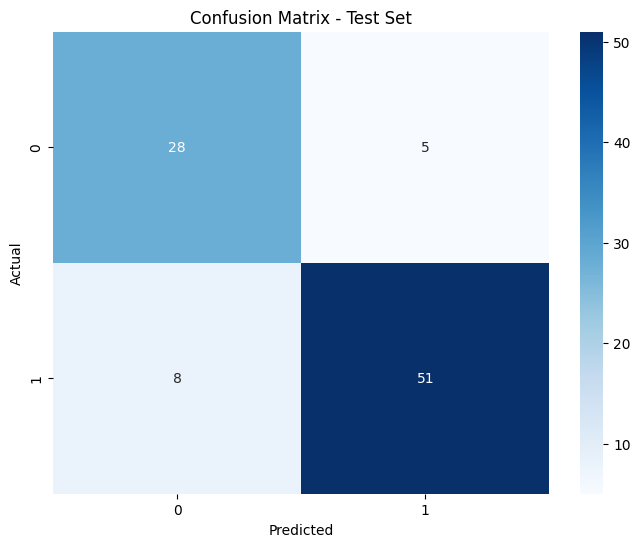

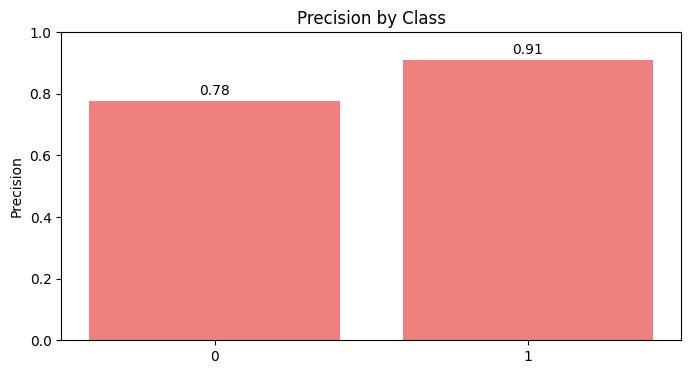

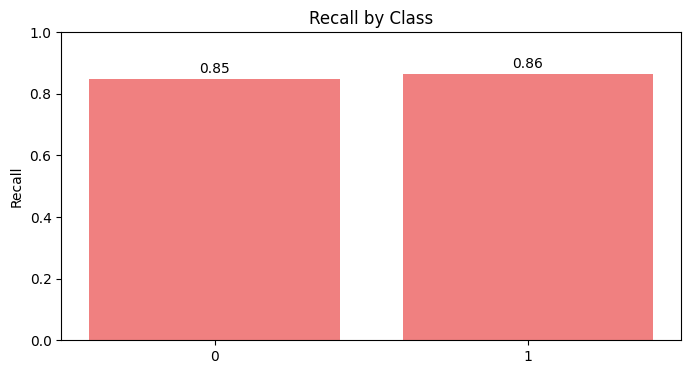

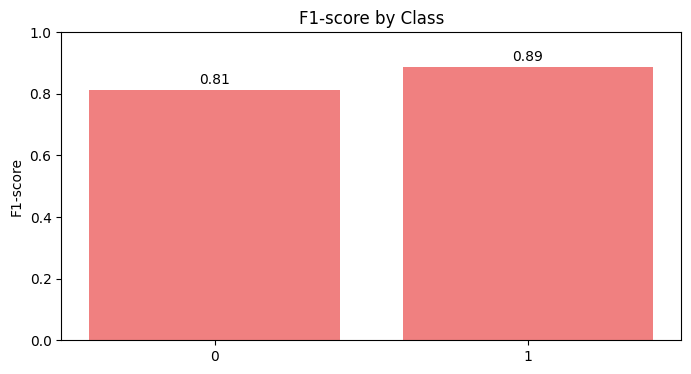

Scenario dataset_scenario_6_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 7_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with random for dataset_scenario_7_N...
Results will be saved in: SCORES\SVM\random\dataset_scenario_7_N
Best hyperparameters:  {'kernel': 'sigmoid', 'gamma': 0.1, 'C': 10}
Validation Metrics:
  Accuracy: 0.8571
  Precision: 0.8578
  Recall: 0.8571
  F1 Score: 0.8573

Test Metrics:
  Accuracy: 0.7746
  Precision: 0.8052
  Recall: 0.7746
  F1 Score: 0.7742

Confusion Matrix (Test Set):
[[27 13]
 [ 3 28]]


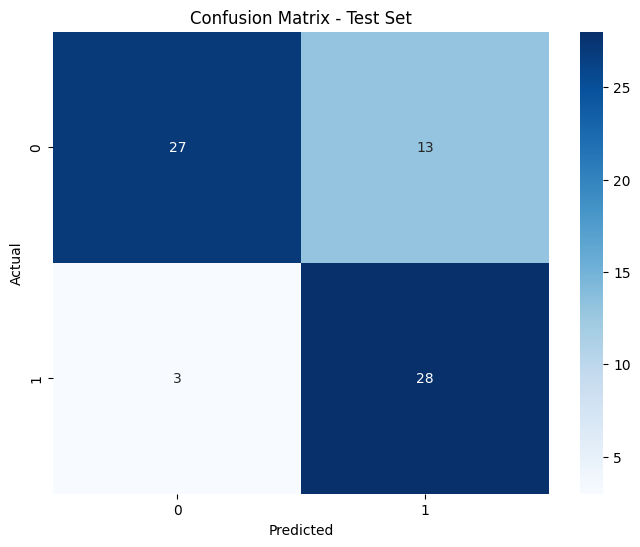

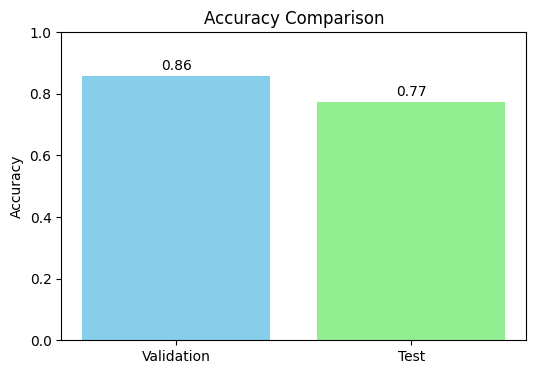

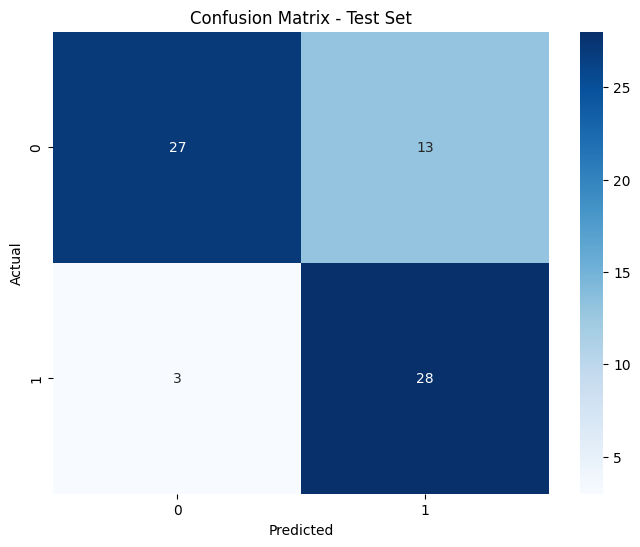

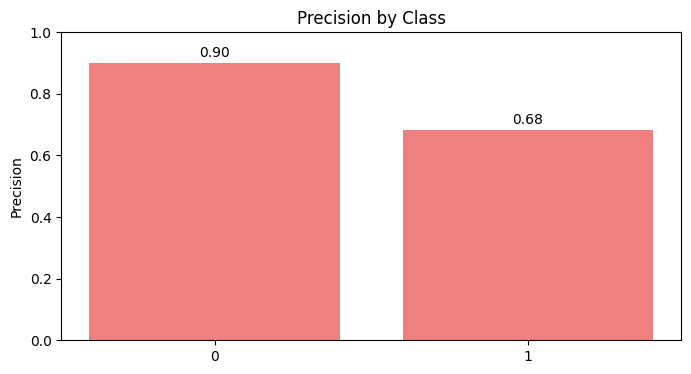

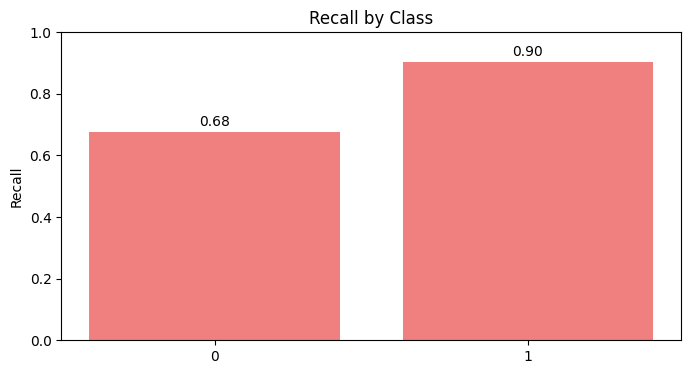

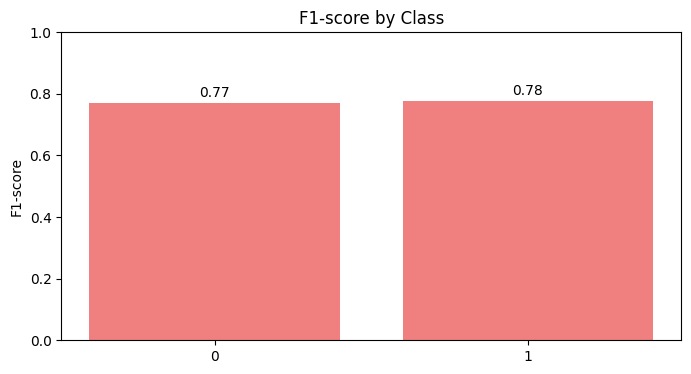

Scenario dataset_scenario_7_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 7_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: True
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with random for dataset_scenario_7_S...
Results will be saved in: SCORES\SVM\random\dataset_scenario_7_S
Best hyperparameters:  {'kernel': 'linear', 'gamma': 1, 'C': 0.1}
Validation Metrics:
  Accuracy: 0.8714
  Precision: 0.8721
  Recall: 0.8714
  F1 Score: 0.8716

Test Metrics:
  Accuracy: 0.8028
  Precision: 0.8240
  Recall: 0.8028
  F1 Score: 0.8031

Confusion Matrix (Test Set):
[[29 11]
 [ 3 28]]


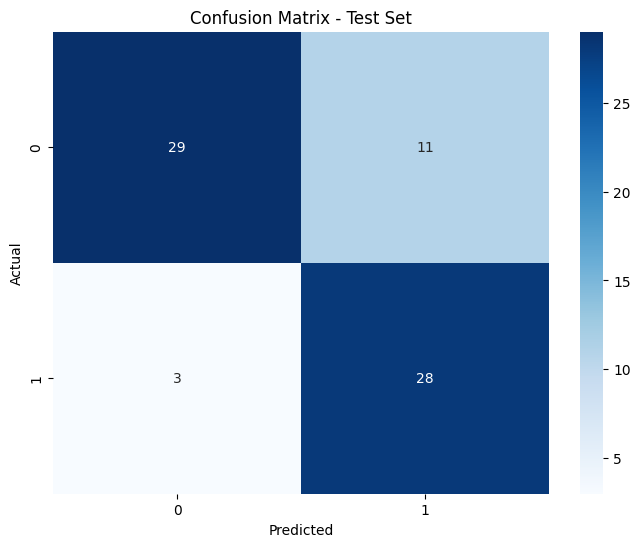

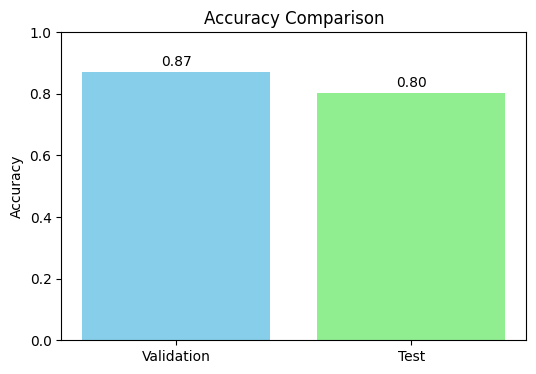

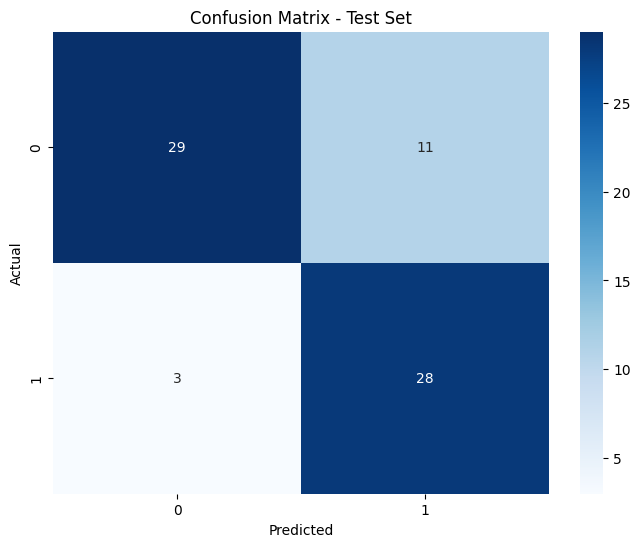

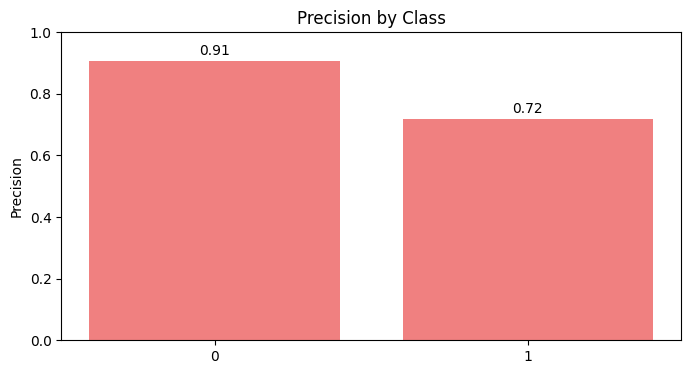

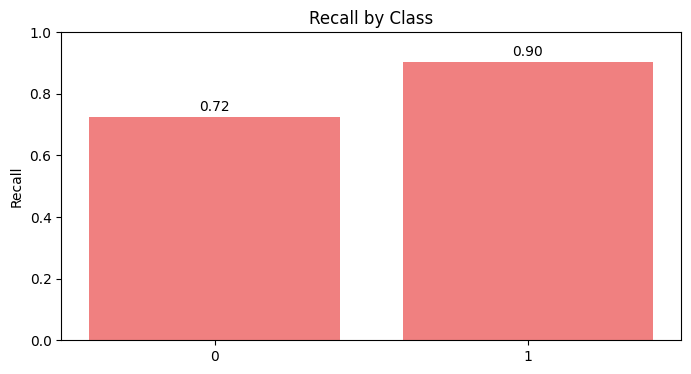

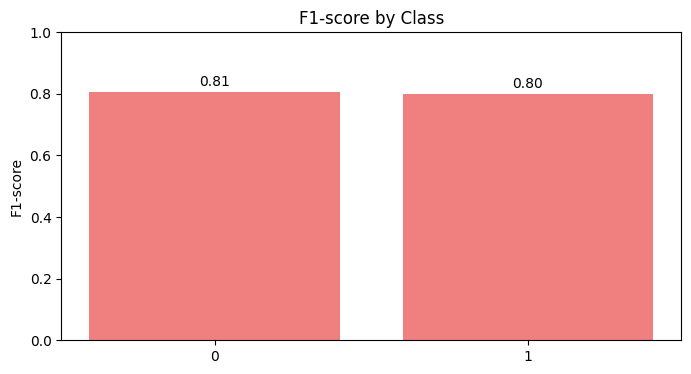

Scenario dataset_scenario_7_S with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 8_N
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: None
Running SVM with random for dataset_scenario_8_N...
Results will be saved in: SCORES\SVM\random\dataset_scenario_8_N
Best hyperparameters:  {'kernel': 'rbf', 'gamma': 1, 'C': 1}
Validation Metrics:
  Accuracy: 0.8533
  Precision: 0.8543
  Recall: 0.8533
  F1 Score: 0.8536

Test Metrics:
  Accuracy: 0.8696
  Precision: 0.8720
  Recall: 0.8696
  F1 Score: 0.8704

Confusion Matrix (Test Set):
[[28  5]
 [ 7 52]]


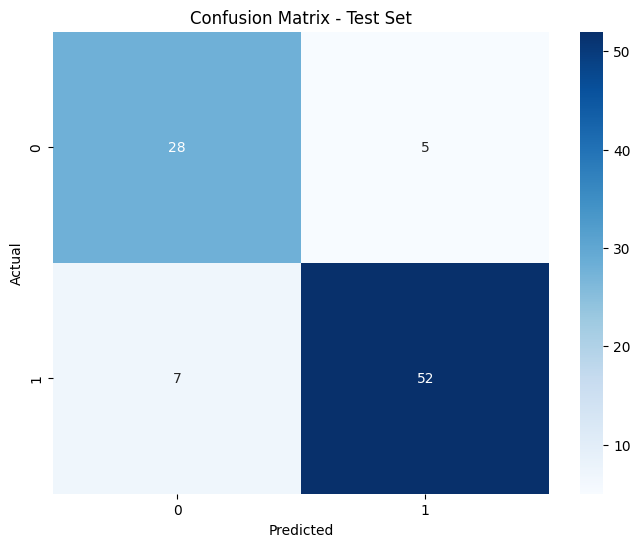

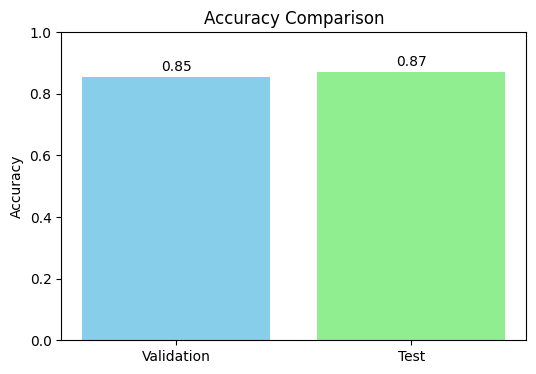

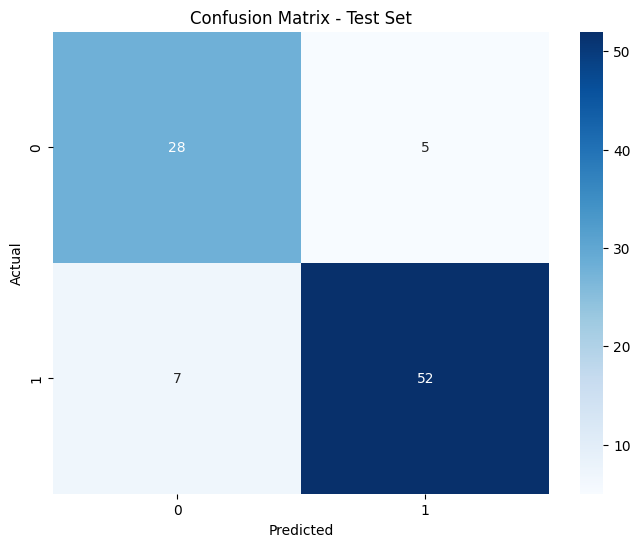

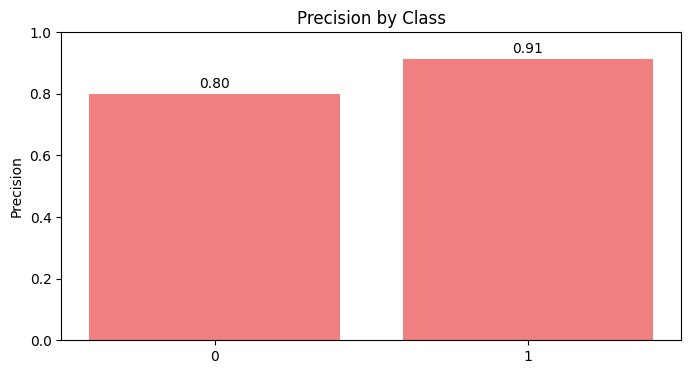

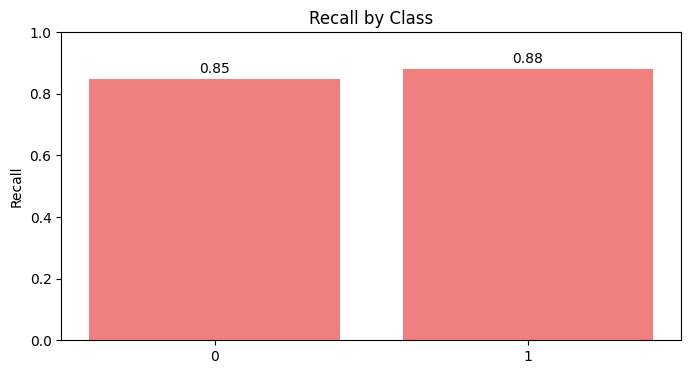

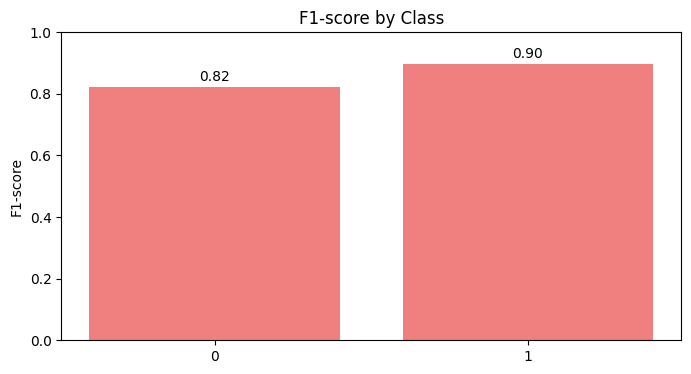

Scenario dataset_scenario_8_N with random completed and results saved.

----------------------------------------



Scenario Name: Scenario 8_S
  Encoding: {'Sex': 'Label', 'ExerciseAngina': 'Label', 'ST_Slope': 'Label', 'RestingECG': 'Label', 'ChestPainType': 'OneHot'}
  Remove Outliers: replace_with_mean
  Remove Errors: True
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: Standard
Running SVM with random for dataset_scenario_8_S...
Results will be saved in: SCORES\SVM\random\dataset_scenario_8_S
Best hyperparameters:  {'kernel': 'sigmoid', 'gamma': 0.01, 'C': 1}
Validation Metrics:
  Accuracy: 0.8641
  Precision: 0.8652
  Recall: 0.8641
  F1 Score: 0.8644

Test Metrics:
  Accuracy: 0.8478
  Precision: 0.8544
  Recall: 0.8478
  F1 Score: 0.8495

Confusion Matrix (Test Set):
[[28  5]
 [ 9 50]]


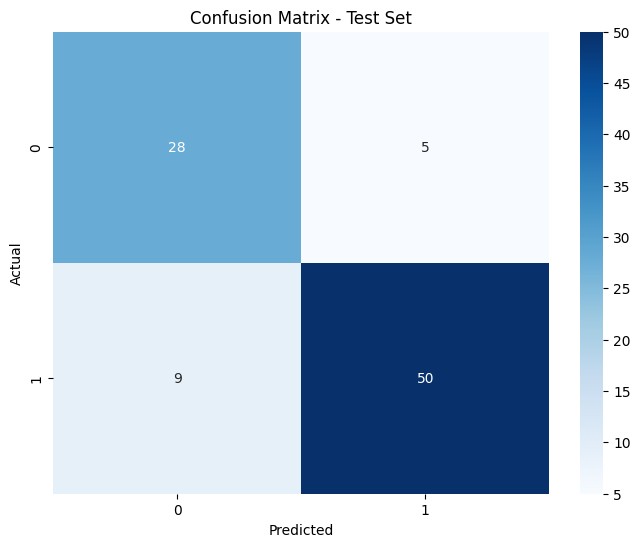

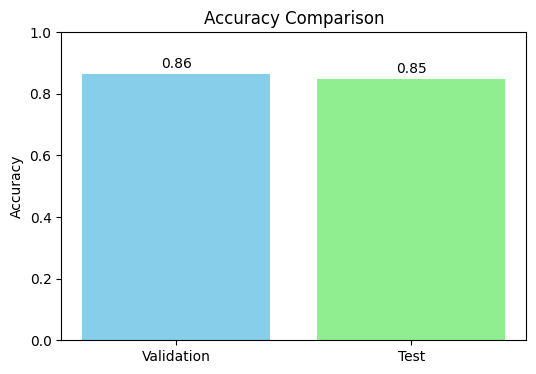

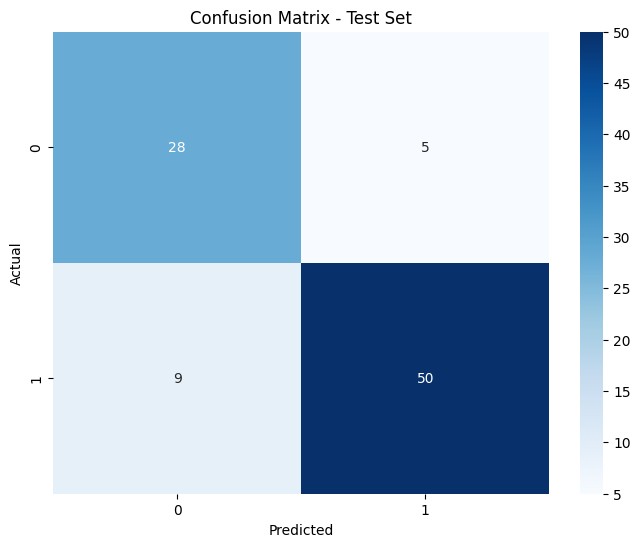

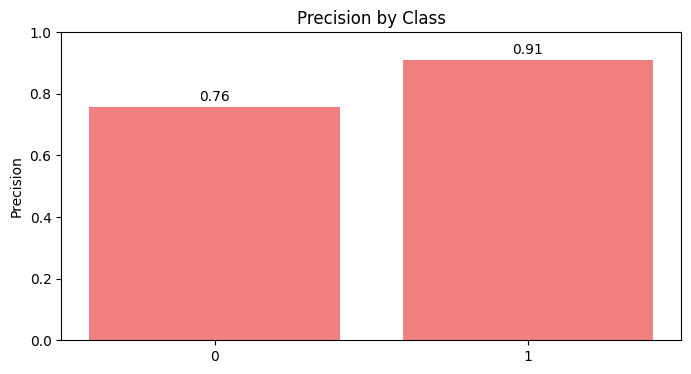

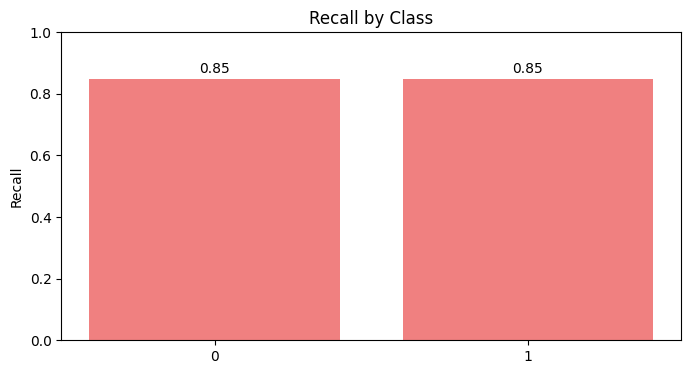

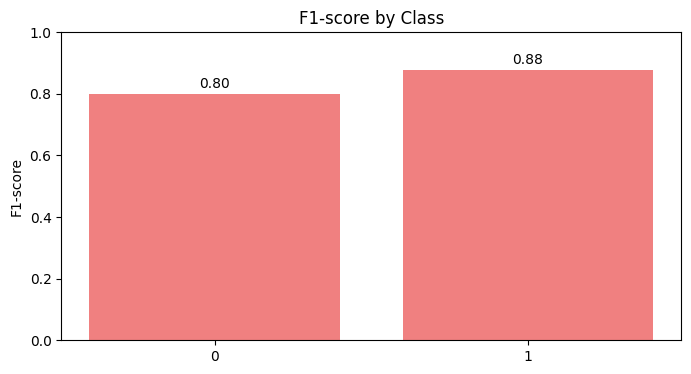

Scenario dataset_scenario_8_S with random completed and results saved.

----------------------------------------





In [13]:
for scenario, scenario_description in zip(scenario_datasets, scenarios_description):
    print(f"Scenario Name: {scenario_description['name']}")
    print(f"  Encoding: {scenario_description['encoding']}")
    print(f"  Remove Outliers: {scenario_description['remove_outliers']}")
    print(f"  Remove Errors: {scenario_description.get('remove_errors', 'Not Specified')}")
    print(f"  Impute Zeros: {scenario_description.get('impute_zeros', 'None')}")
    print(f"  Oldpeak Absolute: {scenario_description.get('oldpeak_abs', 'Not Specified')}")
    print(f"  Scaling: {scenario_description['scaling']}")

    run_scenario(scenario, "SVM", "random", search_config_random, get_search_hyperparameters("SVM"))

    print("-" * 40)
    print("\n\n")

## 3. Bayesian Optimization (Optuna)

In [14]:
for scenario, scenario_description in zip(scenario_datasets, scenarios_description):
    print(f"Scenario Name: {scenario_description['name']}")
    print(f"  Encoding: {scenario_description['encoding']}")
    print(f"  Remove Outliers: {scenario_description['remove_outliers']}")
    print(f"  Remove Errors: {scenario_description.get('remove_errors', 'Not Specified')}")
    print(f"  Impute Zeros: {scenario_description.get('impute_zeros', 'None')}")
    print(f"  Oldpeak Absolute: {scenario_description.get('oldpeak_abs', 'Not Specified')}")
    print(f"  Scaling: {scenario_description['scaling']}")
    # here the get_search_hyperparameters("SVM") is not used as the optuna_tuner class is used to tune the hyperparameters
    run_scenario(scenario, "SVM", "optuna", search_config_optuna, get_search_hyperparameters("SVM"))

    print("-" * 40)
    print("\n\n")

[I 2024-12-01 01:40:15,177] A new study created in memory with name: no-name-32bb7741-c20f-41b5-aa0e-837649f919e7


Scenario Name: Scenario 1_N
  Encoding: Label encoding
  Remove Outliers: False
  Remove Errors: False
  Impute Zeros: None
  Oldpeak Absolute: Not Specified
  Scaling: MinMax
Running SVM with optuna for dataset_scenario_1_N...
Results will be saved in: SCORES\SVM\optuna\dataset_scenario_1_N


[I 2024-12-01 01:40:18,031] Trial 0 finished with value: 0.8364219961240309 and parameters: {'C': 1.1410761151361164, 'gamma': 4.4683207864963554, 'kernel': 'linear'}. Best is trial 0 with value: 0.8364219961240309.
[I 2024-12-01 01:40:19,444] Trial 1 finished with value: 0.7787669573643411 and parameters: {'C': 1.1209095791358823, 'gamma': 6.020789567419553, 'kernel': 'poly'}. Best is trial 0 with value: 0.8364219961240309.
[I 2024-12-01 01:40:19,477] Trial 2 finished with value: 0.8176841085271317 and parameters: {'C': 9.65856326187458, 'gamma': 1.768268107594862, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8364219961240309.
[I 2024-12-01 01:40:20,243] Trial 3 finished with value: 0.7865915697674419 and parameters: {'C': 6.870319100701271, 'gamma': 5.735532279708397, 'kernel': 'poly'}. Best is trial 0 with value: 0.8364219961240309.
[I 2024-12-01 01:40:20,293] Trial 4 finished with value: 0.5358284883720931 and parameters: {'C': 3.8720555980005837, 'gamma': 3.0061158690133727, 'k

Best hyperparameters:  {'C': 5.697413589629062, 'gamma': 0.11999463910409207, 'kernel': 'linear'}


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.